# Ambient Intelligence and Domotics project

The scope of this project is to perform data augmentation over a dataset of inertial data using a diffusion model over the spectrograms obtained from the signals.
Diffusion models have been proved to be a powerful tool for images generation so the objective of the project is to leverage their power in a different context.

The pipeline is:
- Data exploration
- Preprocessing
- Training of diffusion model
- Training of fine tuned diffusion models
- Data augmentation using diffusion models
- Data augmentation using Smote
- Training of a HAR classifier over the two augmented datasets
- Results comparison

The spectogram generated over a 5 second signals has a dimension incompatible with the diffusion model structure so it was needed a ridimension tecnique.
The pipeline allows to choose between two ridimension tecniques: padding or upsampling.
I proceeded with both the tecniques because both were bringing some pro and cons.

Padding: no information loss is lost in the trasformation which, in an image of the size of the spectrogram ,could be a probelm given the small size of the images. At the same time it increases the size of the not relevant area, feeding the diffusion model a lot of information that are not important.

Upsampling: while upsampling augmented the importance (size) of the relevant information the smoothing introduced by upsampling may lead to loss of fine details and so of information.

Both the method have been trained and the comparison is shown at the end trough the results of the HAR classifier.

For all the training there is a common test set consisting of two subject which together constitute around the 10% of the original dataset.
These data are neither used for diffusion model trainings nor for smote augmentation.

The original plan was to adopt a LOOSO evaluation strategy; however, due to limited computational resources, this approach proved infeasible, and a fixed test set was employed instead. Since the test set was not augmented, it preserved the class imbalance present in the original dataset, which reduces its suitability.





## Setting

In [53]:
import numpy as np
from scipy.signal import stft
import matplotlib.pyplot as plt
import math
import pandas as pd
import math
from pathlib import Path
import os
from itertools import combinations


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

import seaborn as sns
from statistics import mode

from imblearn.over_sampling import SMOTE

import torch.optim as optim
import torchvision.models as models
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

from torchvision.utils import make_grid

from collections import Counter
from google.colab import drive
from diffusers import UNet2DModel

print("GPU available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU available: True


In [54]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Parameters

In [157]:
verbose = True
data_exploration = True

# Segmentation

window_len = 5
overlap = 0

# Spectrogram (I need it to be squared and a power of 2)

H = 32
W = H
fs = 50
nperseg = 30

#Unet parameters

layers_per_block = 2
block_out_channels = (32, 64, 128)

# Diffusion model parameter
timesteps = 400
beta_start = 1e-4
beta_end = 0.008
ridimension = "upsample" #padding o upsample
ridimension_cycle = ["padding" , "upsample"]

# Training diffusion model

epochs_diffusion = 100
learning_rate_diffusion = 1e-4
patience_diffusion = 5
min_delta_diffusion = 1e-4
batch_size_diffusion = 32
optimizer_diffusion = "Adam"
loss_function_diffusion = nn.MSELoss()

# Fine tuning diffusion model

epochs_finetune = 50
learning_rate_finetune = 1e-5
patience_finetune = 5
min_delta_finetune = 1e-4
scheduler_factor_finetune = 0.5
scheduler_patience_finetune = 3
scheduler_min_lr_finetune = 1e-7

# Data augmentation

target_count = 3000

# Training HAR classifier with augmented dataset

epochs_HAR = 100
batch_size_HAR = 45
learning_rate_HAR = 1e-4
patience_HAR = 14
patience_scheduler_HAR = 7
min_delta_HAR = 1e-4
scheduler_factor_HAR = 0.5
optimizer_HAR = "adam"
loss_HAR = nn.CrossEntropyLoss()



In [56]:
Parameters = {
    "model_name": "DiffusionModel",
    "dataset_name": "HARTH",
    "Verbose": verbose,
    "Segmentation parameters": "Segmentation parameters",
    "Window length for segmentation" : window_len,
    "overlap for segmentation": overlap,
    "Spectrogram parameters": "Spectrogram parameters",
    "dataset_height": H,
    "dataset_width": W,
    "fs": fs,
    "nperseg": nperseg,
    "Training parameters for diffusion model": "Training parameters",
    "epochs diffusion model": epochs_diffusion,
    "learning_rate diffusion model": learning_rate_diffusion,
    "patience diffusion model": patience_diffusion,
    "min_delta diffusion model": min_delta_diffusion,
    "batch_size diffusion model": batch_size_diffusion,
    "optimizer disffusion model": optimizer_diffusion,
    "loss_function_diffusion": loss_function_diffusion,
    "Unet Parameters": "Unet Parameters",
    "layers_per_block UNet": layers_per_block,
    "block_out_channels UNet": block_out_channels,
    "Diffusion model parameters": "Diffusion model parameters",
    "timesteps": timesteps,
    "beta_start": beta_start,
    "beta_end": beta_end,
    "ridimension": ridimension,
    "Data augmentation": "Data augmentation",
    "target_count": target_count,
    "Training HAR classifier with augmented dataset": "Training HAR classifier with augmented dataset",
    "epochs_HAR": epochs_HAR,
    "batch_size_HAR": batch_size_HAR,
    "learning_rate_HAR": learning_rate_HAR,
    "patience_HAR": patience_HAR,
    "min_delta_HAR": min_delta_HAR,
    "scheduler_factor_HAR": scheduler_factor_HAR,
    "optimizer_HAR": optimizer_HAR,
    "loss_HAR": loss_HAR,
}


In [ ]:
path=f"/content/gdrive/MyDrive/Diffusion_Model_Project/{ridimension}"
models_dir = os.path.join(path, "diffusion_models")
segmentation_path = "/content/gdrive/MyDrive/Diffusion_Model_Project"

## Data Exploration

In [131]:
#to access to the class names form the non encoded labels
activities_map = {
     "1": "walking",
     "2": "running",
     "3": "shuffling",
     "4": "stairs (ascending)",
     "5": "stairs (descending)",
     "6": "standing",
     "7": "sitting",
     "8": "lying",
    "13": "cycling (sit)",
    "14": "cycling (stand)",
    "130": "cycling (sit, inactive)",
    "140": "cycling (stand, inactive)",
}

# to access to the class name form the encoded labels
activities_map_2 = {
     "0": "walking",
     "1": "running",
     "2": "shuffling",
     "3": "stairs (ascending)",
     "4": "stairs (descending)",
     "5": "standing",
     "6": "sitting",
     "7": "lying",
    "8": "cycling (sit)",
    "9": "cycling (stand)",
    "10": "cycling (sit, inactive)",
    "11": "cycling (stand, inactive)",
}


subject_file_names = ['06']+[f"{i:02}" for i in range(8,11)]+[f"{i:02}" for i in range(12,30)]
subjects_ids = [6,8,9,10]+[i for i in range(12,30)]
activities = [1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 130, 140]

subjects_dict = {i:0 for i in subjects_ids}
acts_dict = {i:0 for i in activities}


In [132]:
if data_exploration == True:
  df = pd.DataFrame()

  # load data
  for txt in subject_file_names:
    print(txt)
    file_path = f"{segmentation_path}/harth/S0{txt}.csv"
    single_df=pd.read_csv(file_path)
    for index, row in single_df.iterrows():
      act_id=row['label']
      acts_dict[act_id] += 1
      subjects_dict[int(txt)] += 1
    single_df['subject_id']=int(txt)
    df = pd.concat([df,single_df],ignore_index=True)

  df.head()

06
08
09
10
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [133]:
if data_exploration == True:
  acts_dict = {activities_map[str(k)]: v for k, v in acts_dict.items()}
  print(acts_dict)
  print(subjects_dict)

{'walking': 1197155, 'running': 291356, 'shuffling': 254839, 'stairs (ascending)': 76217, 'stairs (descending)': 67253, 'standing': 743480, 'sitting': 2902703, 'lying': 428898, 'cycling (sit)': 393963, 'cycling (stand)': 55814, 'cycling (sit, inactive)': 41785, 'cycling (stand, inactive)': 7865}
{6: 408709, 8: 418989, 9: 154464, 10: 351649, 12: 382414, 13: 369077, 14: 366487, 15: 418392, 16: 355418, 17: 366609, 18: 322271, 19: 297945, 20: 371496, 21: 302247, 22: 337602, 23: 137646, 24: 170534, 25: 231729, 26: 195172, 27: 158584, 28: 165178, 29: 178716}


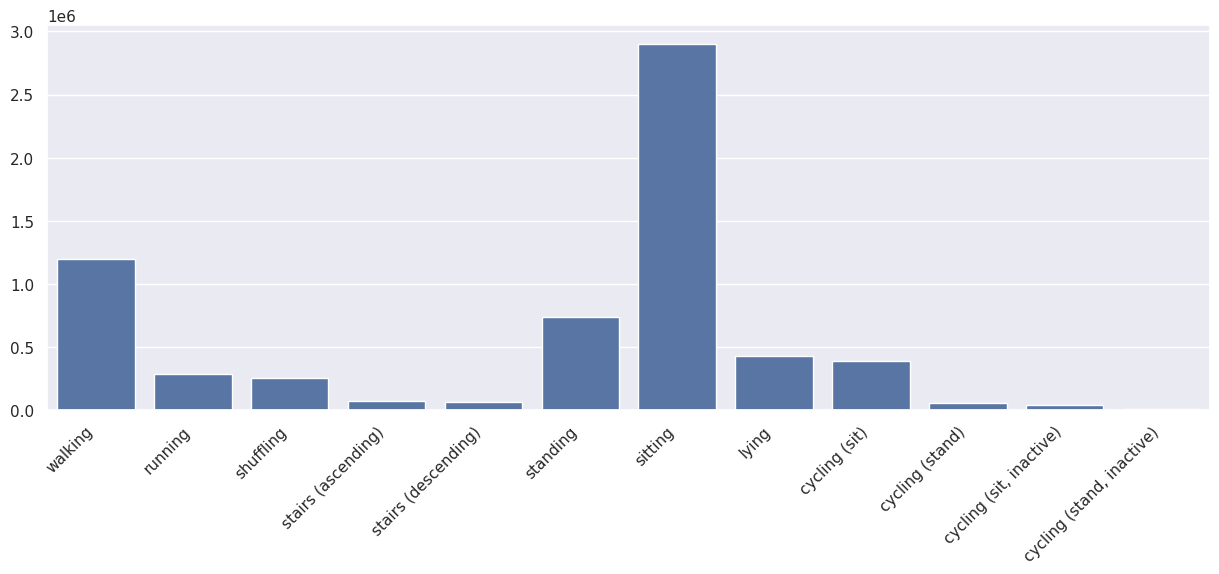

In [134]:
# plot the number of samples for each label
if data_exploration == True:
  sns.set(rc={'figure.figsize':(15,5)})
  sns.barplot(x=list(acts_dict.keys()), y=list(acts_dict.values()))
  plt.xticks(rotation=45, ha='right')  # ha = horizontal alignment
  plt.show()

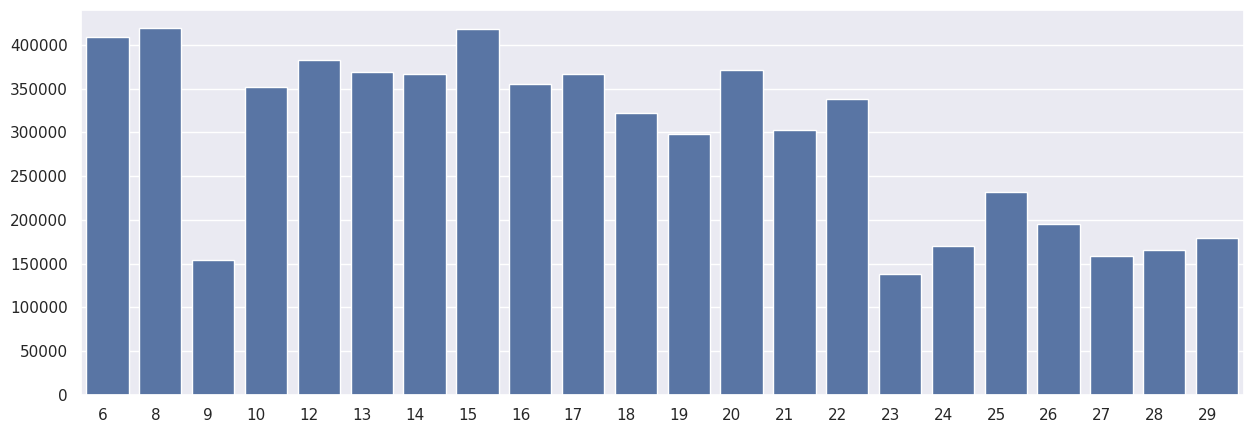

In [135]:
#plot the namber of samples for each subject
if data_exploration == True:

  sns.barplot(x=list(subjects_dict.keys()), y=list(subjects_dict.values()))
  plt.xticks(rotation=0, ha='right')
  plt.show()

In [136]:
# for each subject I can see the number of samples for each class
if data_exploration == True:

  acts_dict = {i:0 for i in activities}
  subjects_dict = {i:dict(acts_dict) for i in subjects_ids}
  print(subjects_dict)
  for txt in subject_file_names:
    print(int(txt))
    file_path = f"{segmentation_path}/harth/S0{txt}.csv"
    df_single=pd.read_csv(file_path)
    for index, row in df_single.iterrows():
      act_id=row['label']
      subjects_dict[int(txt)][act_id] += 1
    subjects_dict[int(txt)] = {activities_map[str(k)]:v for k,v in subjects_dict[int(txt)].items() if v>0}
    print(subjects_dict[int(txt)])

{6: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 13: 0, 14: 0, 130: 0, 140: 0}, 8: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 13: 0, 14: 0, 130: 0, 140: 0}, 9: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 13: 0, 14: 0, 130: 0, 140: 0}, 10: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 13: 0, 14: 0, 130: 0, 140: 0}, 12: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 13: 0, 14: 0, 130: 0, 140: 0}, 13: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 13: 0, 14: 0, 130: 0, 140: 0}, 14: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 13: 0, 14: 0, 130: 0, 140: 0}, 15: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 13: 0, 14: 0, 130: 0, 140: 0}, 16: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 13: 0, 14: 0, 130: 0, 140: 0}, 17: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 13: 0, 14: 0, 130: 0, 140: 0}, 18: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 13: 0, 14: 0, 130: 0, 140: 0}, 19: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 13: 0, 14: 0, 130: 0, 140

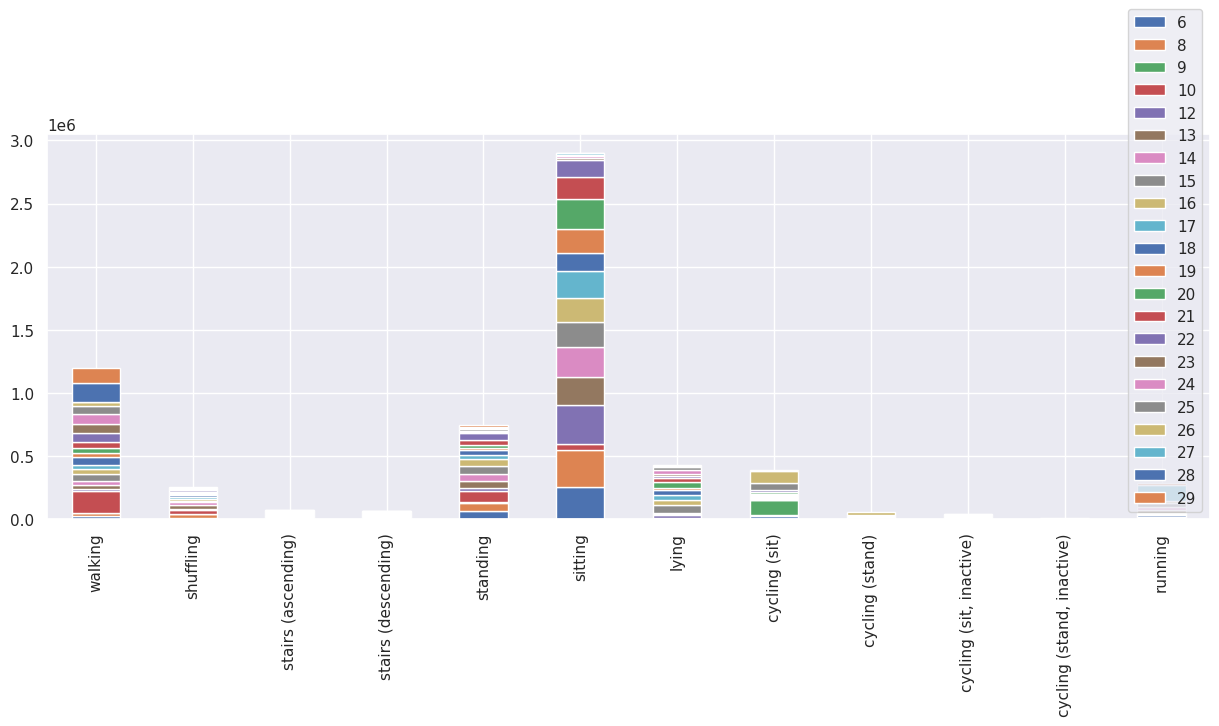

In [137]:
# plot of the distribution of the subjects over the classes
if data_exploration == True:
  df_= pd.DataFrame(subjects_dict)
  df_.plot(kind='bar', stacked=True)
  plt.show()

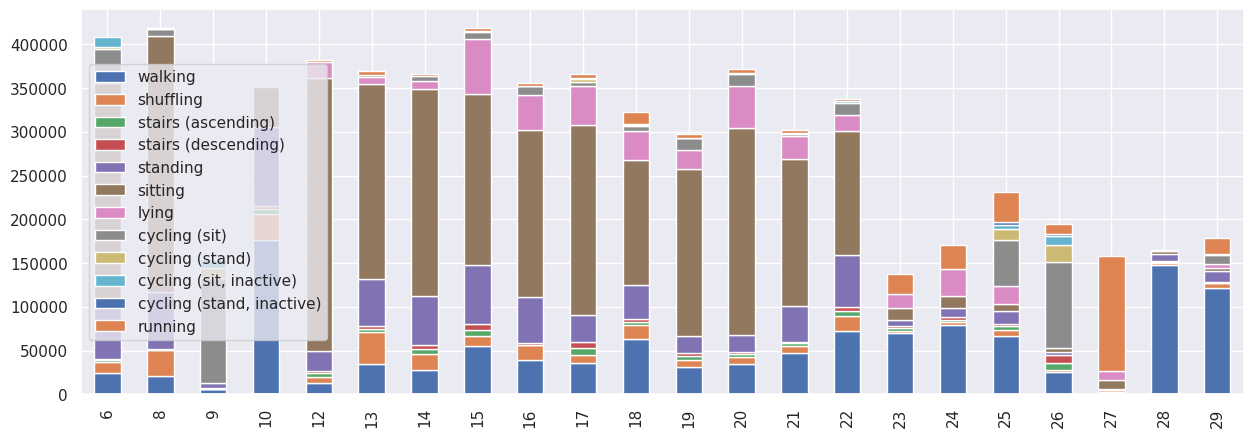

In [138]:
# plot of the distribution of classes over the subjects
if data_exploration == True:
  transposed_df = df_.T
  transposed_df.plot(kind='bar', stacked=True)
  plt.show()

/tmp/ipython-input-2146118790.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tmp_df["thigh_z"].rolling(window=5, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill").plot()


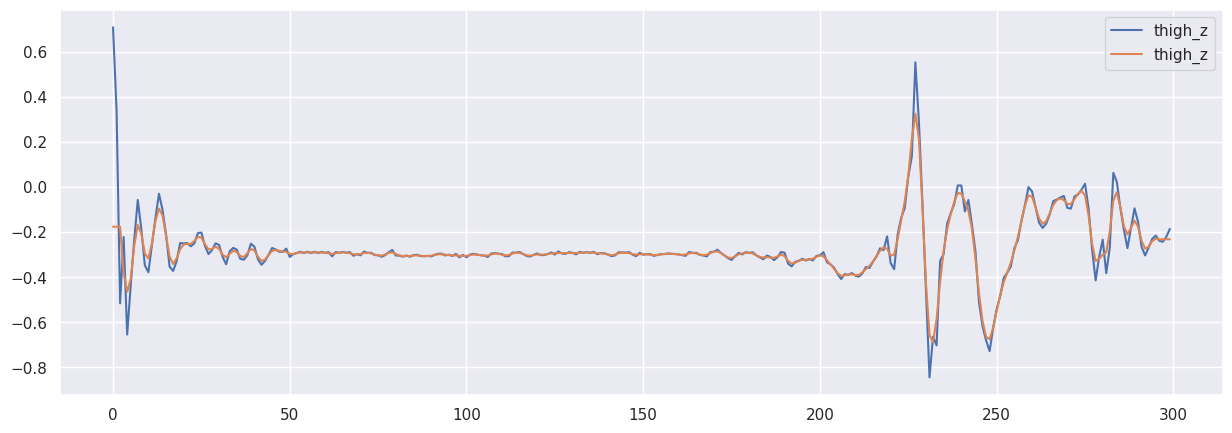

In [139]:
# Smoothing trial
if data_exploration == True:
  starting_index = 0
  window_len_temp = 300
  tmp_df= df.iloc[starting_index:starting_index + window_len_temp]
  tmp_df["thigh_z"].plot()

  tmp_df["thigh_z"].rolling(window=5, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill").plot()

  plt.legend()
  plt.show()

Check for Null value after the removal of the two unnecessary columns and there are not

In [140]:
if data_exploration == True:
  #remove un necessary columns
  df_original = df.copy(); # so if I need the original I have it
  df=df.drop(columns=['index','Unnamed: 0'])
  # check if there are Null value
  df.isnull()
  df.isnull().any()

In [141]:
def plotInertialWindow(df, starting_index, window_len, df_columns):
  tmp_df = df.iloc[starting_index:starting_index+window_len]         # get a window of window_len rows/measurements of the dataframe
  tmp_df = tmp_df.reset_index()       # reset_index() add a column named "index" that you can use as x-axis

  # get the most frequent label in this segment of measurements
  labels_list = list(tmp_df["label"])
  label = mode(labels_list)
  label = str(label)

  for col_name in df_columns:
    sns.lineplot(data=tmp_df, x='index', y=col_name, label=col_name)

  plt.ylabel("value")
  plt.title(activities_map[label])
  plt.show()

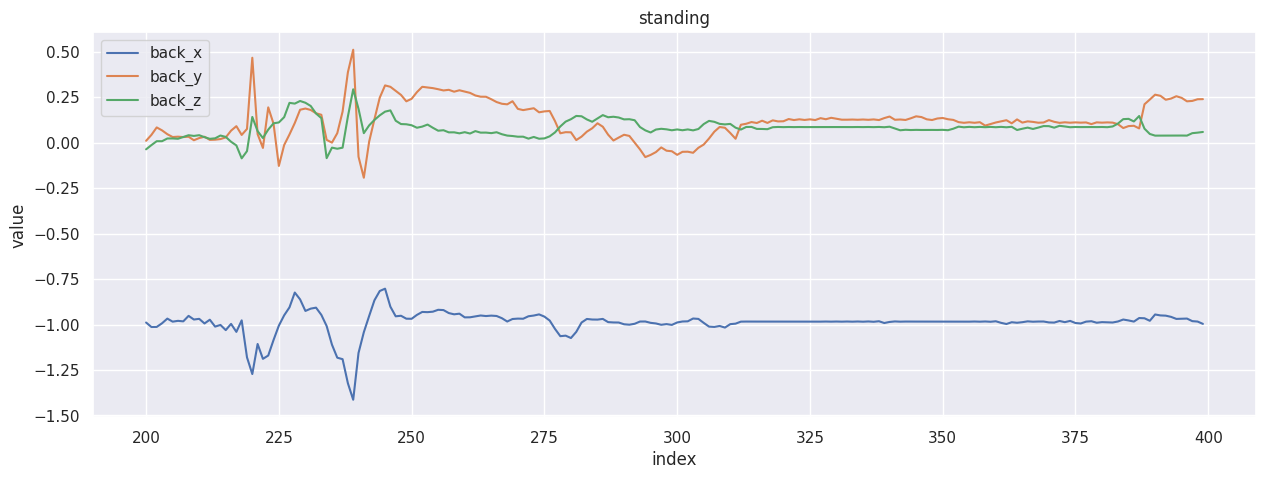

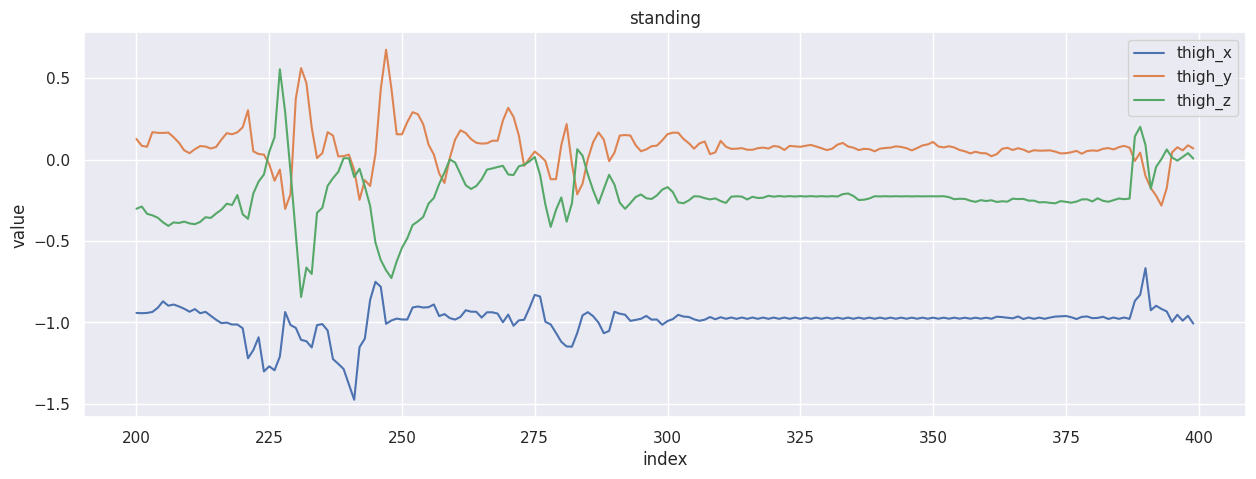

In [142]:
if data_exploration == True:

  sensors_temp=['back_x','back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
  plotInertialWindow(df, starting_index=200, window_len = 200, df_columns=[sensors_temp[0], sensors_temp[1], sensors_temp[2]])
  plotInertialWindow(df, starting_index=200, window_len = 200, df_columns=[sensors_temp[3], sensors_temp[4], sensors_temp[5]])

check if there is need for time resample, and there is

In [143]:
if data_exploration == True:

  # check if i have sampling rate problems by creating an alert column
  df_temp = pd.DataFrame()
  df_temp['timestamp'] = pd.to_datetime(df['timestamp'])

  df_temp['time'] = df_temp['timestamp'].dt.time

  #calculate timestamp differences
  df_temp['time_diff'] = df_temp['timestamp'].diff().dt.total_seconds()

  # if a diference is different form 0.02 = 50 HZ then the alert column will contain True
  df_temp['alert'] = df_temp['time_diff'].ne(0.02)

  print(df_temp['alert'])
  df_temp['time_diff'].unique()

0           True
1           True
2           True
3           True
4           True
           ...  
6461323    False
6461324    False
6461325    False
6461326    False
6461327    False
Name: alert, Length: 6461328, dtype: bool


## Preprocessing

In [150]:
def Preprocessing(txt,path,sensors):
  print(txt)
  print("\tCreating the dataframe\n")

  file_path = f"{path}/harth/S0{txt}.csv"
  single_df=pd.read_csv(file_path)

  cols_to_drop = [c for c in ['index', 'Unnamed: 0'] if c in single_df.columns]
  single_df = single_df.drop(columns=cols_to_drop, errors='ignore')

  if single_df.shape[1] != 8:
    raise ValueError(f"{file_path}: uncorrect shape ({single_df.shape[1]})")

  single_df.columns = ['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label']
  single_df['label'] = pd.to_numeric(single_df['label'], errors='coerce').astype('Int64')
  single_df['subject_id'] = int(txt)

  if single_df.isnull().values.any():
    print("\tHandling missing values\n")
    for col in sensors:
      single_df[col] = single_df[col].interpolate()

  print("\tRemoving outliers \n")
  for col in sensors:
    try:
        single_df[col] = (
            single_df[col]
            .rolling(window=5, center=True, win_type='gaussian')
            .mean(std=1)
            .bfill().ffill()
        )
    except Exception:
        single_df[col] = single_df[col].rolling(window=5, center=True).mean().bfill().ffill()
        print("Exception raised")

  print("\tTemporal alignment and data resampling")
  single_df['abs_datetime'] = pd.to_datetime(single_df['timestamp'])
  single_df = single_df.set_index('abs_datetime').sort_index()
  single_df = single_df.resample('20ms').ffill().bfill() #20 mms since the sampling frequency is 50hZ
  single_df[sensors] = single_df[sensors].interpolate(method='time').ffill().bfill()
  single_df['label'] = single_df['label'].ffill().bfill()

  single_df['timestamp'] = single_df.index

  return single_df

In [151]:
def Segment(subject,df,sensors, win_size, window_len, overlap):
  back_samples, thigh_samples, labels, subjects, tss = [], [], [], [], []
  subject = int(subject)
  print(f"Subject {subject}\n")

  # get the sub-dataframe that contains only the data samples of the considered subject
  subject_df = df.loc[df['subject_id'] == subject].copy()
  print(len(subject_df))
  # convert the timestamp column to datetime format
  subject_df.loc[:,'timestamp'] = pd.to_datetime(subject_df['timestamp'])

  # found the first timestamp
  reference_time = subject_df['timestamp'].min()

  # for each sample the relative time are the seconds passed from tthe first timestamp
  subject_df.loc[:, 'relative_time'] = (subject_df['timestamp'] - reference_time).dt.total_seconds()

  # get the vrealtive time for first timestamp for the subject
  start_ts = subject_df.iloc[0]['relative_time'] # equal to 0

  # get the realtive time for the last timestamp for the subject
  last_ts = subject_df.iloc[-1]['relative_time']

  while start_ts < last_ts:     # loop until all the subject's data samples will be scanned
    end_ts = start_ts + window_len

    # get the portion of dataframe included between the start and the end timestamps
    tmp_df = subject_df.loc[(subject_df['relative_time'] >= start_ts) & (subject_df['relative_time'] < end_ts)]

    # create windows of accelerometer and gyroscope data
    back_win = tmp_df[["back_x", "back_y", "back_z"]].to_numpy()
    thigh_win = tmp_df[["thigh_x", "thigh_y", "thigh_z"]].to_numpy()

    # we go on only if the windows include the right amount of measurments (so to exclude the last window which is probably be too short)
    if (len(back_win) == win_size ) and (len(thigh_win) == win_size ):

      # get the most frequent label  in tmp_df

      lab = tmp_df['label'].mode(dropna=True)
      lab = int(lab.iloc[0])

      # check that the most frequent label is present in 75 % or more of the segment
      label_counts = tmp_df['label'].value_counts(normalize=True)
      mode_frequency = label_counts.get(lab, 0)

      # save the segment only if the label is prominent
      if mode_frequency >= 0.75:
        back_samples.append(back_win)
        thigh_samples.append(thigh_win)
        labels.append(lab)
        subjects.append(subject)
        tss.append(start_ts)

    # update the start timestamp
    start_ts = end_ts - overlap
  return back_samples, thigh_samples, labels, subjects, tss

In [152]:
def SaveData(path, subject_file_names, window_len, overlap):
  df = pd.DataFrame()
  sensors = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']

  # for each subject preprocess the data and concatenate the single subject df to the complete one
  for txt in subject_file_names:
    single_df = Preprocessing(txt,path,sensors);
    df = pd.concat([df, single_df], ignore_index=True)

  sampling_rate = 50
  win_size = window_len * sampling_rate

  back_samples, thigh_samples, labels, subjects, tss = [], [], [], [], []
  subject_df=pd.DataFrame()

  for subject in subject_file_names:
    single_back_samples, single_thigh_samples, single_labels, single_subjects, single_tss = Segment(subject,df,sensors, win_size, window_len, overlap)
    back_samples = back_samples + single_back_samples
    thigh_samples = thigh_samples + single_thigh_samples
    labels = labels + single_labels
    subjects = subjects + single_subjects
    tss = tss + single_tss

  back_samples = np.asarray(back_samples)
  thigh_samples = np.asarray(thigh_samples)
  labels = np.asarray(labels)
  subjects = np.asarray(subjects)
  tss = np.asarray(tss)

  # trasform the labels in the encoded version ( 0-11)
  le = LabelEncoder()
  labels_enc = le.fit_transform(labels)


  print()
  print(f"backelerometer data: {back_samples.shape}")
  print(f"Gyroscope data: {thigh_samples.shape}")
  print(f"Labels data: {labels.shape}")
  print(f"Subjects data: {subjects.shape}")


  save_path =Path( f"{path}/Segmented_data_win_{window_len}s")
  save_path.mkdir(parents=True, exist_ok=True)

  np.save(save_path / "back_samples.npy", back_samples)
  np.save(save_path / "thigh_samples.npy", thigh_samples)
  np.save(save_path / "labels.npy", labels_enc)
  np.save(save_path / "subjects.npy", subjects)
  np.save(save_path / "tss.npy", tss)

  print("Data saved in:", save_path)

In [153]:
# Preprocessing or loading
load_path = Path(f"{segmentation_path}/Segmented_data_win_{window_len}s")
back_samples, thigh_samples, labels, subjects, tss = [], [], [], [], []


if not load_path.exists():
  # if the data havent been saved yet proceed with the generation
  SaveData(segmentation_path, subject_file_names,   window_len, overlap);

# then the data is present and is loaded from the drive directory
back_samples = np.load(load_path / "back_samples.npy")
thigh_samples = np.load(load_path / "thigh_samples.npy")
labels = np.load(load_path / "labels.npy")
subjects = np.load(load_path / "subjects.npy")
tss = np.load(load_path / "tss.npy")

print("Data loaded succesfully")
print("back_samples shape:", back_samples.shape)
print("thigh_samples shape:", thigh_samples.shape)
print("labels shape:", labels.shape)
print("subjects shape:", subjects.shape)
print("tss shape:", tss.shape)


Data loaded succesfully
back_samples shape: (23356, 250, 3)
thigh_samples shape: (23356, 250, 3)
labels shape: (23356,)
subjects shape: (23356,)
tss shape: (23356,)


## Spectrogram creation and visualization:
In this section are defined the function later used to construct the spectrograms of the windows

In [75]:
def create_rgb(win, fs, nperseg):
    channels = []
    # for each channel of the signal x,y,z Claculate the spectrogram
    for i in range(3):
        noverlap = nperseg // 2
        f, t, Zxx = stft(win[:, i], fs=fs, nperseg=nperseg, noverlap=noverlap)
        spec = np.abs(Zxx)
        # log scale
        spec = np.log1p(spec)

        #normalisation in [0,1] range
        spec_min = spec.min()
        spec_max = spec.max()
        if (spec_max - spec_min) > 1e-8:
            spec = (spec - spec_min) / (spec_max - spec_min)
        else:
            spec = spec - spec_min
        channels.append(spec)
    img = np.stack(channels, axis=-1)
    return img

def window_to_rgb_image(back_win, thigh_win, fs=50, nperseg=50):
    back_img = create_rgb(back_win, fs, nperseg)
    thigh_img = create_rgb(thigh_win, fs, nperseg)
    img = np.concatenate([back_img, thigh_img], axis=-1)
    return back_img, thigh_img, img


In [76]:
# plot of a random spectrogram
if verbose == True :
  i = np.random.randint(0, len(back_samples))
  b_win = back_samples[i]
  t_win = thigh_samples[i]
  back_img, thigh_img, combined_img = window_to_rgb_image(b_win, t_win, fs=fs, nperseg=nperseg)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
  fig.suptitle(f'6 channels image (Index {i}, attività {labels[i]})', fontsize=16)

  # Back spectrogram interpreted as a RGB image
  ax1.imshow(combined_img[:, :, :3], aspect='auto', origin='lower')
  ax1.set_title('Sensor BACK (Canali 0-2)')

  # Thigh spectrogram interpreted as a RGB image
  ax2.imshow(combined_img[:, :, 3:], aspect='auto', origin='lower')
  ax2.set_title('Sensor THIGH (Canali 3-5)')

  plt.tight_layout()
  plt.show()
  print(f"Image dimensions {combined_img[:,:,1].shape}")

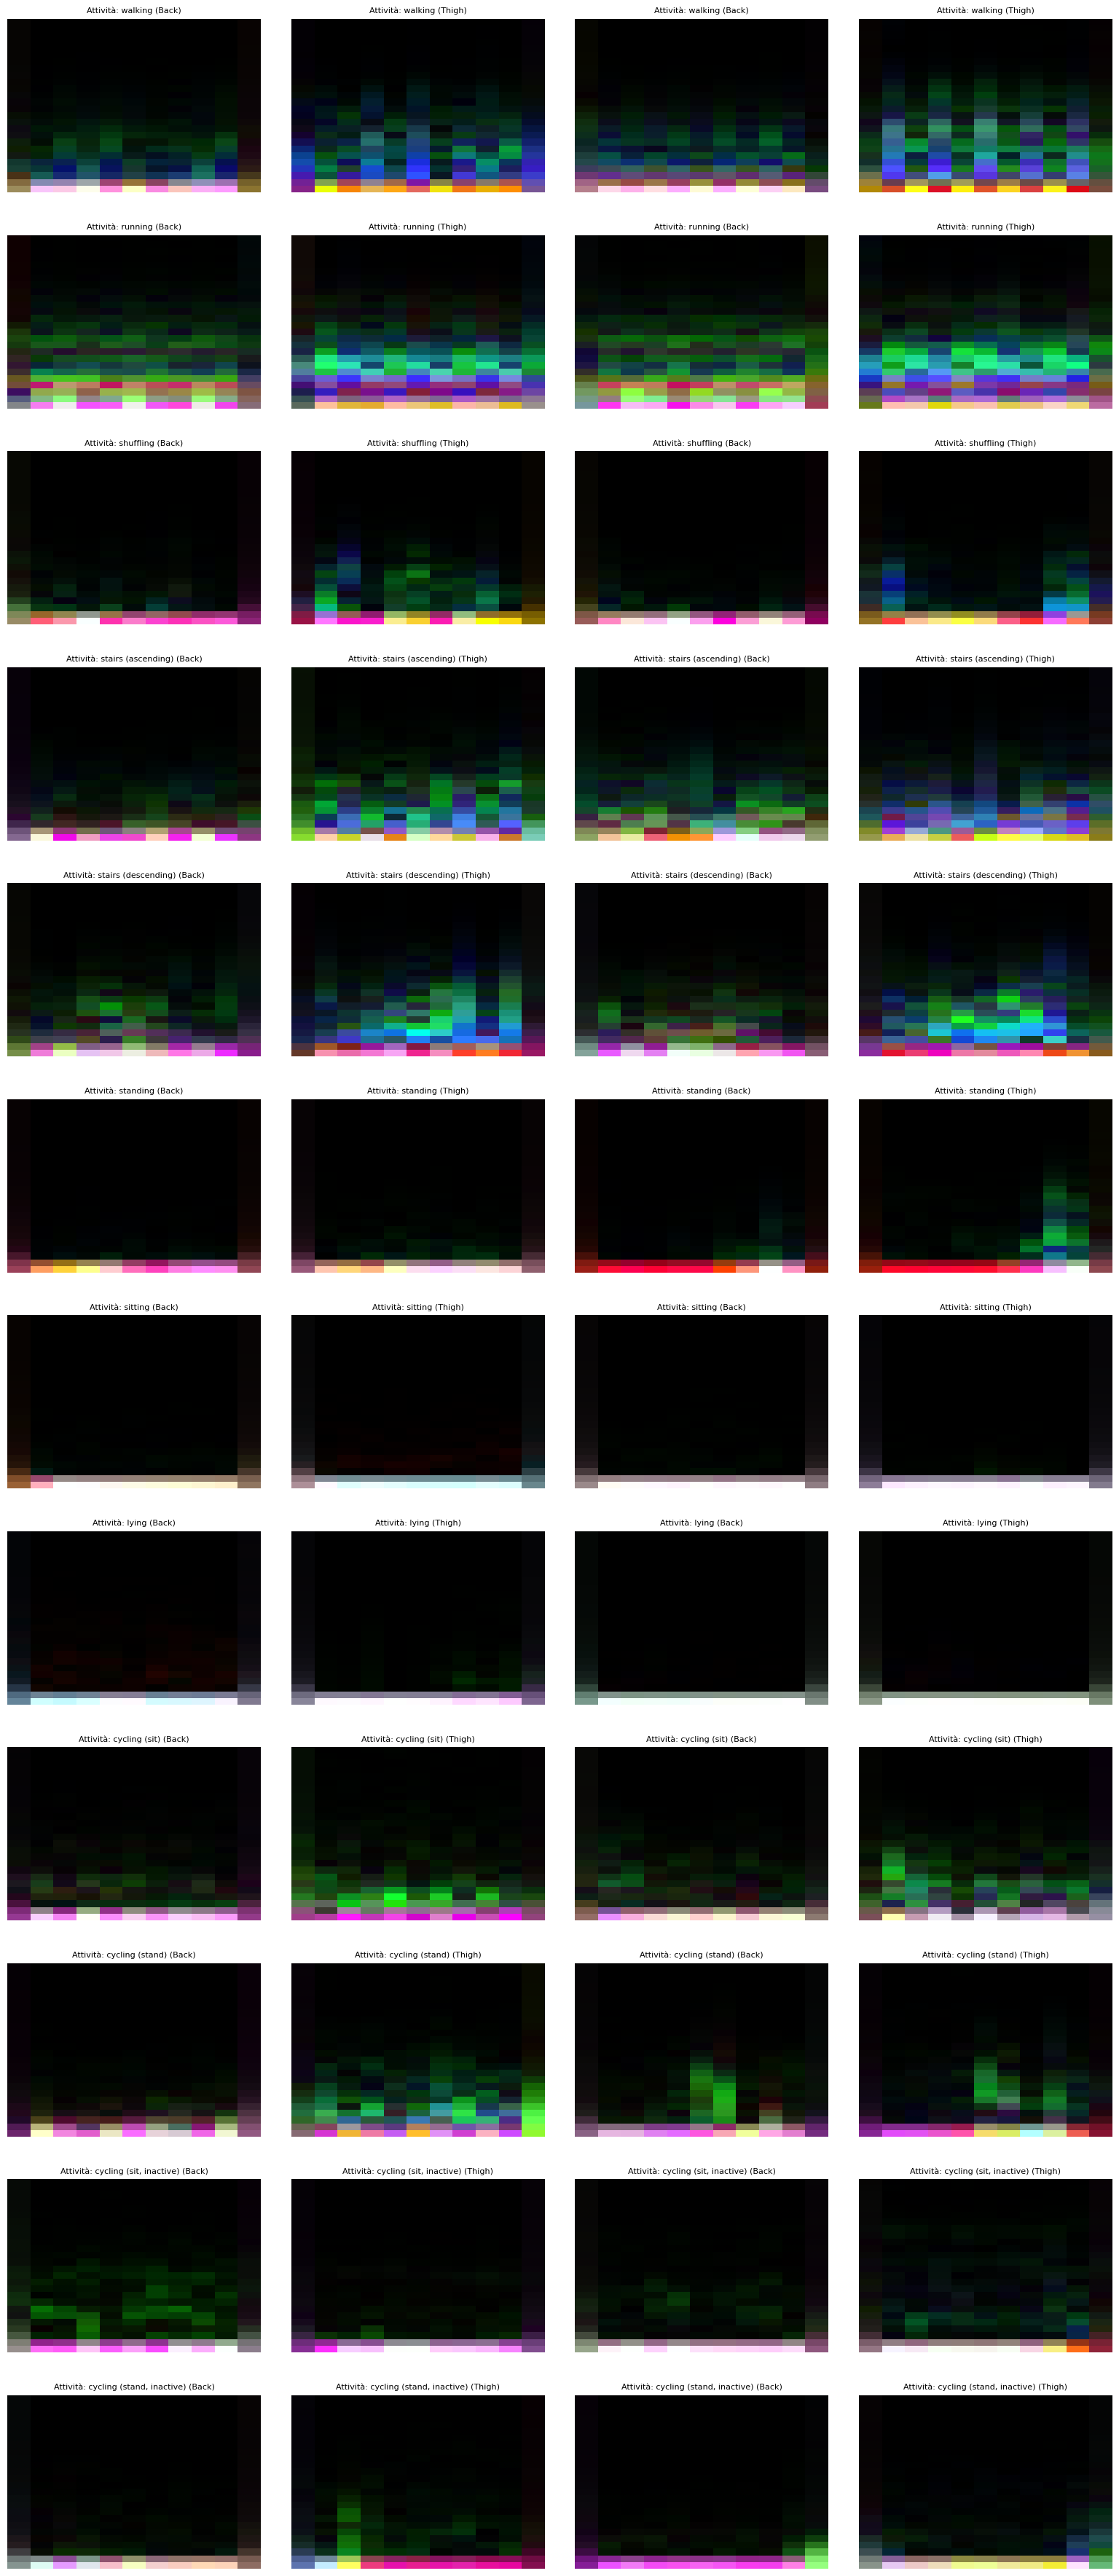

In [77]:
# plot to visualise some exple of spectrograms for each activity

num_samples_to_show = 2
unique_activities = np.unique(labels)
num_classes = len(unique_activities)

fig, axes = plt.subplots(
    num_classes, num_samples_to_show * 2,
    figsize=(4 * num_samples_to_show * 2, 3 * num_classes)
)


for i, activity_label in enumerate(unique_activities):

    activity_indices = np.where(labels == activity_label)[0]

    if len(activity_indices) >= num_samples_to_show:
        selected_indices = np.random.choice(activity_indices, num_samples_to_show, replace=False)
    # not really necessary but is a control in case of previous mistake
    else:
        selected_indices = activity_indices
        print(f" Warning '{activities_map_2.get(str(activity_label), 'unknown')}' "
              f"has only {len(activity_indices)} samples.")

    for j, idx in enumerate(selected_indices):
        back_data = back_samples[idx]
        thigh_data = thigh_samples[idx]

        back_img, thigh_img, _ = window_to_rgb_image(back_data, thigh_data, fs=50, nperseg=50)

        if j < num_samples_to_show:
            ax1 = axes[i, j * 2]
            ax1.imshow(back_img, aspect='auto', origin='lower')
            activity_name = activities_map_2.get(str(activity_label), "Sconosciuta")
            ax1.set_title(f"Attività: {activity_name} (Back)", fontsize=8)
            ax1.axis('off')

            ax2 = axes[i, j * 2 + 1]
            ax2.imshow(thigh_img, aspect='auto', origin='lower')
            ax2.set_title(f"Attività: {activity_name} (Thigh)", fontsize=8)
            ax2.axis('off')

plt.tight_layout(pad=3.0)
plt.show()

## Diffusion model

### model

In [84]:
class DiffusionModel(nn.Module):
    def __init__(self, unet, timesteps=timesteps, beta_start=beta_start, beta_end=beta_end, device="cuda"):
        super().__init__()
        self.unet = unet
        self.timesteps = timesteps
        self.device = device

        # calculate the constanct parameters that will be needed for the training
        self.register_buffer("betas", torch.linspace(beta_start, beta_end, timesteps))
        self.register_buffer("alphas", 1.0 - self.betas)
        self.register_buffer("alphas_cumprod", torch.cumprod(self.alphas, dim=0))
        self.register_buffer("alphas_cumprod_prev", torch.cat([torch.tensor([1.0], dtype=self.alphas_cumprod.dtype, device=self.alphas_cumprod.device), self.alphas_cumprod[:-1] ])  )

        self.register_buffer("sqrt_alphas_cumprod", torch.sqrt(self.alphas_cumprod))
        self.register_buffer("sqrt_one_minus_alphas_cumprod", torch.sqrt(1.0 - self.alphas_cumprod))
        self.register_buffer("sqrt_recip_alphas", torch.sqrt(1.0 / self.alphas))
        self.register_buffer("posterior_variance", self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod))

    def sample_timesteps(self, batch_size):
        return torch.randint(0, self.timesteps, (batch_size,), device=self.device)

    def forward_diffusion(self, x0, t, noise=None):
        noise = noise if noise is not None else torch.randn_like(x0)
        sqrt_alpha_cumprod_t = self.sqrt_alphas_cumprod[t][:, None, None, None] # the three added dimension are necessary fot the noise addition
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None] # the three added dimension are necessary fot the noise addition
        return sqrt_alpha_cumprod_t * x0 + sqrt_one_minus_alpha_cumprod_t * noise

    def forward(self, x0, t, noise=None):
        noise = noise if noise is not None else torch.randn_like(x0)
        x_t = self.forward_diffusion(x0, t, noise)
        predicted_noise = self.unet(x_t, t).sample
        return predicted_noise, noise

    # Sampling images from pure noise
    @torch.no_grad()
    def sample(self, shape):

      # create pure noise
        x = torch.randn(shape, device=self.device)

        # reverse diffusion
        for t in reversed(range(self.timesteps)):
            t_batch = torch.full((shape[0],), t, device=self.device, dtype=torch.long) # for each t construct the tensor shape to pass to the unet
            eps = self.unet(x, t_batch).sample # unet(s,t). sample return an estimation of the noise
            alpha_t = self.alphas[t] # collect alpha_t
            alpha_cumprod_t = self.alphas_cumprod[t] # alpha_cumprod_t
            beta_t = self.betas[t] # beta_t

            # remove the noise using the estimation of noise eps
            x = (1.0 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * eps)

            ## for eachs tep except the last add random noise so the keep the process random
            if t > 0:
                z = torch.randn_like(x)
                x = x + torch.sqrt(beta_t) * z
        return x


### dataset

In [85]:
class DiffusionImageDataset(Dataset):

    def __init__(self, back_samples, thigh_samples, height, width):
        self.back_samples = back_samples
        self.thigh_samples = thigh_samples
        self.target_height = height
        self.target_width = width

    def __len__(self):
        return len(self.back_samples)

    def __getitem__(self, idx):

        # convert the ienrtial signal into spectrogram and redimension them accoridng to the method chosen at the beginning
        back_win = self.back_samples[idx]
        thigh_win = self.thigh_samples[idx]
        _,_,combined_img = window_to_rgb_image(back_win, thigh_win, fs, nperseg)
        combined_img_tensor = torch.tensor(combined_img, dtype=torch.float32).permute(2, 0, 1)

        if ridimension == "padding":
            # padding
            pad_h = self.target_height - combined_img_tensor.shape[1] # difference between the desired H and the actual H
            pad_w = self.target_width - combined_img_tensor.shape[2] # difference between the desired W and the actual W

            # to center the padding calculate how much to add in each direction
            pad_h_top = pad_h // 2
            pad_h_bottom = pad_h - pad_h_top

            pad_w_left = pad_w // 2
            pad_w_right = pad_w - pad_w_left

            padded_img_tensor = F.pad(combined_img_tensor,(pad_w_left, pad_w_right, pad_h_top, pad_h_bottom),'constant', 0)
            return padded_img_tensor

        elif ridimension == "upsample":

            # upsampling

            upsampled_img_tensor = F.interpolate(
                combined_img_tensor.unsqueeze(0),
                size=(self.target_height, self.target_width),
                mode='bilinear',
                align_corners=False
            ).squeeze(0)
            return upsampled_img_tensor
        else:
          raise ValueError("Value of parameter ridimension not valid")




### Training

In [86]:
# I have to choose a validation set before performing the diffusion model training otherwise the augmented image will have already saw the test images and the training would be biased
# Since no subject contains sample for each class I choose to search for pairs of subject which together can present samples for each classes in a certain percentage
# The percentage condition are very loose due to problem with the class 11 which is the smallest and few subject contains sample for it

def find_validation_subject_pairs(subjects, labels, min_percentage, max_percentage):

    total_class_counts = Counter(labels)
    valid_subject_pairs = []

    subject_class_counts = {}
    for subject_id, label in zip(subjects, labels):
        if subject_id not in subject_class_counts:
            subject_class_counts[subject_id] = Counter() # if there isnt already a key in the dictionart for the subect create it
        subject_class_counts[subject_id][label] += 1 # increment the count for the label of the current sample

    unique_subjects = np.unique(subjects)
    # create all the combination of two subjects
    subject_pairs = combinations(unique_subjects, 2)

    # loop over all the pairs
    for sub1, sub2 in subject_pairs:
        is_valid_pair = True

        # creates a counter dictionary that for each class has value sum the number of samples of sub1 e sub2
        combined_counts = subject_class_counts.get(sub1, Counter()) + subject_class_counts.get(sub2, Counter())

        for class_label in total_class_counts:

            # for each class claculate the percentage of samples for the class of the sujects pairs over the total number
            total_samples = total_class_counts[class_label]
            combined_samples = combined_counts.get(class_label, 0)
            percentage = (combined_samples / total_samples) * 100

            if not (min_percentage <= percentage <= max_percentage):
                is_valid_pair = False
                break

        if is_valid_pair:
            print(f"Pairs ({sub1}, {sub2}) is valid.")
            valid_subject_pairs.append((sub1, sub2))

    return valid_subject_pairs



valid_pairs = find_validation_subject_pairs(subjects, labels, min_percentage=2, max_percentage=20)

# in case there is more than one valid pair choose the first one found and calculate the percentage of the pairs amples over the totality
if valid_pairs:
    first_valid_pair = valid_pairs[0]
    sub1, sub2 = first_valid_pair[0], first_valid_pair[1]

    subjects_to_include = [sub1, sub2]

    mask_pair = np.isin(subjects, subjects_to_include)

    total_samples_in_pair = np.sum(mask_pair)

    total_samples_dataset = len(subjects)

    total_percentage = (total_samples_in_pair / total_samples_dataset) * 100

    print(f"Couple ({sub1}, {sub2}) contains {total_samples_in_pair} samples which represent the {total_percentage:.2f}% of the whole dataset")

else:
    print("No valid pairs found")


Pairs (17, 22) is valid.
Couple (17, 22) contains 2576 samples which represent the 11.03% of the whole dataset


The following section contains the training of the diffusion models.
The original plan consisted in training a diffusion model for each class but the KHART dataset is strongly unbalanced with around 11000 for class 6 and around 20 for class 11.

The first consequence was to set the target number of samples for each class to 3000 instead of trying to maximise it to 11000  (to match the bigger class). Having decided that there was no need to train the classifier for classes with a number of samples greater than 3000.

The second consequence was that the classes with small number of samples weren't able to leverage the power of the diffusion model.

For this reason I decided to try to finetune a well performing diffusion model ( the one of class 0 ) so to construct the diffusion model of the other classes.
This resulted in an improvement of the performance in particular for the very under represented class such as class 3, 4, 9, 10, 11

Finally the performance of the diffusion model, numerically and visually, were outperforming the original diffusion model so that in conclusion the models used for data augmentation are the models from class 1 to class 11  ( excluded class 6).



In [87]:
try:
    os.makedirs(models_dir, exist_ok=True)
    print(f"Directory ready: {os.path.abspath(models_dir)}")
except OSError as e:
    print(f"Impossible to found the directory {models_dir}")
    print(f"Details: {e}")
    exit()

unique_classes = np.unique(labels)
print(f"Found {len(unique_classes)} unique classes: {unique_classes}")

# the subjects I found previously
validation_subjects = [valid_pairs[0][0], valid_pairs[0][1]]

all_files = os.listdir(models_dir)

# Train only the model for the classes which aren't already been trained
# look for all the model already saved and the correspective label
trained_labels = []
for file_name in all_files:
    if file_name.startswith("diffusion_model_class_") and file_name.endswith(".pth"):
        label_str = file_name.split('_')[-1].replace('.pth', '')
        trained_labels.append(int(label_str))


# calculate the labels that still needs training
all_unique_classes_set = set(unique_classes)
trained_classes_set = set(trained_labels)
unique_labels_without_model = all_unique_classes_set - trained_classes_set
unique_classes_without_model = sorted(list(unique_labels_without_model))
print(f"Found {len(unique_classes_without_model)} class without models: {unique_classes_without_model}")

# set the parameter for the trianing
epochs_diffusion_no_improve = 0
best_loss = float('inf')
early_stop = False
num_blocks = len(block_out_channels)
down_block_types = ("DownBlock2D",) * (num_blocks - 2) + ("AttnDownBlock2D",) * 2
up_block_types = ("AttnUpBlock2D",) * 2 + ("UpBlock2D",) * (num_blocks - 2)



# --- Training loop ---

for class_label in unique_classes_without_model:

    if class_label == 6: # since its the biggest class it wont need data augmentation
      continue

    print(f"\n### Training model for class: {class_label} --> {activities_map_2.get(str(class_label))} ###")

    # early stopping variables initilization
    best_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False
    best_model_state = None

    # find data for current class
    class_indices = np.where(labels == class_label)[0]
    subjects_class = subjects[class_indices]

    # handle extreme case (which is not present with the actual segmentation but may appear)
    unique_subjects = np.unique(subjects_class)
    if len(unique_subjects) < 2:
      print(f"Class {class_label} has just one subject, skip the class")
      continue

    total_samples_in_class = len(class_indices)
    print(f"Len dataset = {total_samples_in_class}")

    # uses as train all the subject except the ones in vlaidation subjects
    train_mask = np.isin(subjects_class, validation_subjects, invert=True)
    val_mask = np.isin(subjects_class, validation_subjects)

    train_indices = class_indices[train_mask]
    val_indices = class_indices[val_mask]

    # Handle error case
    if len(train_indices) == 0:
        print(f"Warning: No training data found for class {class_label}. Skipping class.")
        continue

    val_loss_available = True if len(val_indices) > 0 else False
    if not val_loss_available:
        print(f"Warning: No validation data for class {class_label}, validation loss cannot be calculated.")


    # convert in spectrogram and construct the dataloader

    back_train = back_samples[train_indices]
    thigh_train = thigh_samples[train_indices]
    back_val = back_samples[val_indices]
    thigh_val = thigh_samples[val_indices]

    train_dataset = DiffusionImageDataset(back_train, thigh_train, H, W)
    val_dataset = DiffusionImageDataset(back_val, thigh_val, H, W)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size_diffusion, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size_diffusion, shuffle=False)


    # model initialization

    unet = UNet2DModel(
        sample_size=H,
        in_channels=6, # 3 for the back and 3 for thigh
        out_channels=6, # 3 for the back and 3 for thigh
        layers_per_block=layers_per_block,
        block_out_channels=block_out_channels,
        down_block_types=down_block_types,
        up_block_types=up_block_types,
    ).to(device)

    diffusion_model = DiffusionModel(unet, timesteps=timesteps, device=device).to(device)
    optimizer = optim.Adam(diffusion_model.parameters(), lr=learning_rate_diffusion)
    scheduler = ReduceLROnPlateau(
      optimizer,
      mode="min",
      factor=0.5,
      patience=patience_diffusion-2,
      min_lr=1e-7
      )
    loss_function = loss_function_diffusion
    history = []

    #  training loop
    for epoch in range(epochs_diffusion):
        if early_stop:
            print(f"Early stopping activated, training interrupted at epoch {epoch}.")
            break

        diffusion_model.train()
        train_loss = 0
        for batch_of_images in train_dataloader:
            batch_of_images = batch_of_images.to(device)
            # sample a random t
            t = diffusion_model.sample_timesteps(batch_of_images.size(0))
            # try to predict the noise
            predicted_noise, true_noise = diffusion_model(batch_of_images, t)
            #calculate the loss
            loss = loss_function(predicted_noise, true_noise)
            train_loss += loss.item()

            #update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_dataloader)

        #  Validation
        diffusion_model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_of_images in val_dataloader:
                batch_of_images = batch_of_images.to(device)
                t = diffusion_model.sample_timesteps(batch_of_images.size(0))
                predicted_noise, true_noise = diffusion_model(batch_of_images, t)
                loss = loss_function(predicted_noise, true_noise)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        scheduler.step(val_loss)

        #  Early stopping check
        if val_loss < best_loss - min_delta_diffusion:
            best_loss = val_loss
            epochs_no_improve = 0
            best_model_state = diffusion_model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience_diffusion:
                early_stop = True

        history.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'epochs_no_improve': epochs_no_improve
        })

        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{epochs_diffusion}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Epochs without improvement: {epochs_no_improve}")

    # save the best model
    if best_model_state is not None:
        model_path = os.path.join(models_dir, f"diffusion_model_class_{class_label}.pth")
        torch.save(best_model_state, model_path)
        print(f"Model for class {class_label} saved in {model_path} with Validation Loss: {best_loss:.4f} and validation subject: {validation_subjects[0]}, {validation_subjects[1]}")

        history_df = pd.DataFrame(history)

        # save the valiidation subjects for controll pourpose
        history_df['validation_subject 1'] = validation_subjects[0]
        history_df['validation_subject 2'] = validation_subjects[1]

        history_path = os.path.join(models_dir, f"training_history_class_{class_label}.csv")
        history_df.to_csv(history_path, index=False)
        print(f"Training history for {class_label} saved in {history_path}")
    else:
        print(f" Warning : no model saved for {class_label} ")



Directory ready: /content/gdrive/MyDrive/Ambient_Intelligence_Project/upsample/diffusion_models
Found 12 unique classes: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Found 1 class without models: [np.int64(6)]


In the following cell the finetuned model are trained,starting from the class 0 model (an improvement could be to finetune the class 6 model, since the class is bigger but the training was already intensive for class 0 ).
The training is performed for each class except class 0 and 6.

In [88]:
unique_classes = sorted(np.unique(labels))

base_class = 0

target_classes = [c for c in unique_classes if c != base_class]

# load the model for class 0
base_model_path = os.path.join(models_dir, f"diffusion_model_class_{base_class}.pth")
if not os.path.exists(base_model_path):
    raise FileNotFoundError(f" Base model for {base_class} not found at {base_model_path}")


for class_label in target_classes:
    if class_label == 6:
      continue
    print(f"\n--- Fine-tuning for class {class_label} ---")

    # if the finetuned model already exust skip to the net class
    finetuned_model_path = os.path.join(models_dir, f"diffusion_model_fine_tuned_class_{class_label}.pth")
    if os.path.exists(finetuned_model_path):
        print(f"Skipping: Fine-tuned model for class {class_label} already exists.")
        continue

    # reconstruct the train e validation set using the same idea as in the previous training
    class_indices = np.where(labels == class_label)[0]
    subjects_in_class = subjects[class_indices]

    train_mask = np.isin(subjects_in_class, validation_subjects, invert=True)
    val_mask = np.isin(subjects_in_class, validation_subjects)

    train_indices = class_indices[train_mask]
    val_indices = class_indices[val_mask]

    val_loss_available = True if len(val_indices) > 0 else False
    if not val_loss_available:
       raise ValueError(f"No validatio samples for class {class_label}")

    back_train = back_samples[train_indices]
    thigh_train = thigh_samples[train_indices]

    train_dataset = DiffusionImageDataset(back_train, thigh_train, H, W)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size_diffusion, shuffle=True)

    val_dataloader = None
    if val_loss_available:
        back_val = back_samples[val_indices]
        thigh_val = thigh_samples[val_indices]
        val_dataset = DiffusionImageDataset(back_val, thigh_val, H, W)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size_diffusion, shuffle=False)

    unet = UNet2DModel(
        sample_size=H,
        in_channels=6,
        out_channels=6,
        layers_per_block=layers_per_block,
        block_out_channels=block_out_channels,
        down_block_types=("DownBlock2D",) * (len(block_out_channels) - 2) + ("AttnDownBlock2D",) * 2,
        up_block_types=("AttnUpBlock2D",) * 2 + ("UpBlock2D",) * (len(block_out_channels) - 2),
    ).to(device)

    diffusion_model = DiffusionModel(unet, timesteps=timesteps, device=device).to(device)
    diffusion_model.load_state_dict(torch.load(base_model_path, map_location=device))

    optimizer = optim.Adam(diffusion_model.parameters(), lr=learning_rate_finetune)

    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=scheduler_factor_finetune,
        patience=scheduler_patience_finetune-2,
        min_lr=scheduler_min_lr_finetune
    )
    loss_fn = loss_function_diffusion

    best_val_loss = float("inf")
    epochs_no_improve = 0
    early_stop = False
    best_model_state = None
    history = []

    # Proceed with the training as above but usign different parameters ( chosen the parameters cell at the beginning of the code)
    for epoch in range(epochs_finetune):
        if early_stop:
            print(f"Early stopping activated, fine-tuning interrupted at epoch {epoch}.")
            break

        diffusion_model.train()
        running_loss = 0.0
        for batch in train_dataloader:
            batch = batch.to(device)
            t = diffusion_model.sample_timesteps(batch.size(0))
            pred_noise, true_noise = diffusion_model(batch, t)
            loss = loss_fn(pred_noise, true_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_dataloader)

        avg_val_loss = float('inf')
        if val_loss_available:
            diffusion_model.eval()
            val_loss_sum = 0.0
            with torch.no_grad():
                for batch in val_dataloader:
                    batch = batch.to(device)
                    t = diffusion_model.sample_timesteps(batch.size(0))
                    pred_noise, true_noise = diffusion_model(batch, t)
                    loss = loss_fn(pred_noise, true_noise)
                    val_loss_sum += loss.item()
            avg_val_loss = val_loss_sum / len(val_dataloader)

        if val_loss_available:
            scheduler.step(avg_val_loss)

        history.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss
        })

        print(f"Epoch [{epoch+1}/{epochs_finetune}] - Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.2e}")

        if val_loss_available:
            if avg_val_loss < best_val_loss - min_delta_finetune:
                best_val_loss = avg_val_loss
                epochs_no_improve = 0
                best_model_state = diffusion_model.state_dict()
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience_finetune:
                    early_stop = True
        else:
            if avg_train_loss < best_val_loss - min_delta_finetune:
                best_val_loss = avg_train_loss
                best_model_state = diffusion_model.state_dict()

    if best_model_state:
        save_path = os.path.join(models_dir, f"diffusion_model_fine_tuned_class_{class_label}.pth")
        torch.save(best_model_state, save_path)
        print(f"Fine-tuned model for class {class_label} saved to {save_path} with best loss: {best_val_loss:.4f}")
        history_df = pd.DataFrame(history)
        history_path = os.path.join(models_dir, f"finetune_history_class_{class_label}.csv")
        history_df.to_csv(history_path, index=False)
        print(f"History for class {class_label} saved in {history_path}")
    else:
        print(f"Warning: No best model saved for class {class_label}")



--- Fine-tuning for class 1 ---
Skipping: Fine-tuned model for class 1 already exists.

--- Fine-tuning for class 2 ---
Skipping: Fine-tuned model for class 2 already exists.

--- Fine-tuning for class 3 ---
Skipping: Fine-tuned model for class 3 already exists.

--- Fine-tuning for class 4 ---
Skipping: Fine-tuned model for class 4 already exists.

--- Fine-tuning for class 5 ---
Skipping: Fine-tuned model for class 5 already exists.

--- Fine-tuning for class 7 ---
Skipping: Fine-tuned model for class 7 already exists.

--- Fine-tuning for class 8 ---
Skipping: Fine-tuned model for class 8 already exists.

--- Fine-tuning for class 9 ---
Skipping: Fine-tuned model for class 9 already exists.

--- Fine-tuning for class 10 ---
Skipping: Fine-tuned model for class 10 already exists.

--- Fine-tuning for class 11 ---
Skipping: Fine-tuned model for class 11 already exists.


### Plot

Plot of the diffusion models training and all together their best val loss and the number of samples


 
 
 
 
 ------ Diffusion Model padding ------ 
 
 
 
 

[5 5 5 ... 0 0 0]


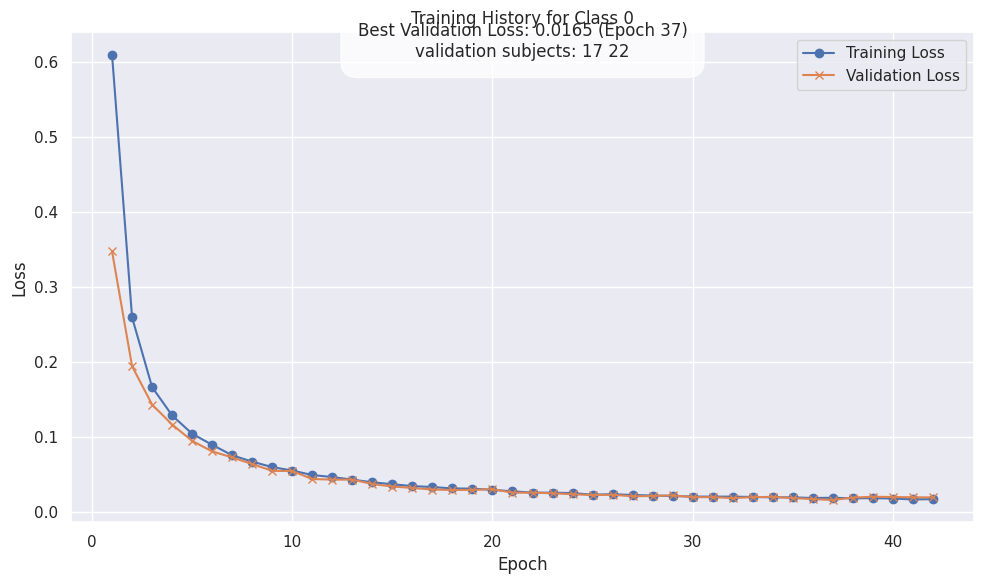

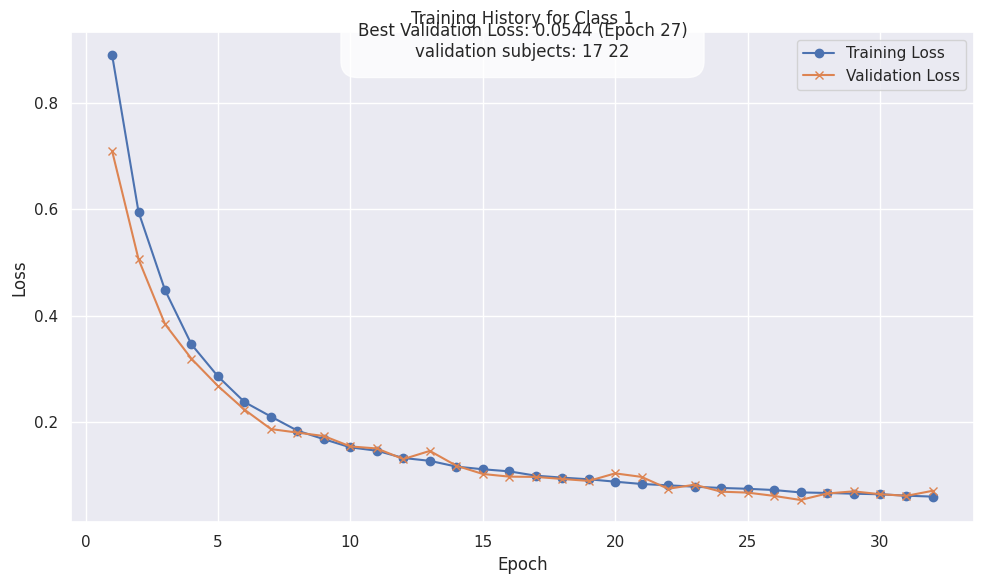

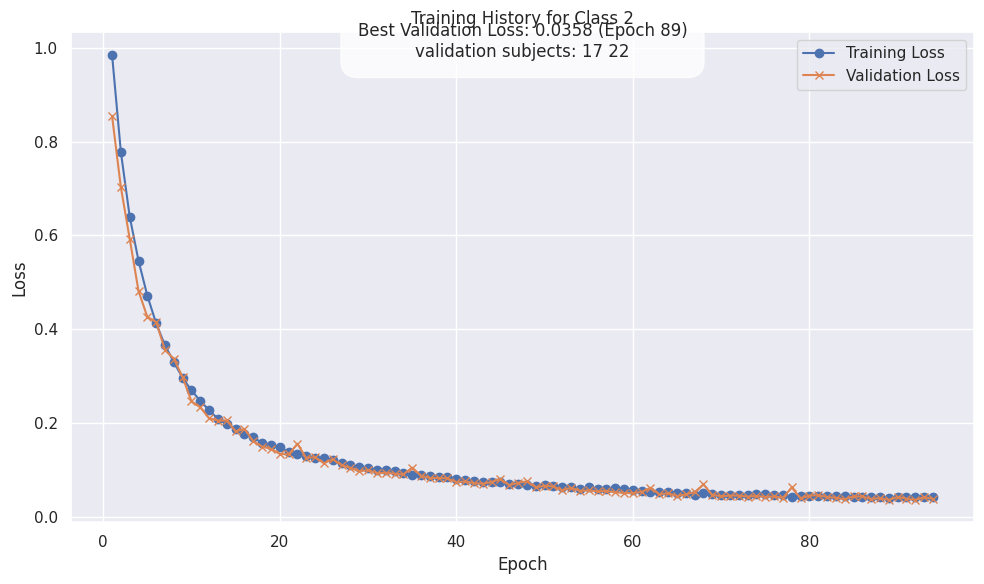

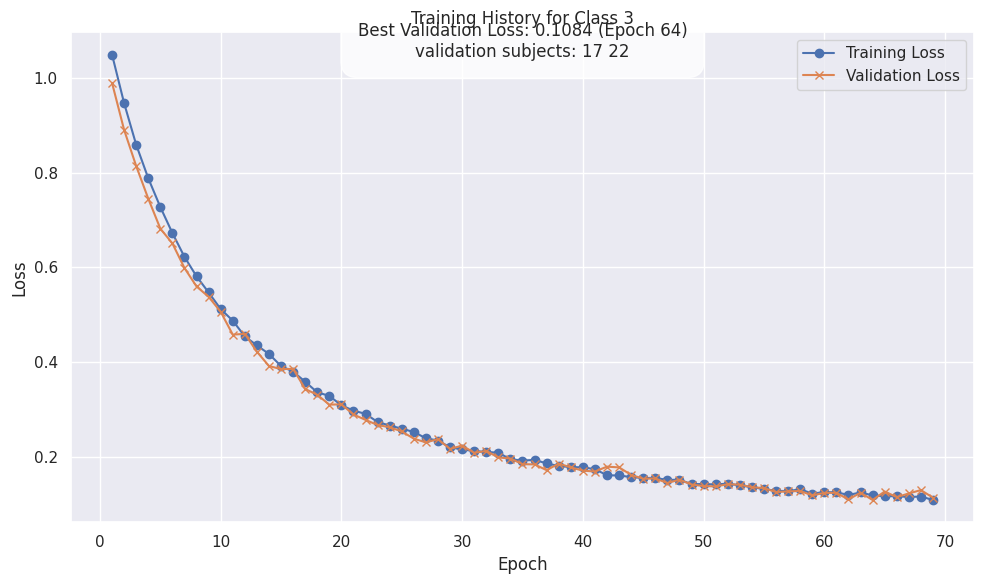

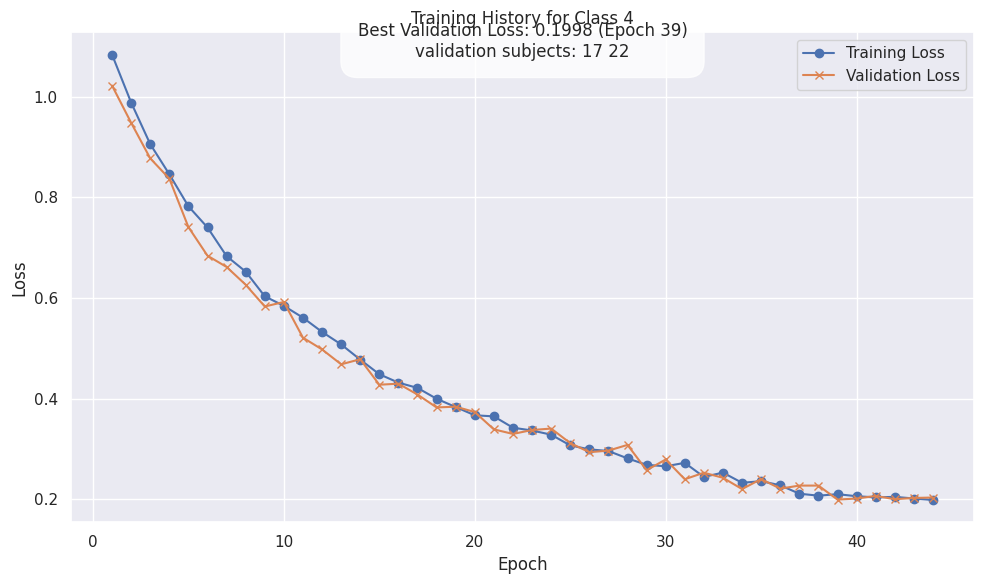

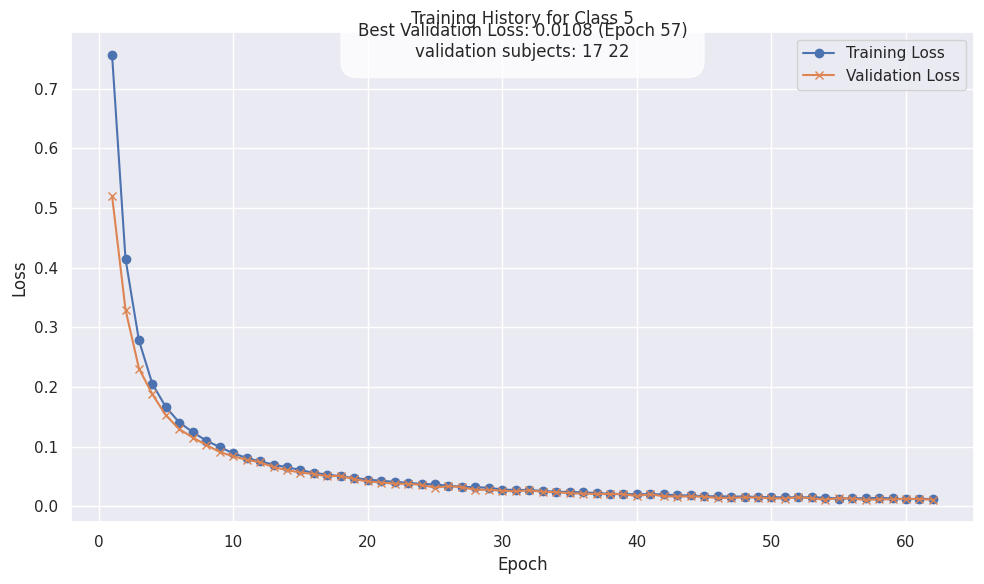

No history file found for 6 at /content/gdrive/MyDrive/Ambient_Intelligence_Project/padding/diffusion_models/training_history_class_6.csv


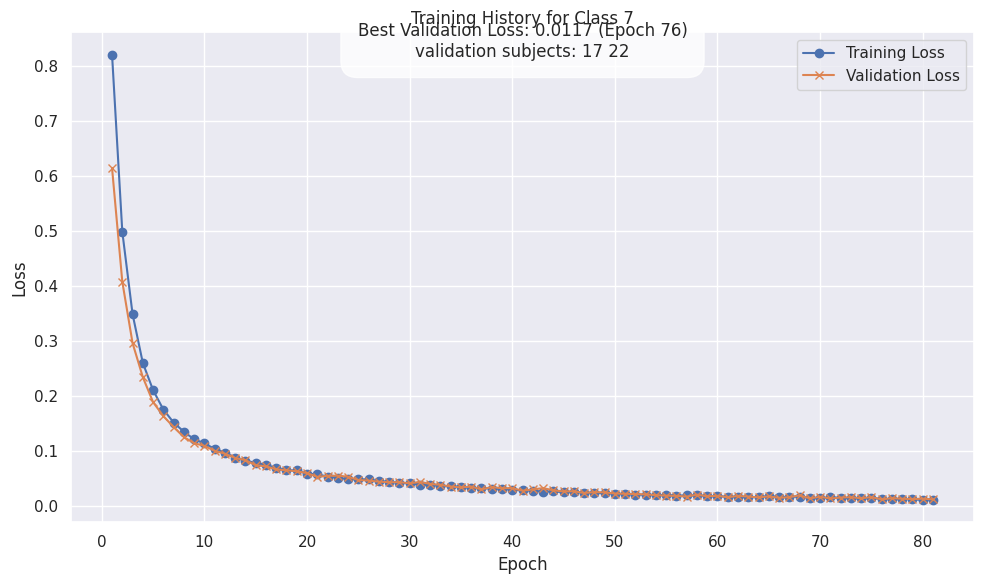

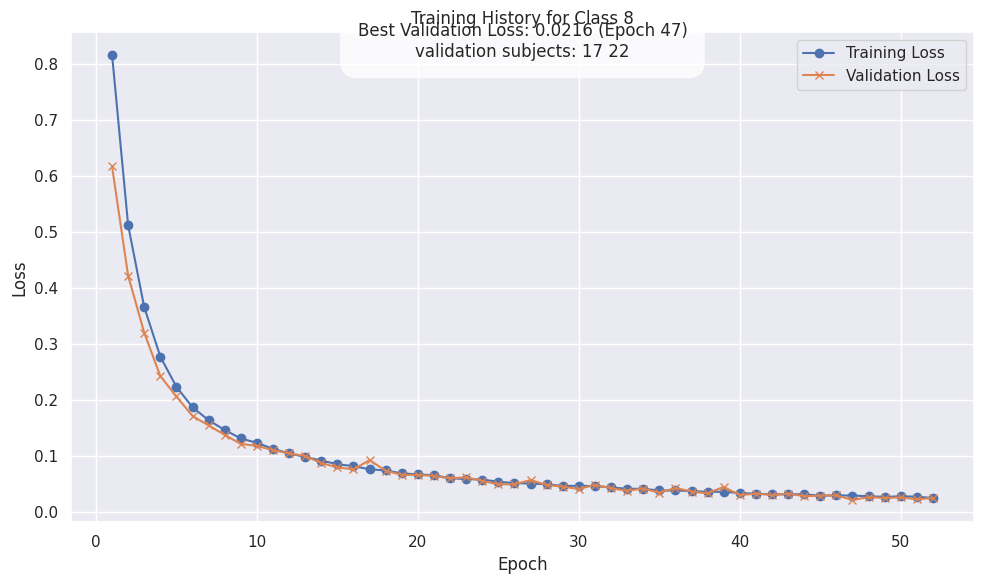

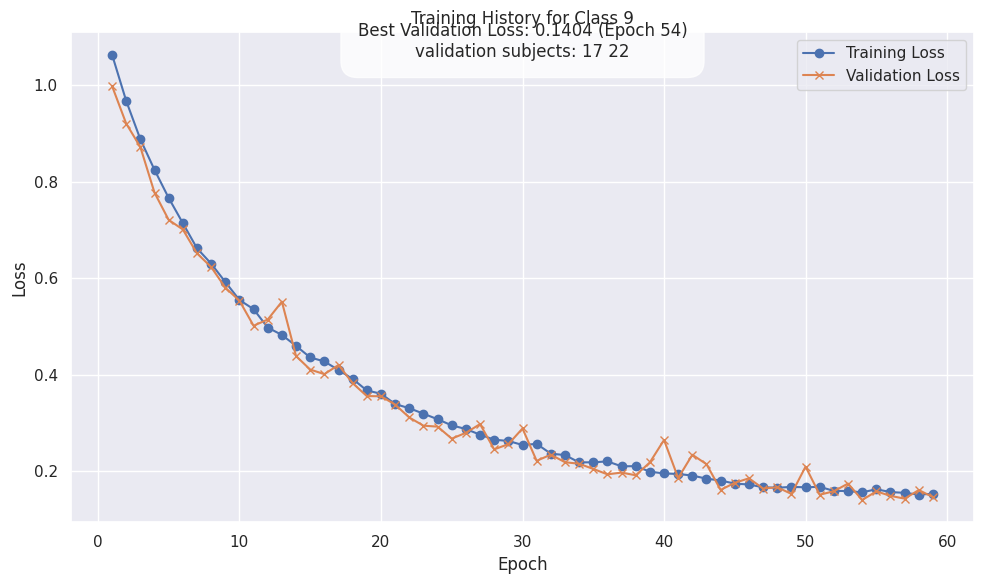

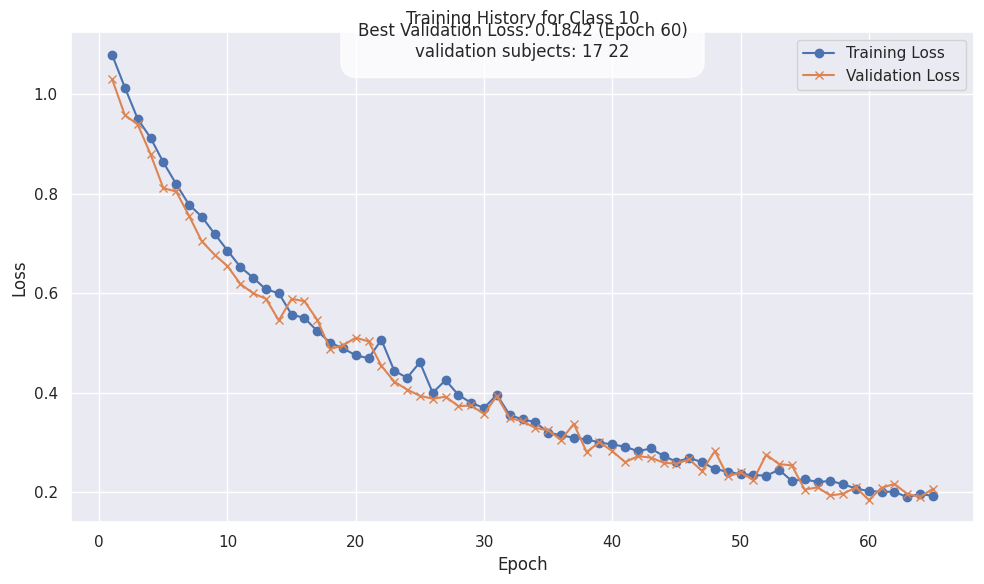

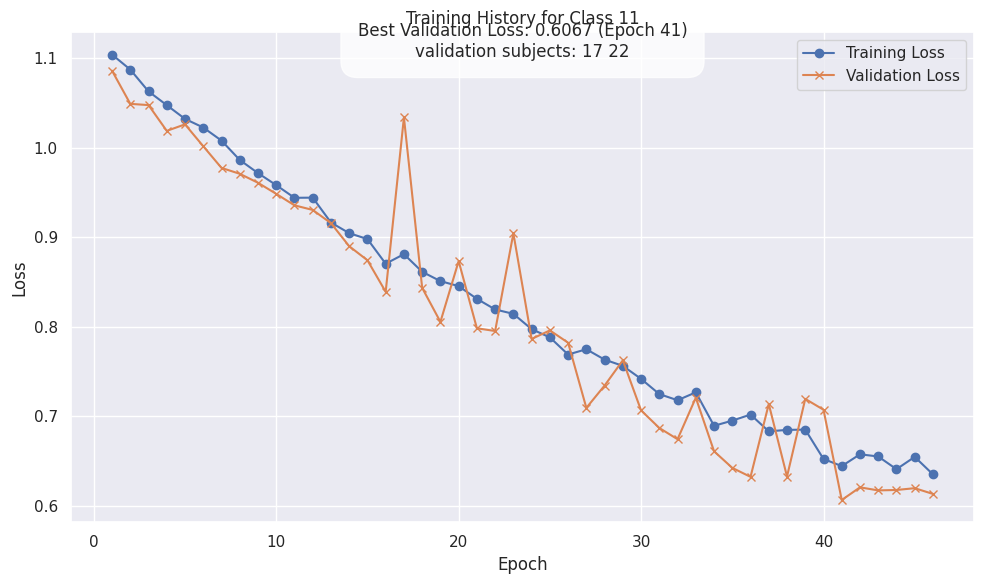

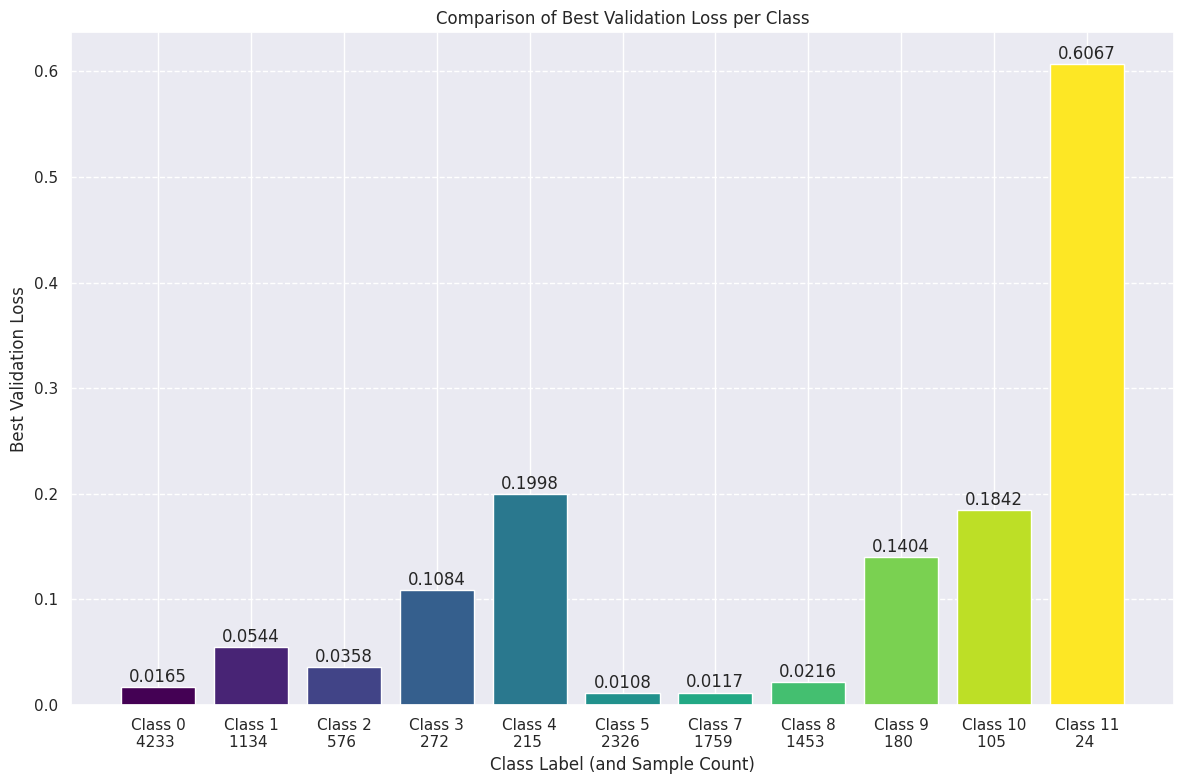


 
 
 
 
 ------ Diffusion Model upsample ------ 
 
 
 
 

[5 5 5 ... 0 0 0]


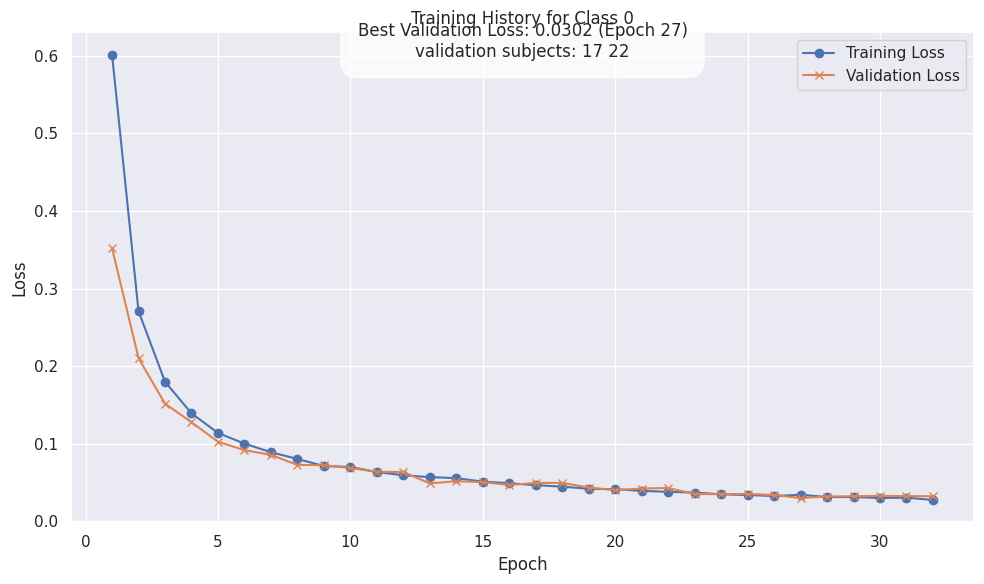

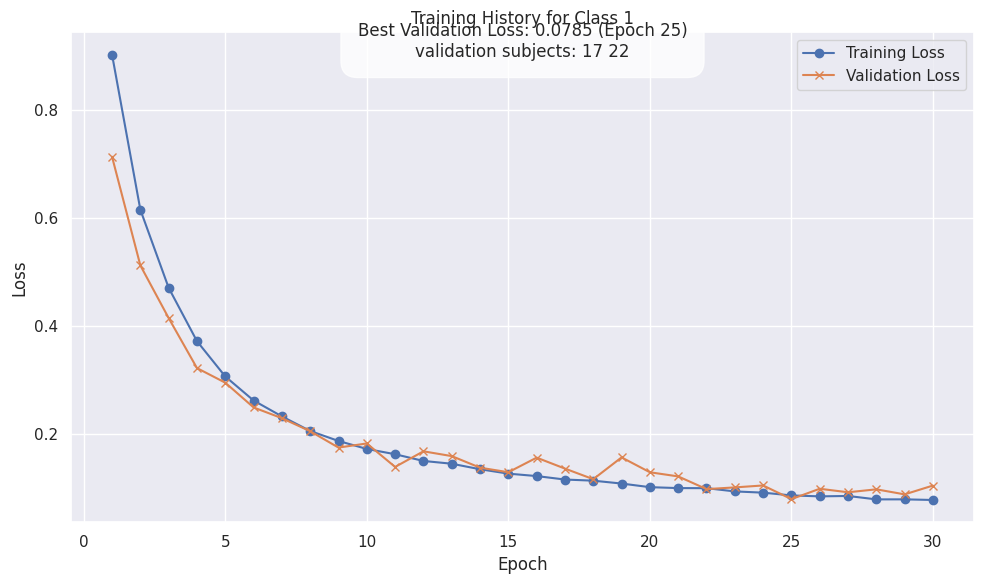

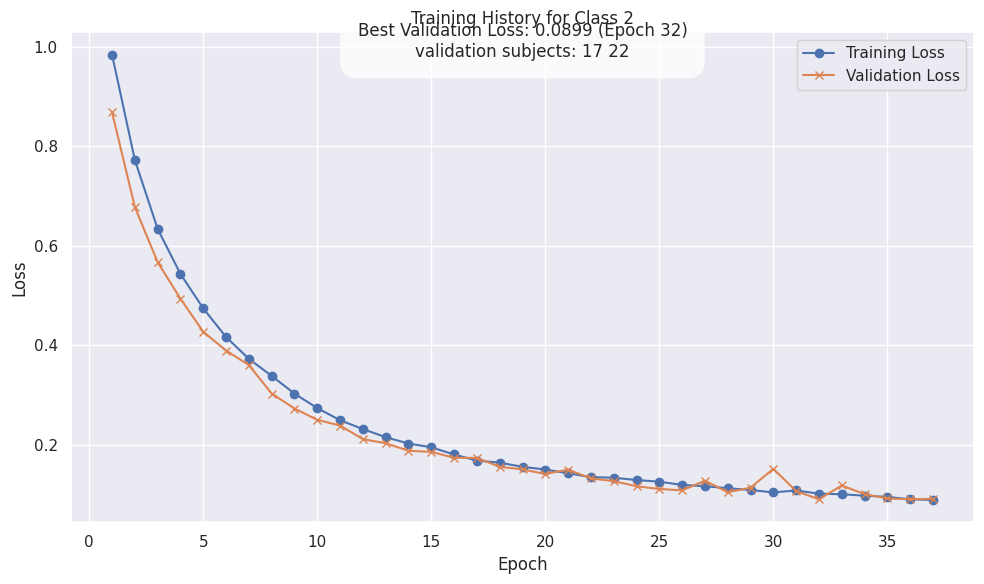

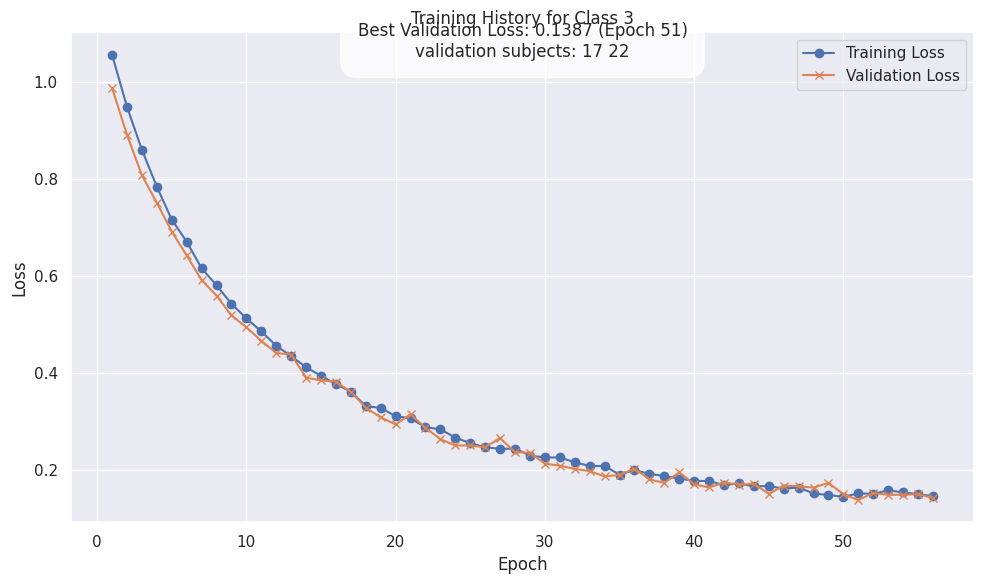

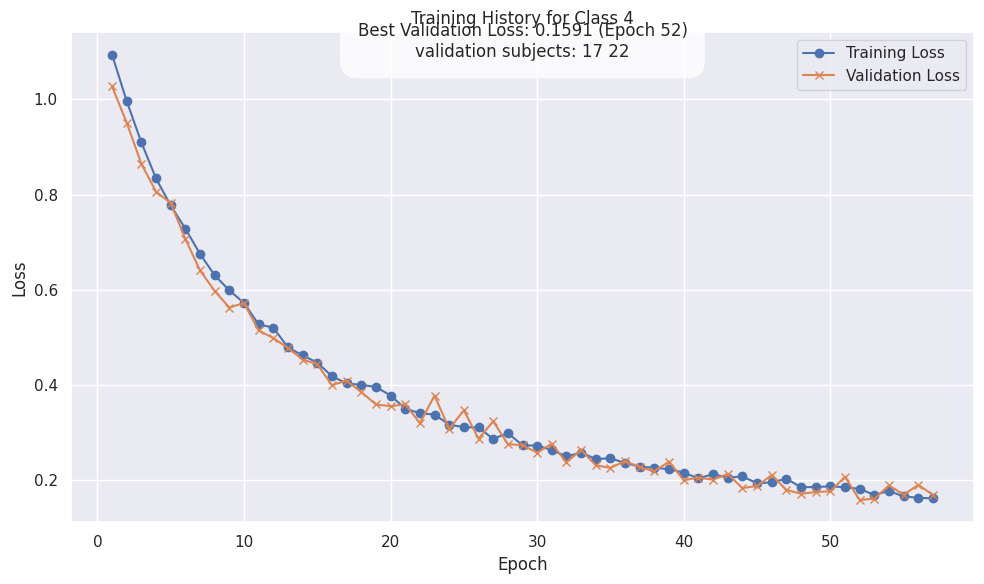

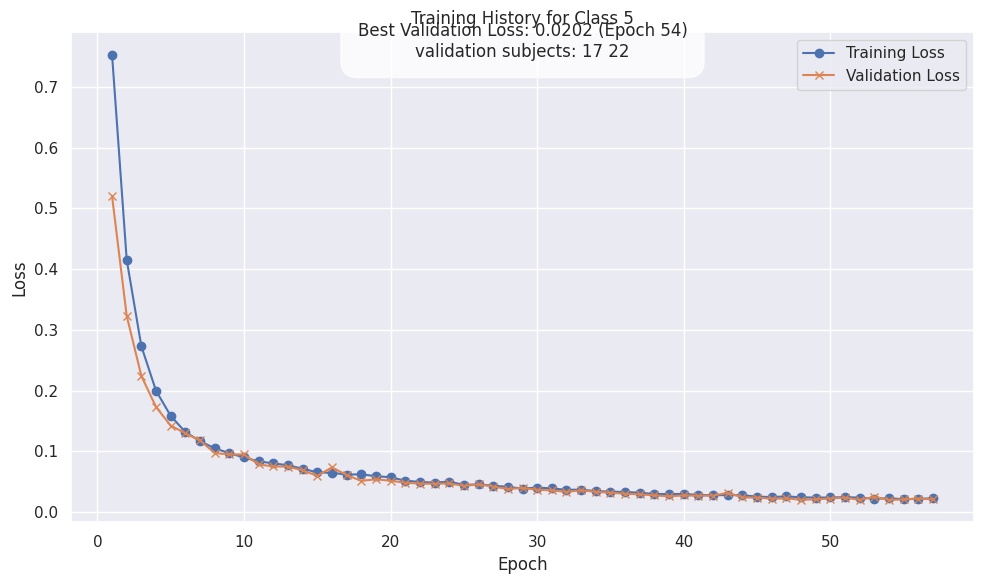

No history file found for 6 at /content/gdrive/MyDrive/Ambient_Intelligence_Project/upsample/diffusion_models/training_history_class_6.csv


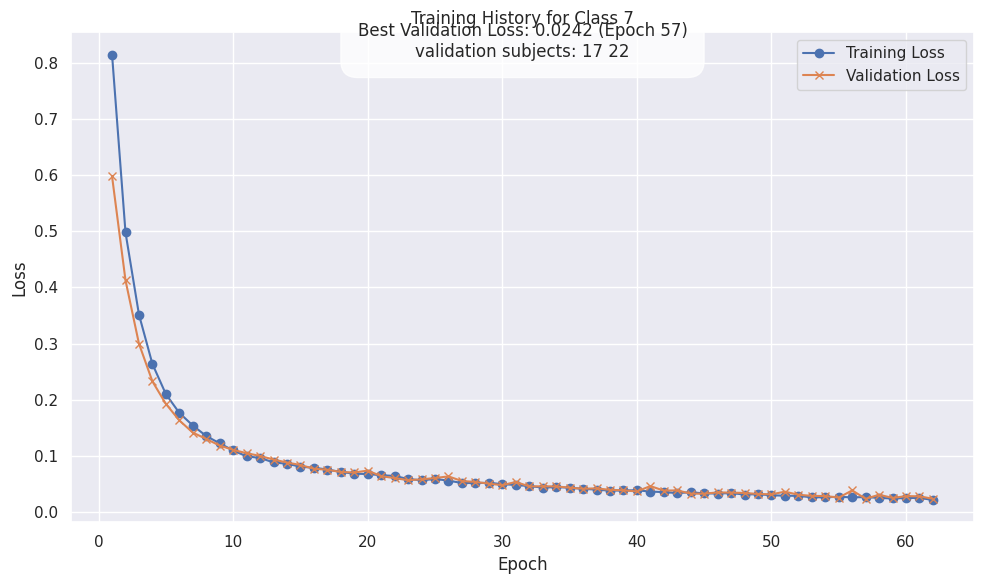

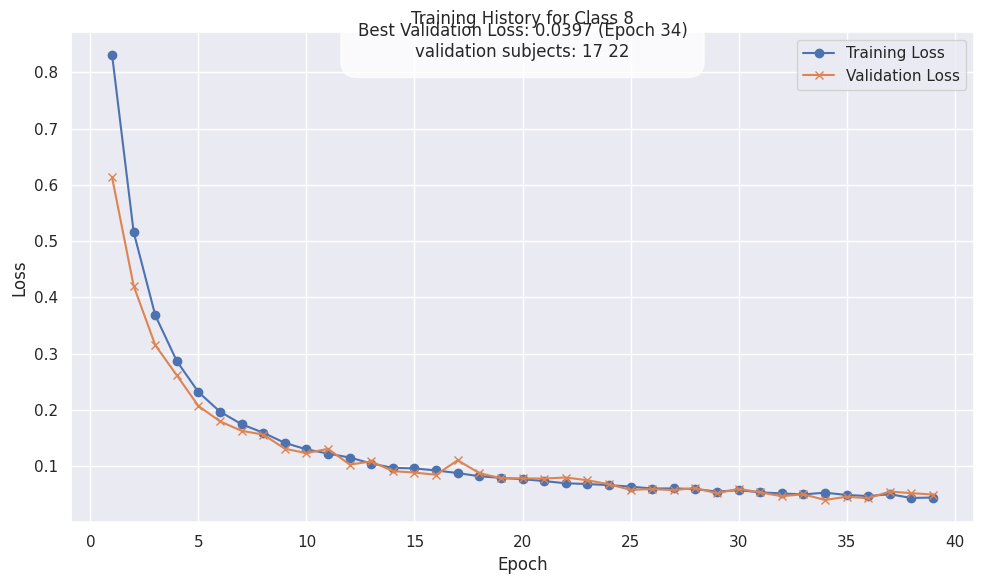

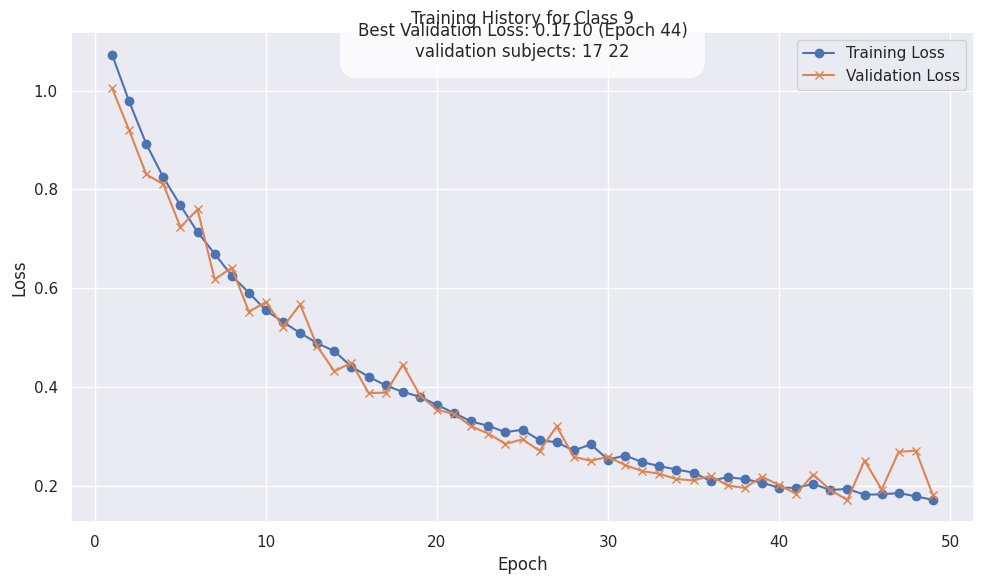

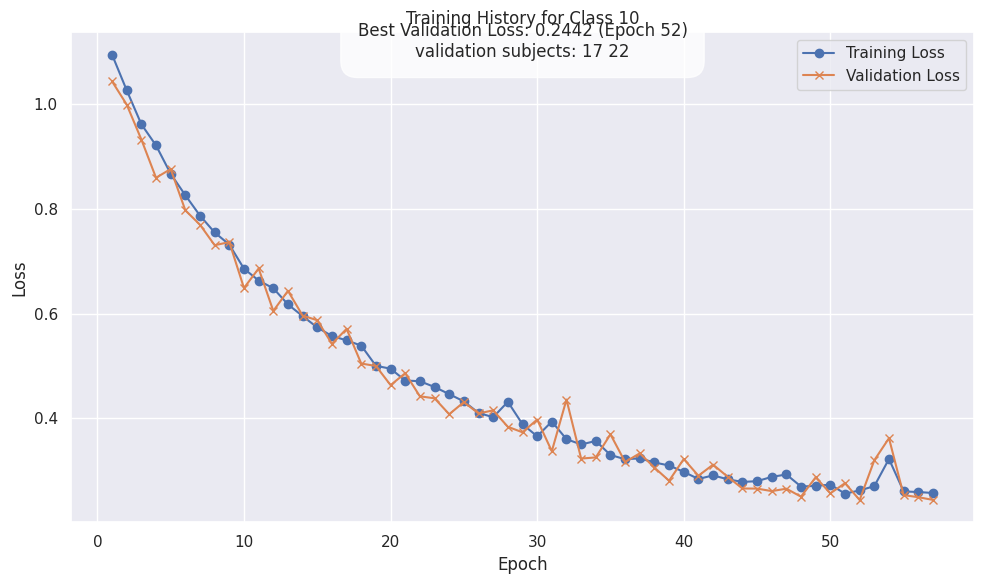

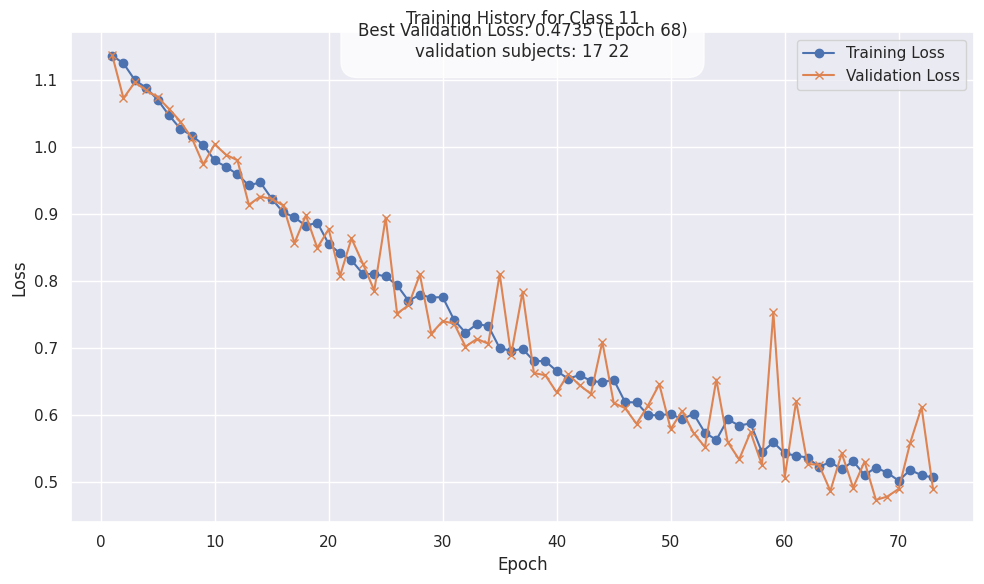

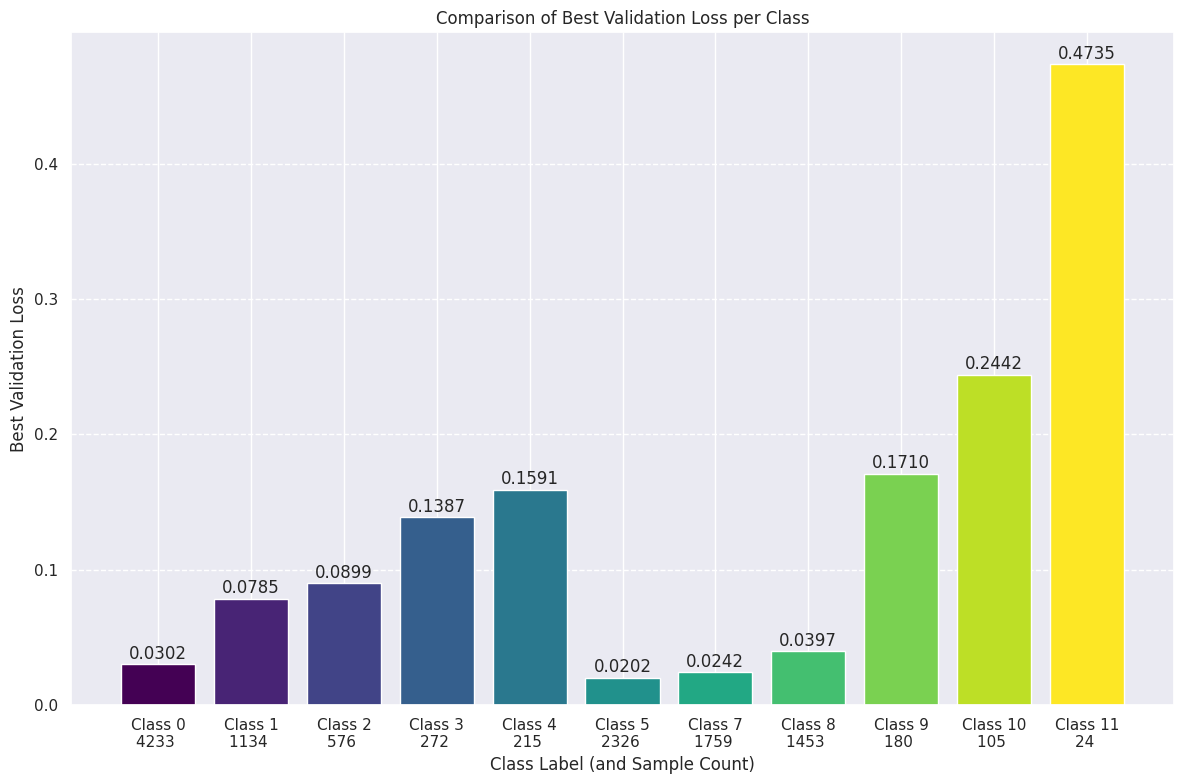

In [ ]:
for temp in ridimension_cycle:
  if verbose == True:
    temp_path = f"/content/gdrive/MyDrive/Diffusion_Model_Project/{temp}"
    models_dir_temp = os.path.join(temp_path, "diffusion_models")


    print(f"\n \n \n \n \n ------ Diffusion Model {temp} ------ \n \n \n \n \n")
    unique_classes = np.unique(labels)
    class_counts = Counter(labels)
    print(labels)

    best_losses_data = []

    # for each class load the history

    for class_label in unique_classes:
        history_path = os.path.join(models_dir_temp , f"training_history_class_{class_label}.csv")

        if not os.path.exists(history_path):
            print(f"No history file found for {class_label} at {history_path}")
            continue


        try:
            history_df = pd.read_csv(history_path)
        except pd.errors.EmptyDataError:
            print(f"History file for {class_label} is empty")
            continue

        # check that the validation subject are alaways the same
        validation_subject_1 = history_df['validation_subject 1'].iloc[0]
        validation_subject_2 = history_df['validation_subject 2'].iloc[0]

        # find the best validation loss
        best_val_loss = history_df['val_loss'].min()
        best_epoch = history_df.loc[history_df['val_loss'].idxmin()]['epoch']

        # appemd the value to a list
        best_losses_data.append({
            'class': class_label,
            'best_val_loss': best_val_loss,
            'count': class_counts.get(class_label, 0)
        })

        # plot of the train and val loss
        plt.figure(figsize=(10, 6))
        plt.plot(history_df['epoch'], history_df['train_loss'], label='Training Loss', marker='o')
        plt.plot(history_df['epoch'], history_df['val_loss'], label='Validation Loss', marker='x')

        plt.title(f'Training History for Class {class_label}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        plt.text(
            0.5, 0.95,
            f"Best Validation Loss: {best_val_loss:.4f} (Epoch {int(best_epoch)})\n"
            f"validation subjects: {validation_subject_1} {validation_subject_2}",
            transform=plt.gca().transAxes,
            ha='center',
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=1.0')
        )

        plt.show()

    # plot the histogram of the best val losses for each class
    if best_losses_data:
        final_df = pd.DataFrame(best_losses_data)
        final_df = final_df.sort_values(by='class', ascending=True)

        x_labels = [f"Class {c}\n{n} " for c, n in zip(final_df['class'], final_df['count'])]

        plt.figure(figsize=(12, 8))
        bars = plt.bar(
            x_labels,
            final_df['best_val_loss'],
            color=plt.cm.viridis(np.linspace(0, 1, len(final_df)))
        )
        plt.title('Comparison of Best Validation Loss per Class')
        plt.xlabel('Class Label (and Sample Count)')
        plt.ylabel('Best Validation Loss')
        plt.grid(axis='y', linestyle='--')
        plt.tight_layout()

        for bar in bars:
            yval = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width()/2,
                yval + 0.001,
                f'{yval:.4f}',
                ha='center',
                va='bottom'
            )

        plt.show()
    else:
        print("Warning: error while constructing the loss comparison plot")


Plot the training and validation for the finetuned class models and the histgram with the best loss


 
 
 
 
 ------ Finetuned Diffusion Model padding ------ 
 
 
 
 



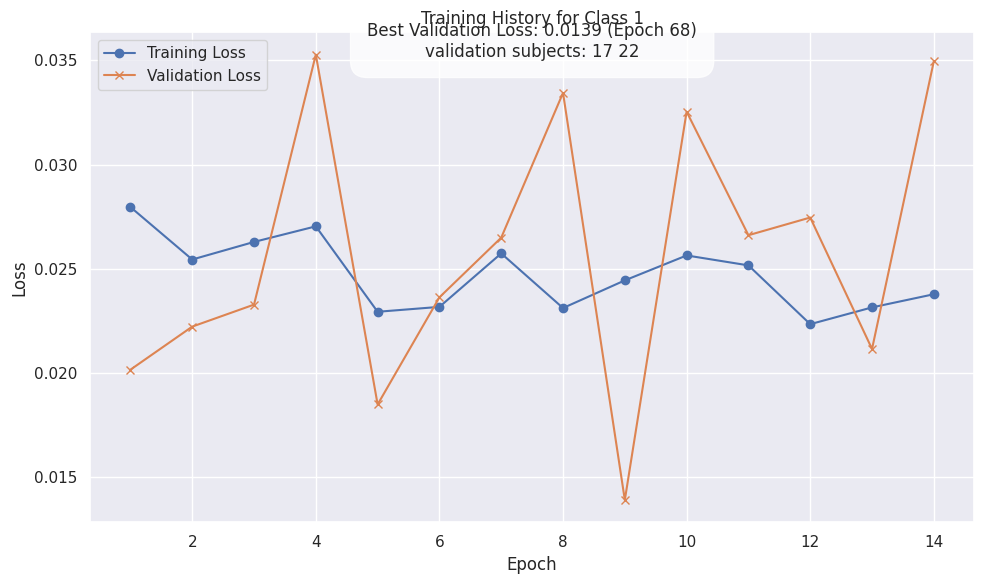

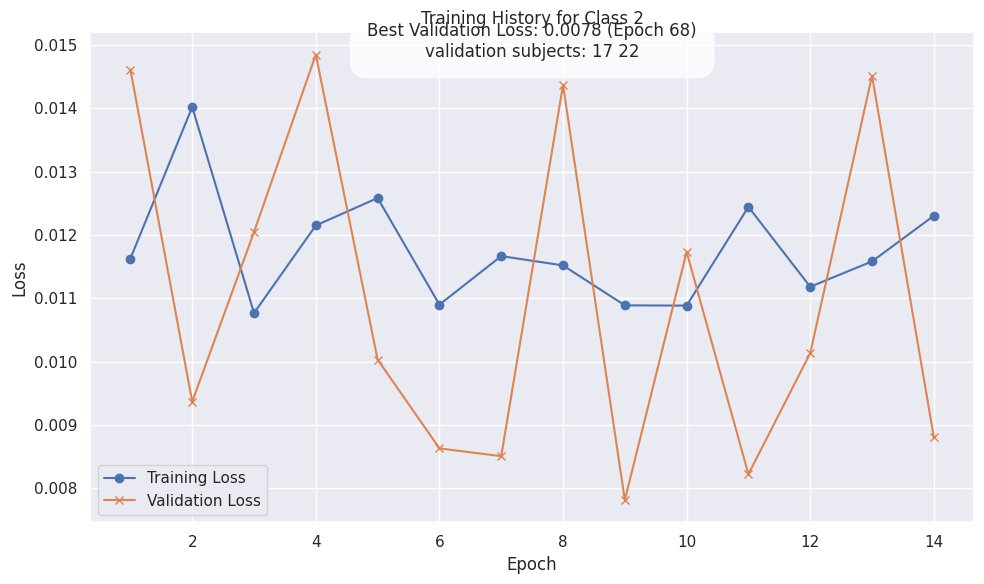

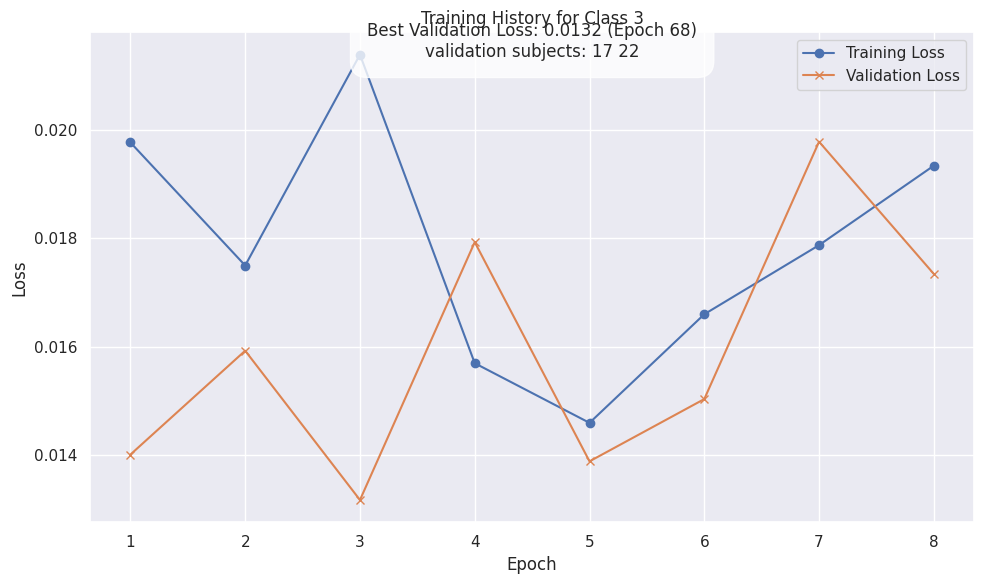

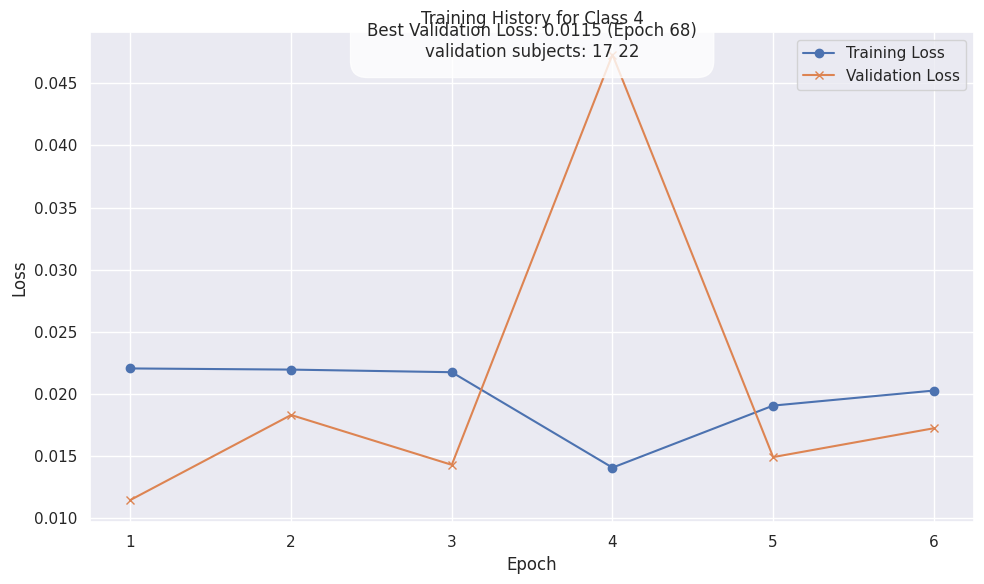

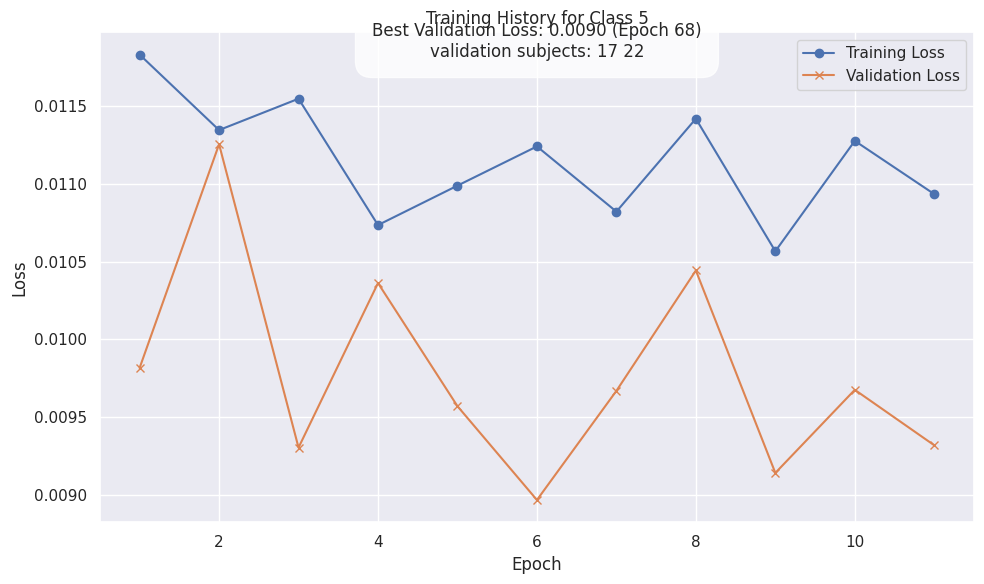

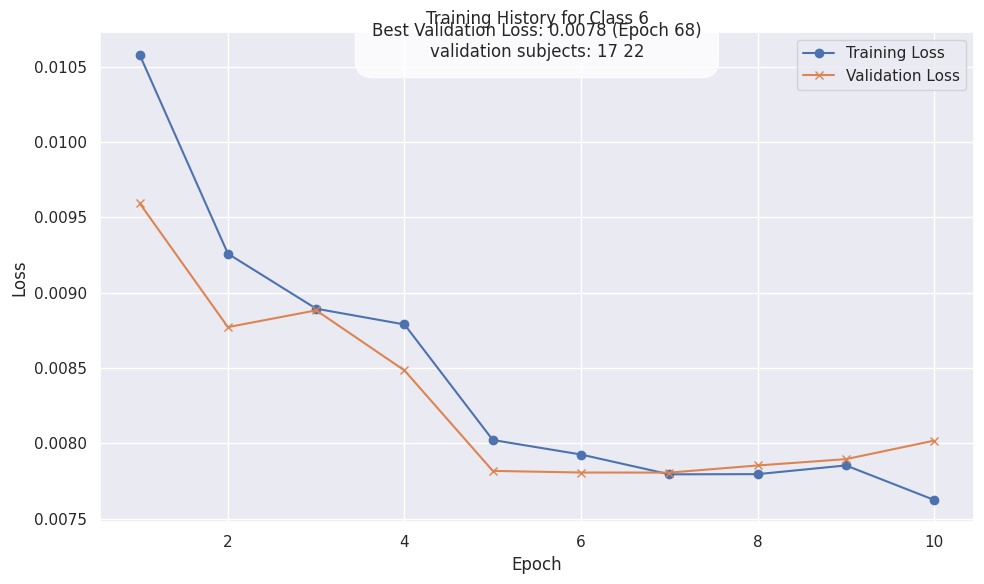

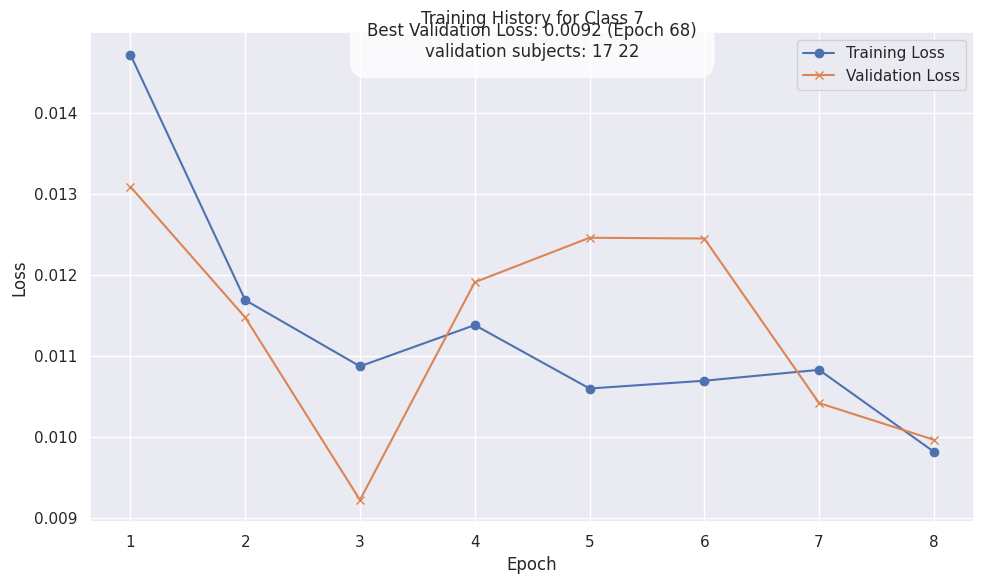

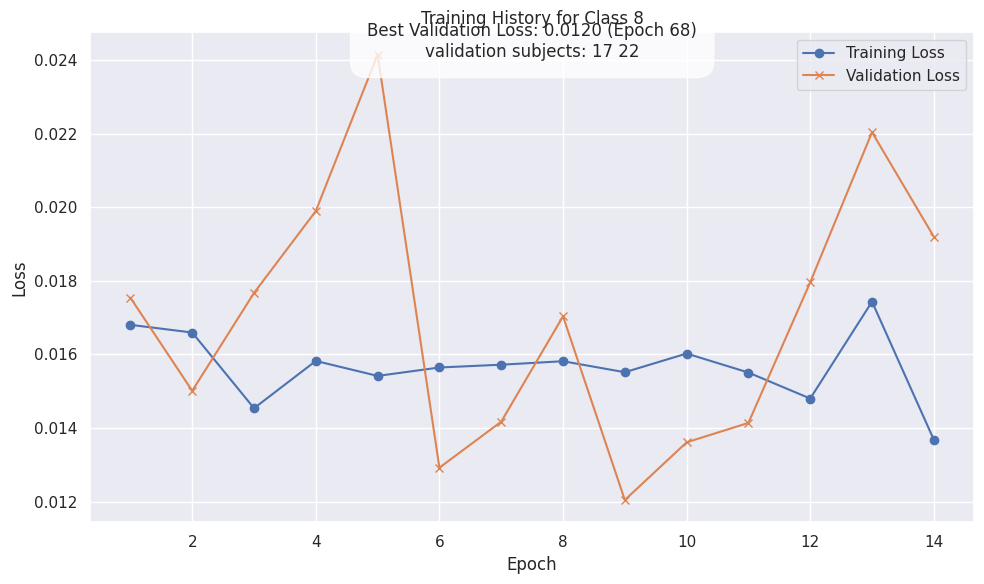

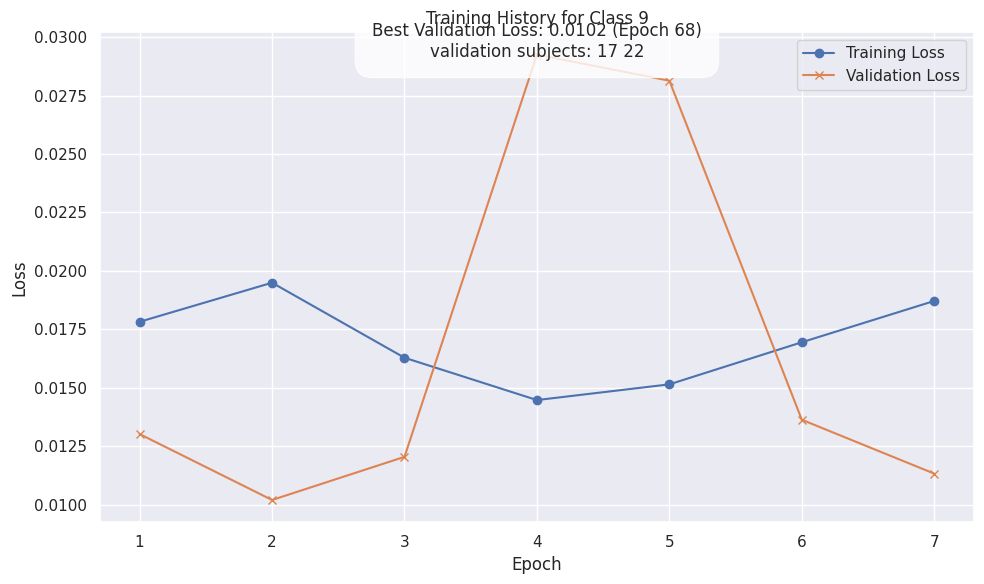

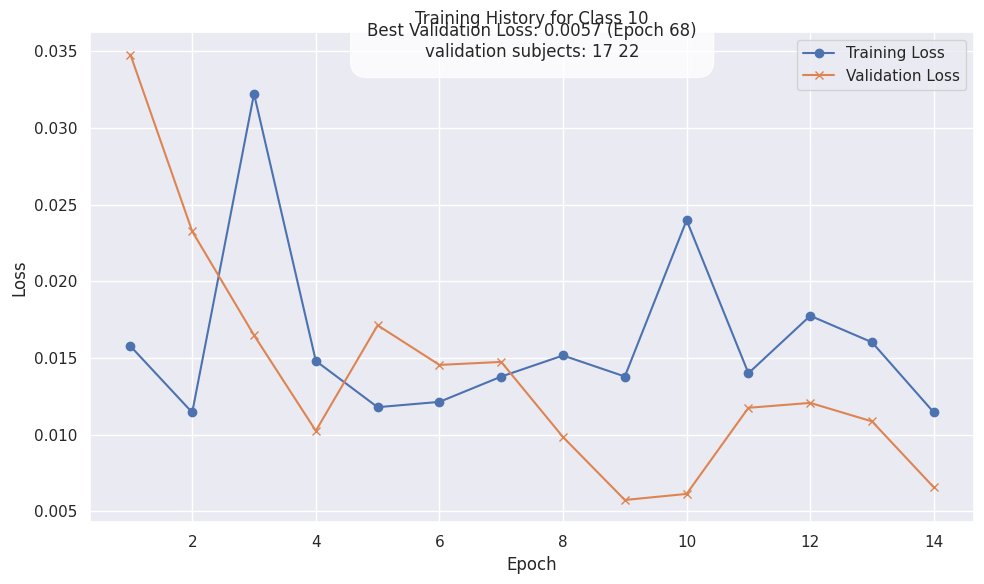

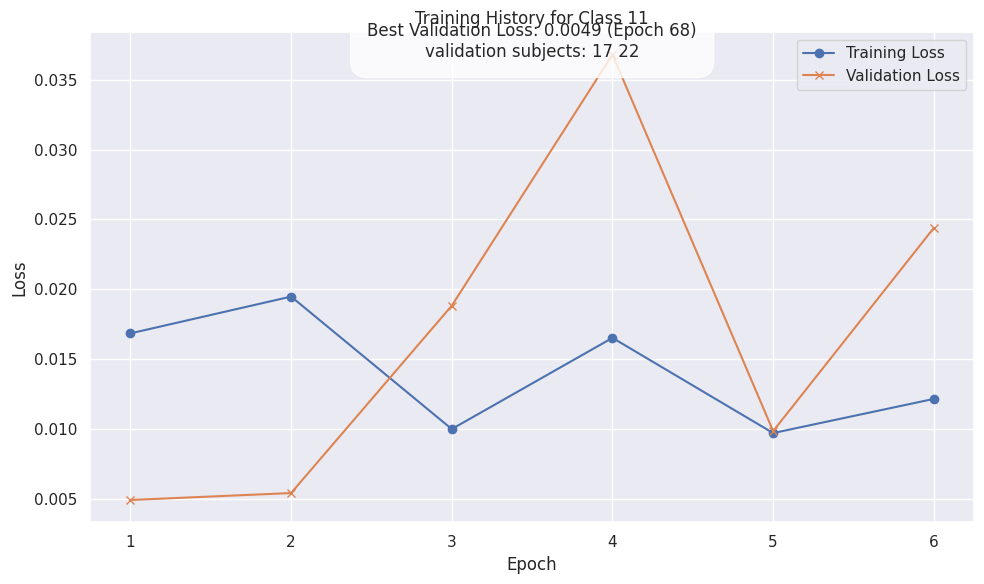

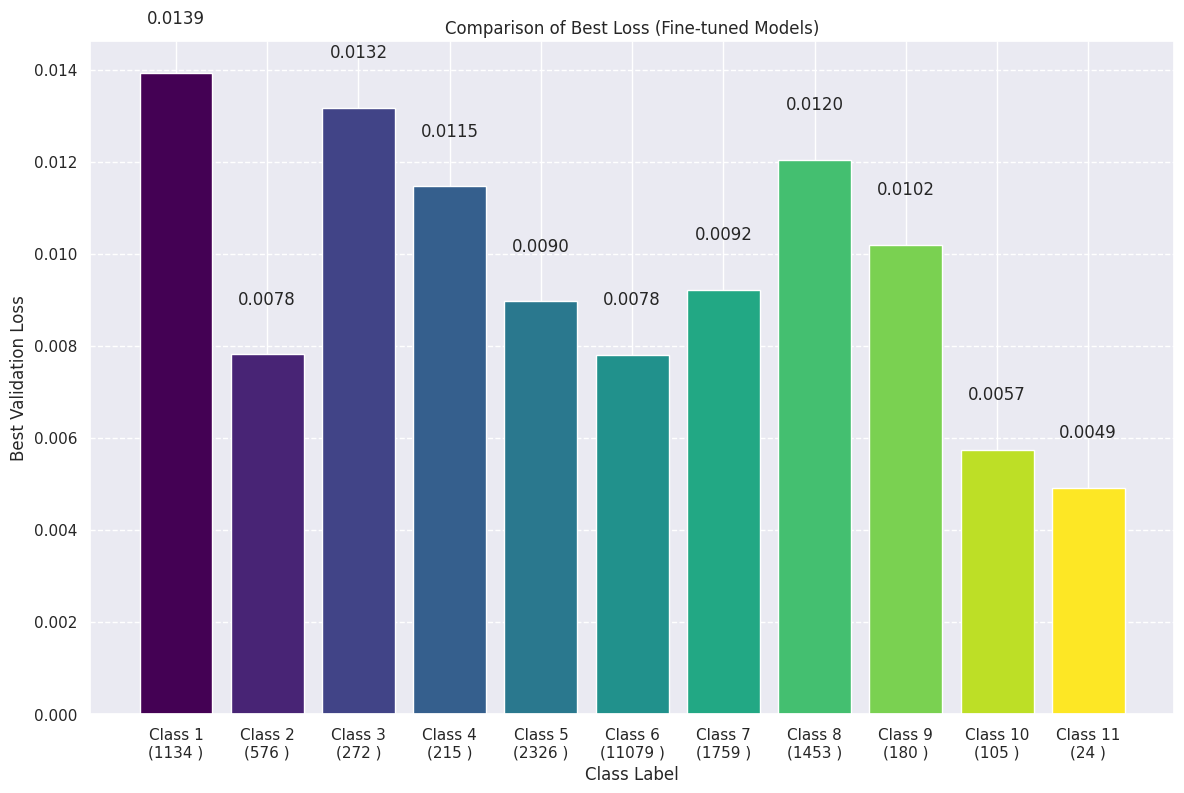


 
 
 
 
 ------ Finetuned Diffusion Model upsample ------ 
 
 
 
 



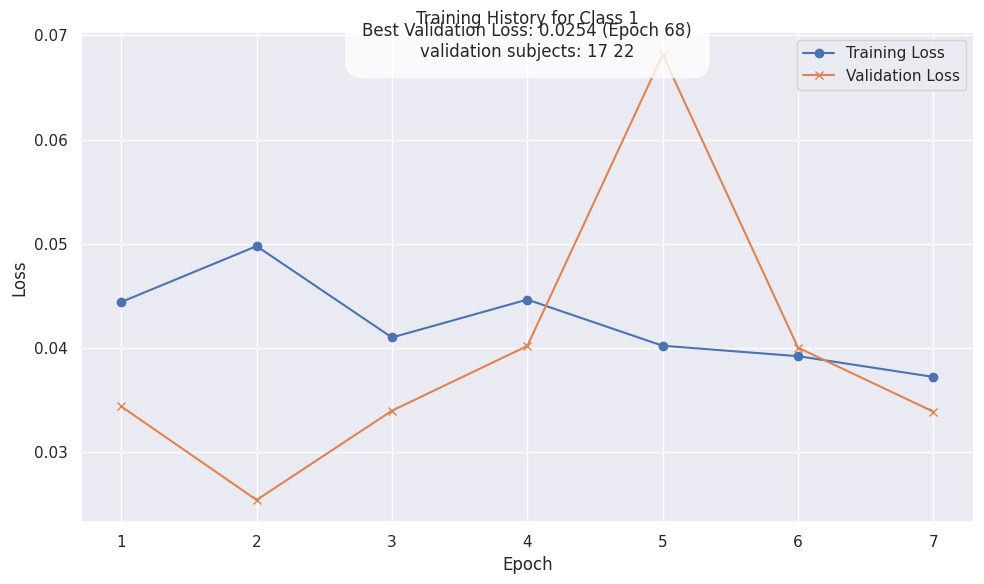

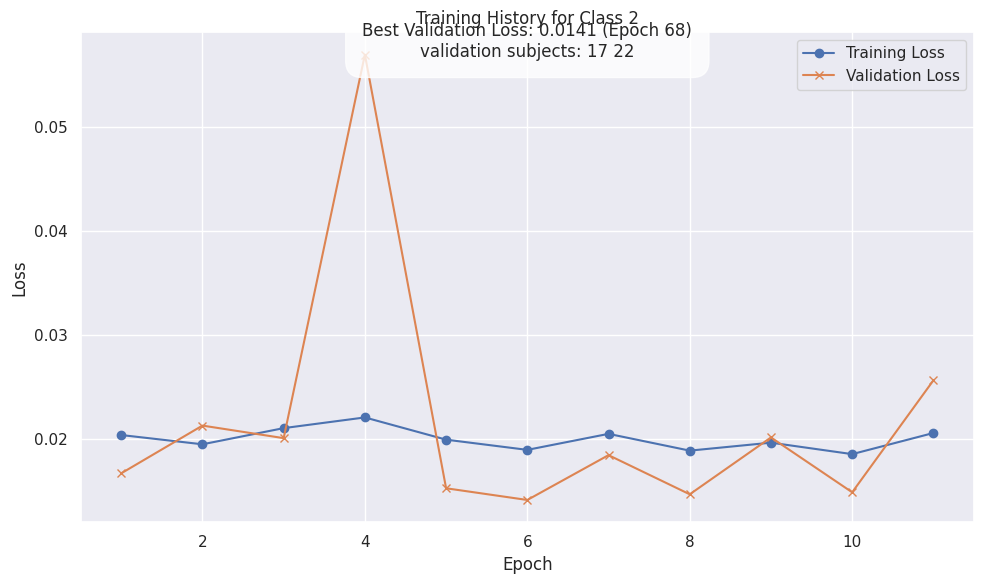

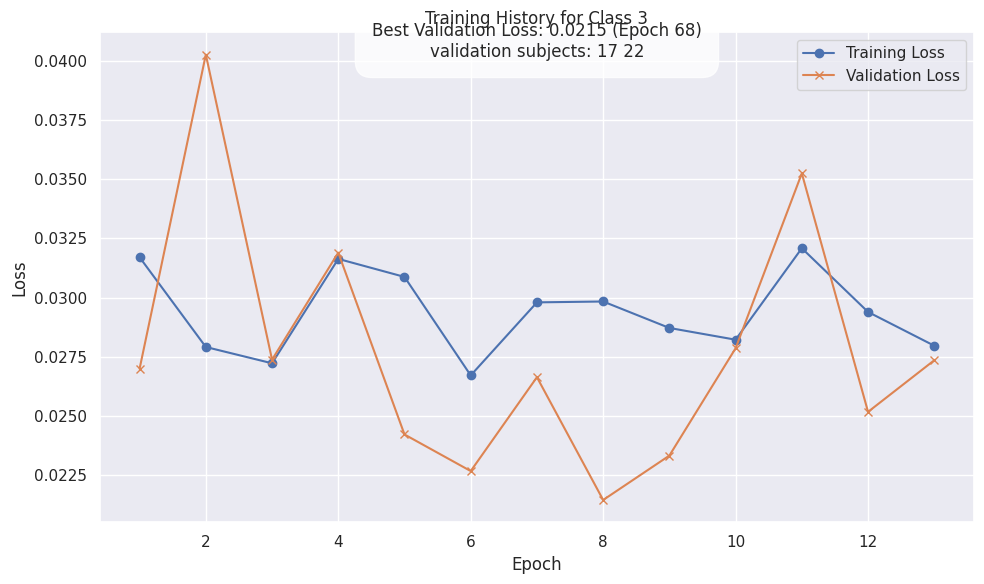

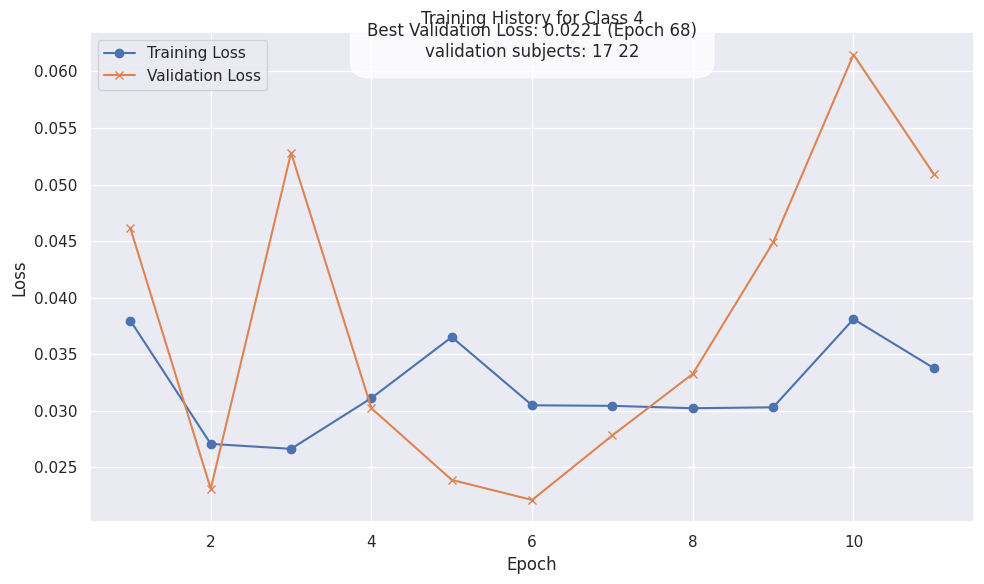

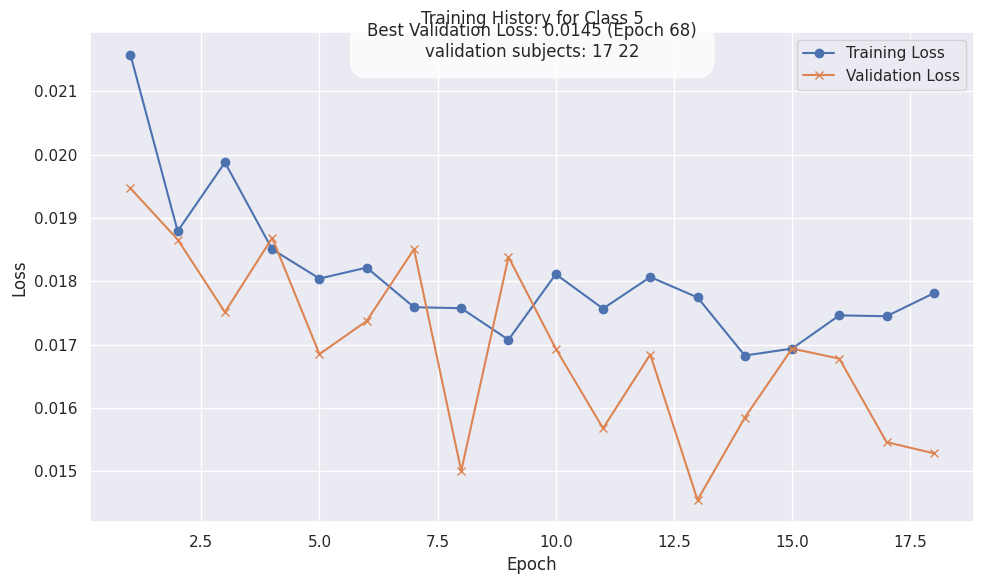

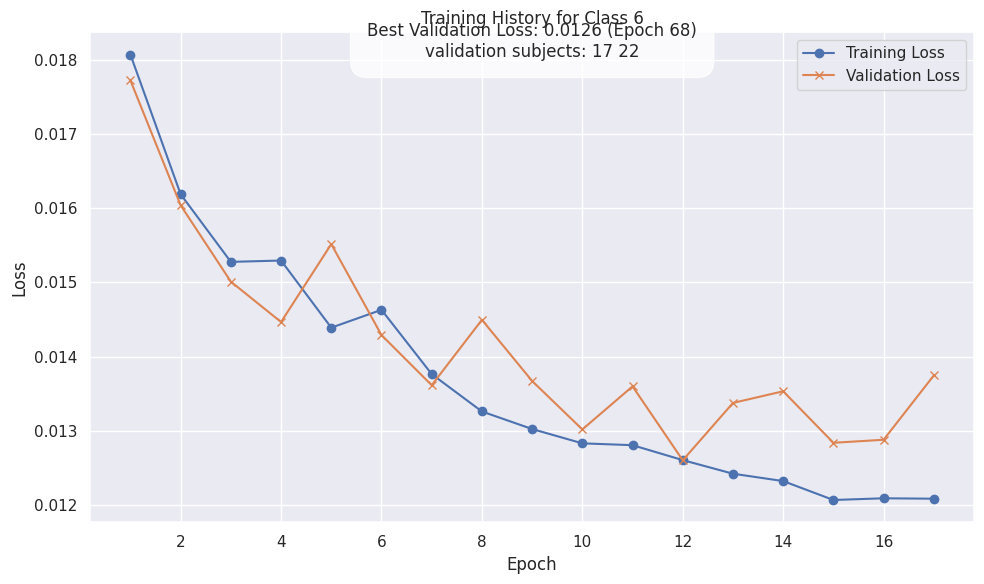

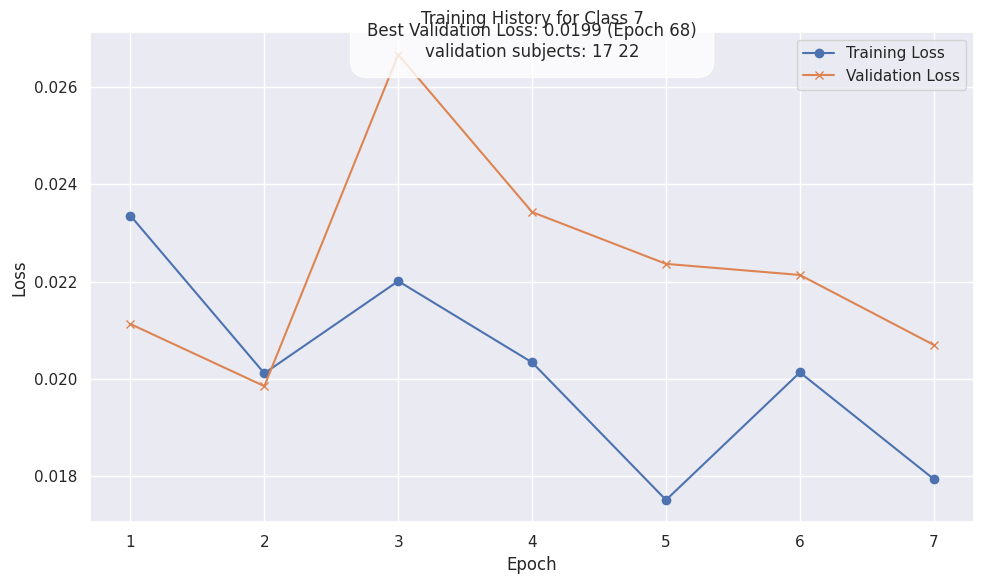

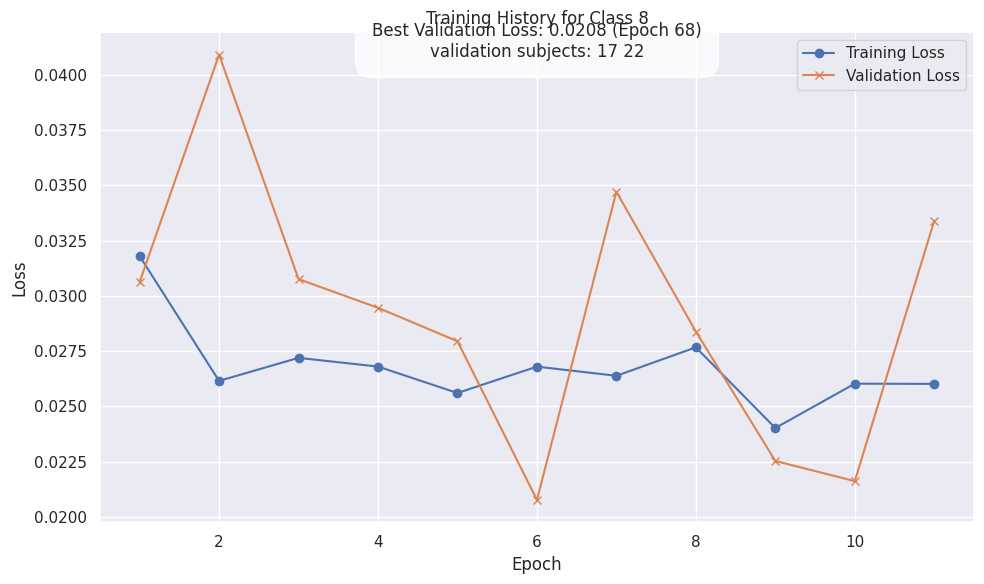

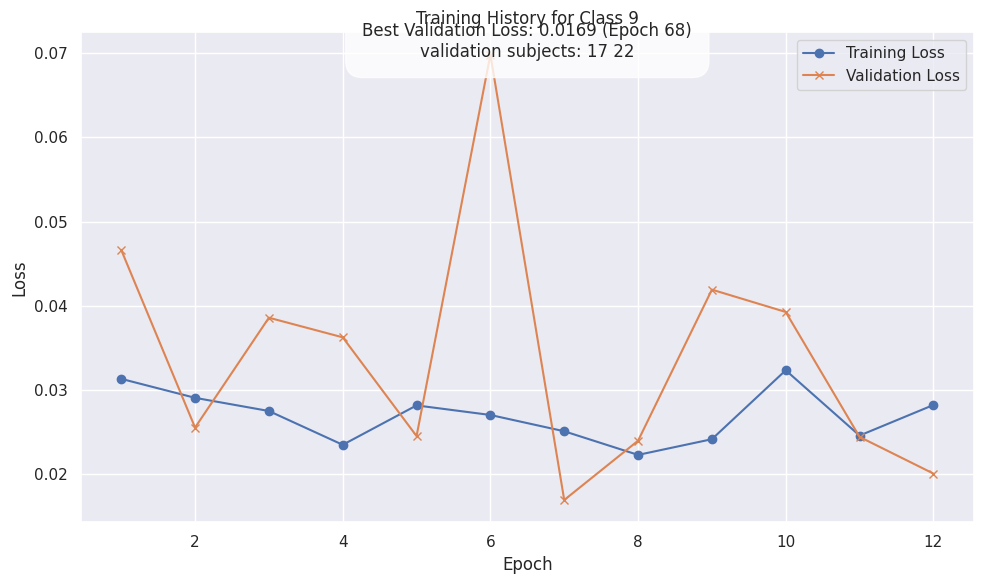

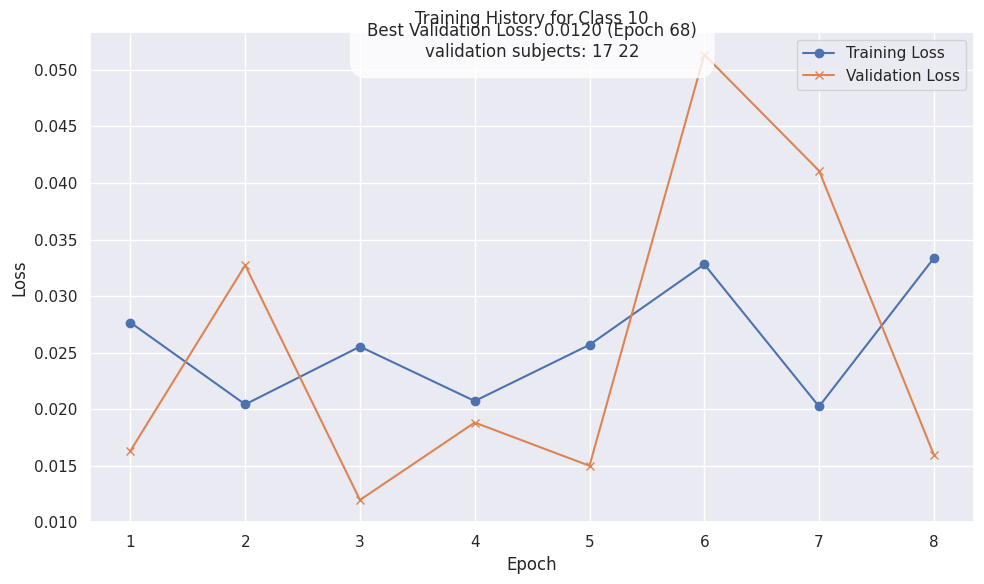

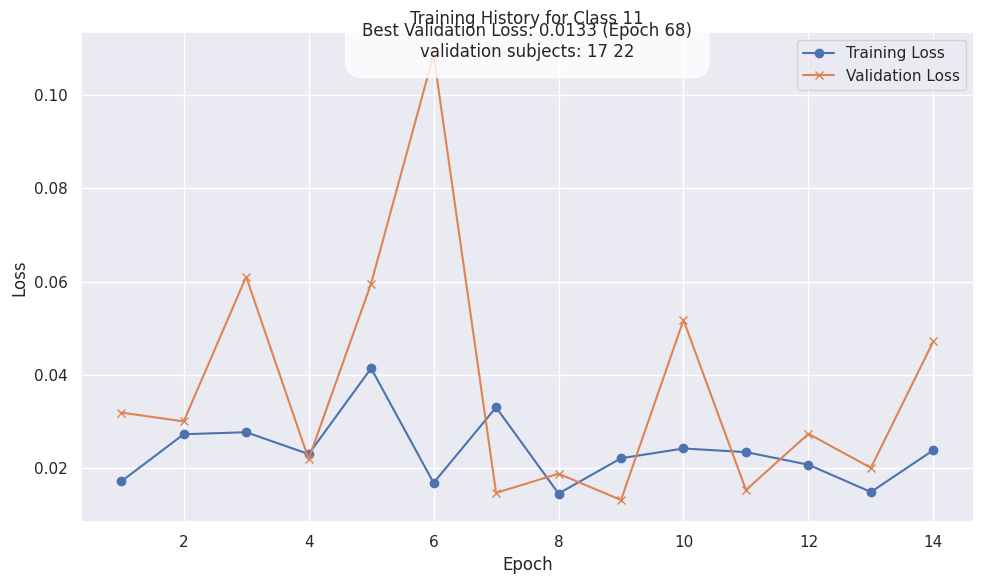

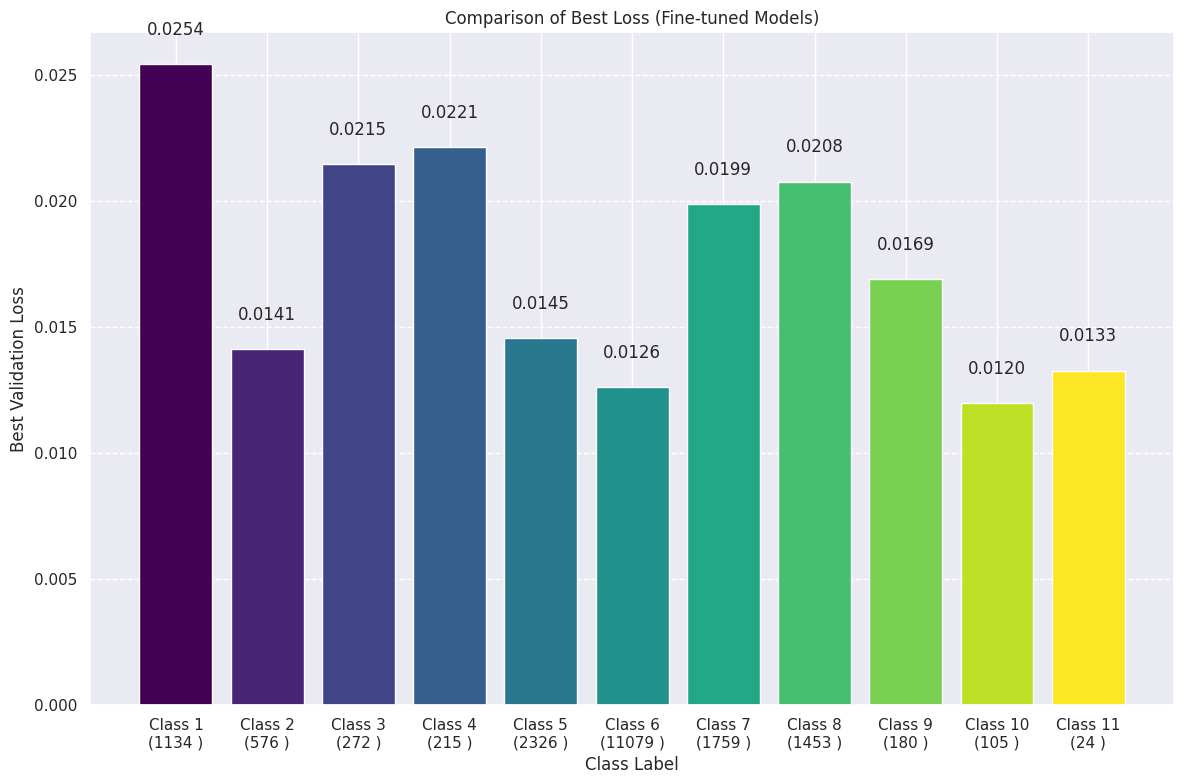

In [ ]:

for temp in ridimension_cycle:
  if verbose == True:
      temp_path = f"/content/gdrive/MyDrive/Diffusion_Model_Project/{temp}"
      models_dir_temp = os.path.join(temp_path, "diffusion_models")
      print(f"\n \n \n \n \n ------ Finetuned Diffusion Model {temp} ------ \n \n \n \n \n")


      unique_classes = sorted(np.unique(labels))
      class_counts = Counter(labels)
      base_class = 0

      best_losses_data = []

      for class_label in unique_classes:

          if class_label == base_class:
              continue

          history_path = os.path.join(models_dir_temp, f"finetune_history_class_{class_label}.csv")

          if not os.path.exists(history_path):
              print(f"No fine-tuning history file found for class {class_label}. Skipping.")
              continue

          try:
              history_df = pd.read_csv(history_path)
          except pd.errors.EmptyDataError:
              print(f"History file for class {class_label} is empty. Skipping.")
              continue

          if 'val_loss' in history_df.columns:
              best_val_loss = history_df['val_loss'].min()

              best_losses_data.append({
                  'class': class_label,
                  'best_val_loss': best_val_loss,
                  'count': class_counts.get(class_label, 0)
              })

          else:
              print(f"History file for class {class_label} has problems")

          # plot of the train and val loss
          plt.figure(figsize=(10, 6))
          plt.plot(history_df['epoch'], history_df['train_loss'], label='Training Loss', marker='o')
          plt.plot(history_df['epoch'], history_df['val_loss'], label='Validation Loss', marker='x')

          plt.title(f'Training History for Class {class_label}')
          plt.xlabel('Epoch')
          plt.ylabel('Loss')
          plt.legend()
          plt.grid(True)
          plt.tight_layout()

          plt.text(
              0.5, 0.95,
              f"Best Validation Loss: {best_val_loss:.4f} (Epoch {int(best_epoch)})\n"
              f"validation subjects: {validation_subject_1} {validation_subject_2}",
              transform=plt.gca().transAxes,
              ha='center',
              fontsize=12,
              bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=1.0')
          )

          plt.show()


      if best_losses_data:
          final_df = pd.DataFrame(best_losses_data)
          final_df = final_df.sort_values(by='class', ascending=True)

          x_labels = [f"Class {c}\n({n} )" for c, n in zip(final_df['class'], final_df['count'])]

          plt.figure(figsize=(12, 8))
          bars = plt.bar(
              x_labels,
              final_df['best_val_loss'],
              color=plt.cm.viridis(np.linspace(0, 1, len(final_df)))
          )
          plt.title('Comparison of Best Loss (Fine-tuned Models)')
          plt.xlabel('Class Label')
          plt.ylabel('Best Validation Loss')
          plt.grid(axis='y', linestyle='--')
          plt.tight_layout()

          for bar in bars:
              yval = bar.get_height()
              plt.text(
                  bar.get_x() + bar.get_width()/2,
                  yval + 0.001,
                  f'{yval:.4f}',
                  ha='center',
                  va='bottom'
              )
          plt.show()
      else:
          print("Warning: Could not build the plot. No data for recalculated loss.")

Here compare the best val loss for the normal diffusion model and the finetuned model from $model_0$


 
 
 
 
 ------ Finetuned Diffusion Model padding ------ 
 
 
 
 



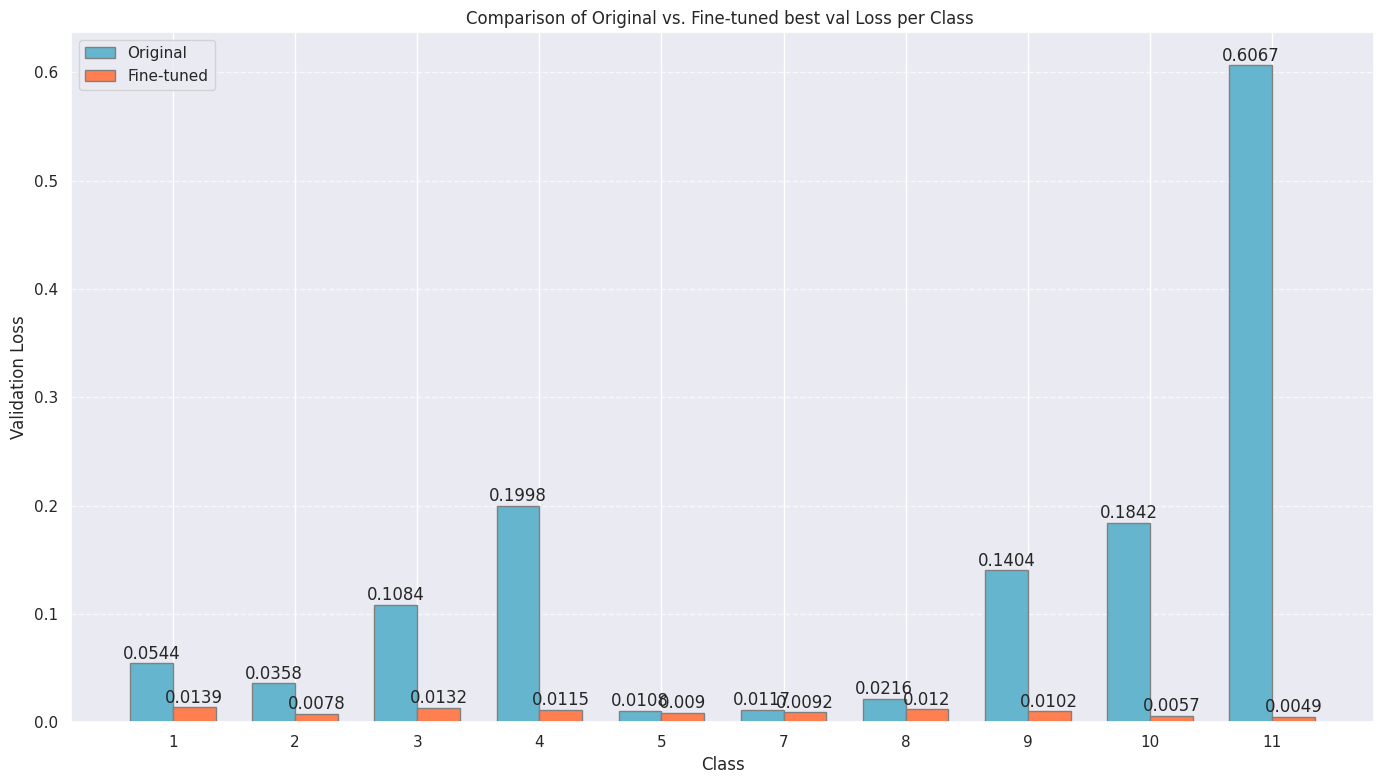


 
 
 
 
 ------ Finetuned Diffusion Model upsample ------ 
 
 
 
 



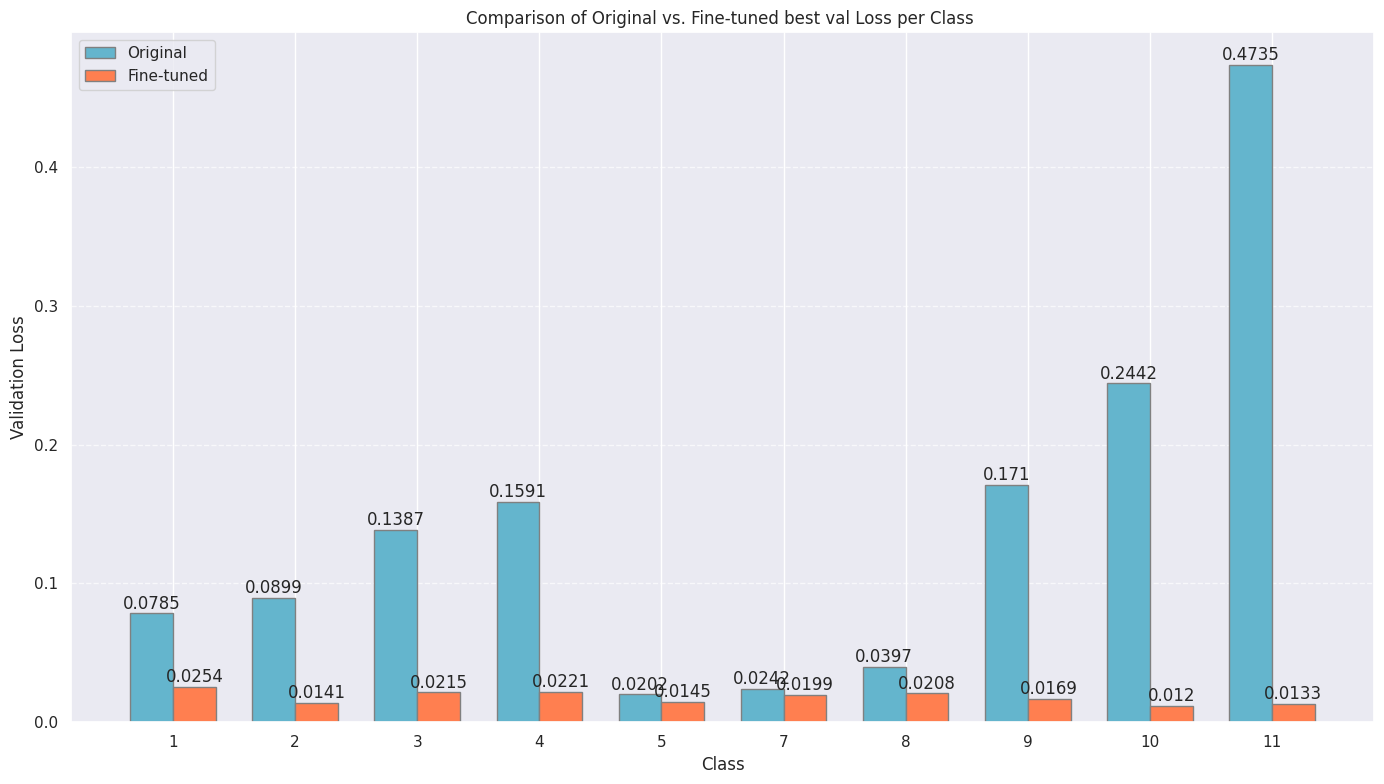

In [ ]:
for temp in ridimension_cycle:
  if verbose == True:
    temp_path = f"/content/gdrive/MyDrive/Diffusion_Model_Project/{temp}"
    models_dir_temp = os.path.join(temp_path, "diffusion_models")
    print(f"\n \n \n \n \n ------ Finetuned Diffusion Model {temp} ------ \n \n \n \n \n")

    unique_classes = sorted(np.unique(labels))
    base_class = 0
    comparison_data = []

    for class_label in unique_classes:
        if class_label == base_class or class_label == 6:
            continue

        history_path_finetuned = os.path.join(models_dir_temp, f"finetune_history_class_{class_label}.csv")
        history_path_original = os.path.join(models_dir_temp, f"training_history_class_{class_label}.csv")

        if not os.path.exists(history_path_finetuned) or not os.path.exists(history_path_original):
            print(f"\nNo fine-tuning history file found for class {class_label}")
            continue

        try:
            history_df_original = pd.read_csv(history_path_original)
            history_df_finetuned = pd.read_csv(history_path_finetuned)
        except pd.errors.EmptyDataError:
            print(f"\nHistory file for class {class_label} is empty")
            continue

        if 'val_loss' not in history_df_original.columns or 'val_loss' not in history_df_finetuned.columns:
            print(f"\nHistory file for class {class_label} does not contain 'val_loss'")
            continue

        original_val_loss = history_df_original['val_loss'].min()
        finetuned_val_loss = history_df_finetuned['val_loss'].min()


        comparison_data.append({'class': class_label, 'type': 'Original', 'loss': original_val_loss})
        comparison_data.append({'class': class_label, 'type': 'Fine-tuned', 'loss': finetuned_val_loss})




    if comparison_data:
        df = pd.DataFrame(comparison_data)

        classes_to_plot = df['class'].unique()
        bar_width = 0.35
        r1 = np.arange(len(classes_to_plot))
        r2 = [x + bar_width for x in r1]

        original_losses = df[df['type'] == 'Original']['loss'].values
        finetuned_losses = df[df['type'] == 'Fine-tuned']['loss'].values

        plt.figure(figsize=(14, 8))
        bars1 = plt.bar(r1, original_losses, color='c', width=bar_width, edgecolor='grey', label='Original')
        bars2 = plt.bar(r2, finetuned_losses, color='coral', width=bar_width, edgecolor='grey', label='Fine-tuned')

        plt.xlabel('Class')
        plt.ylabel('Validation Loss')
        plt.title('Comparison of Original vs. Fine-tuned best val Loss per Class ')
        plt.xticks([r + bar_width/2 for r in r1], classes_to_plot)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        for bars in [bars1, bars2]:
            for bar in bars:
                yval = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, yval + 0.0005, round(yval, 4), ha='center', va='bottom')

        plt.tight_layout()
        plt.show()
    else:
        print("\nNo data available to generate the plot")

The data regarding the best loss alone are promising, to have the confirmation that the finetuned model is better at generating new images the comparison should be done over the results of the HAR classifier but the computational task of generating the augmented data with the diffusion model is too heavy to be completed in the available amount of time.
In the following plot it is shown how the finetuned diffusion model is able to generate valid spectrogram for classes where the original model failed.

It is not possible to know if the finetuned model is just generating spectrogram without distinguishing between classes or if it has learned to distinguish the characteristics until the test with the HAR model, but using the original diffusion model would force to let go of the worst performing classes such as the 11 or 10.

To ensure that no class was excluded, the fine-tuned models were employed for data augmentation

In the plot below, for each class, there is one image generated with the original model,  one with the finetuned model and one spectrograms from the real samples. Then each is divided in the back and thigh component.


 
 
 
 
 ------ Comparison generation with Diffusion Model  e finetuned diffusion model padding ------ 
 
 
 
 


--- Processing class 1 for image comparison ---


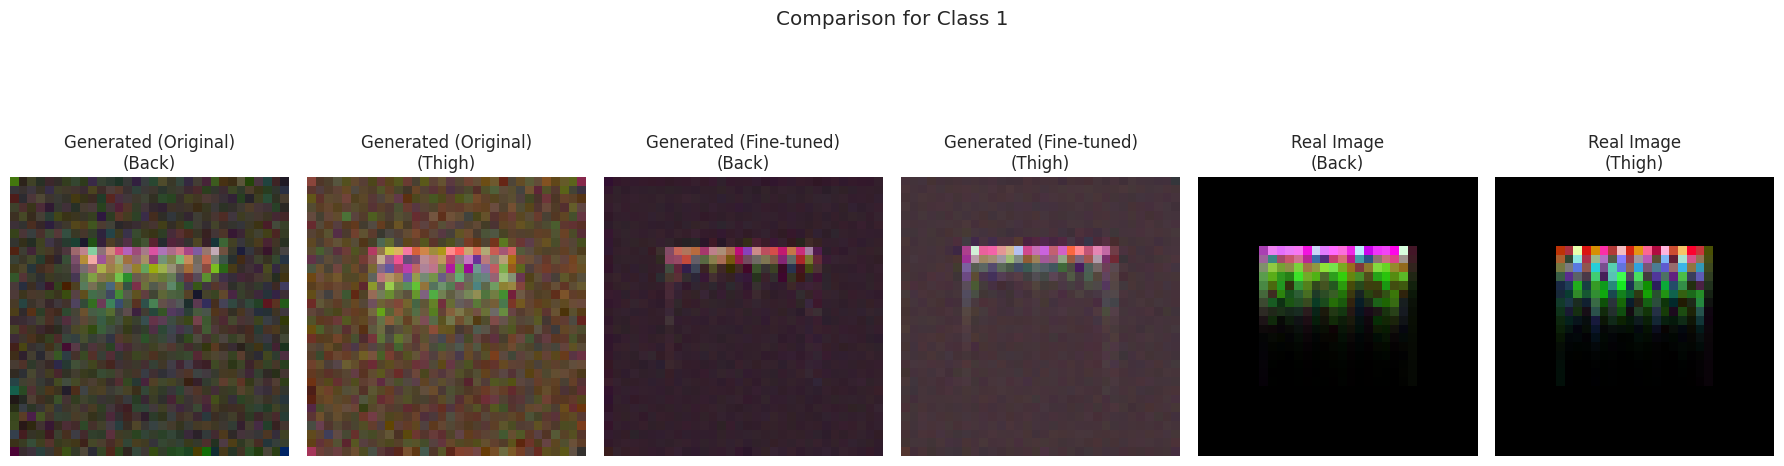


--- Processing class 2 for image comparison ---


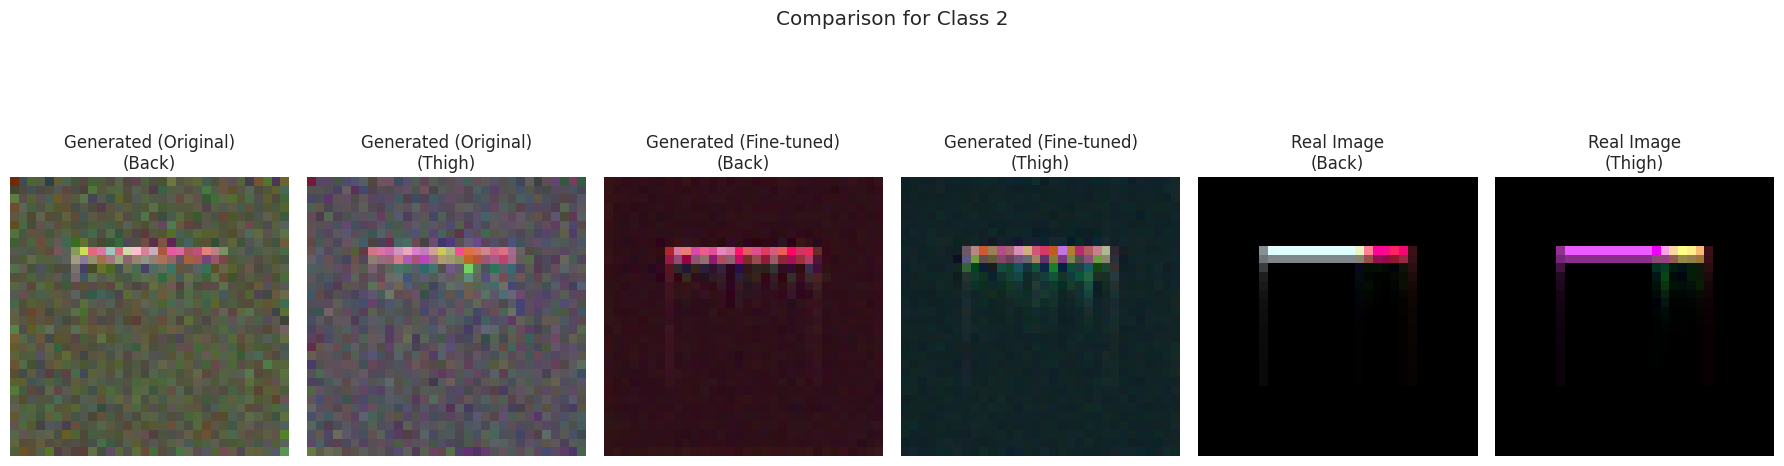


--- Processing class 3 for image comparison ---


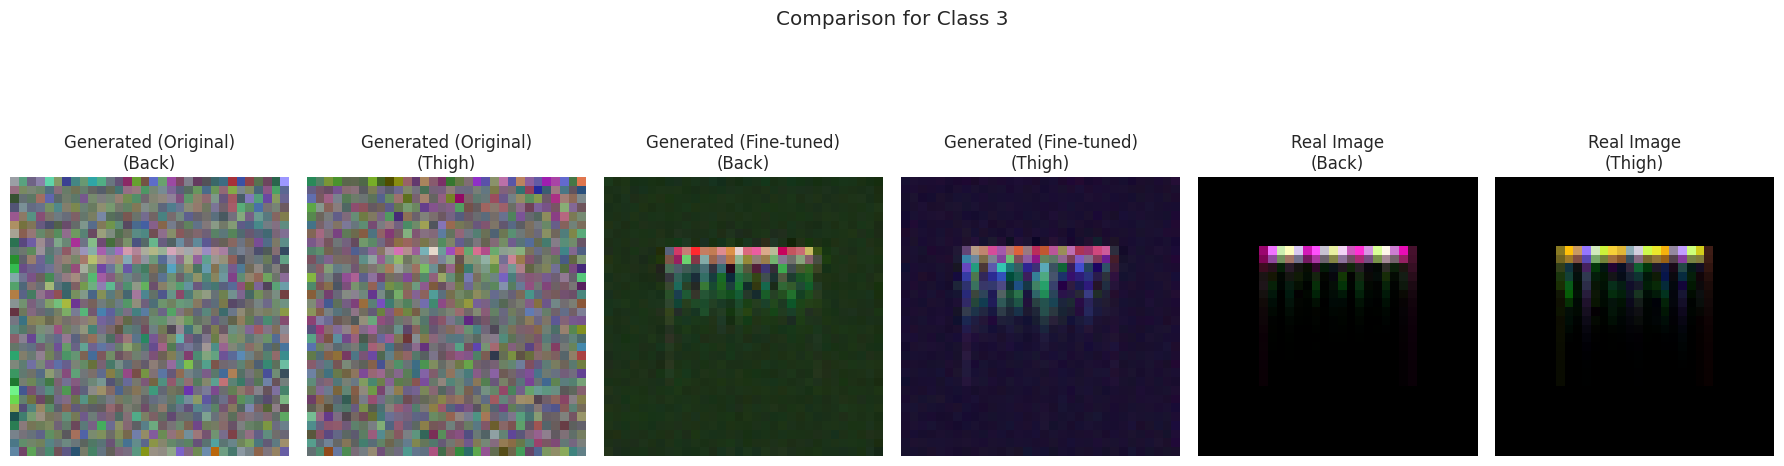


--- Processing class 4 for image comparison ---


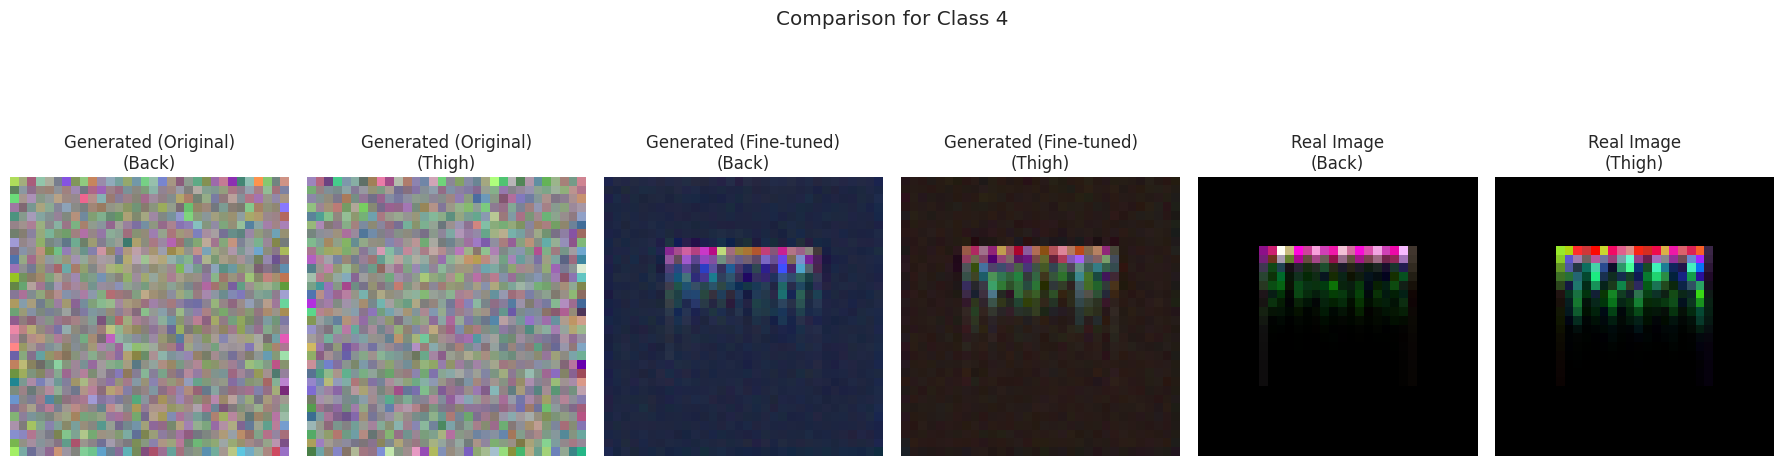


--- Processing class 5 for image comparison ---


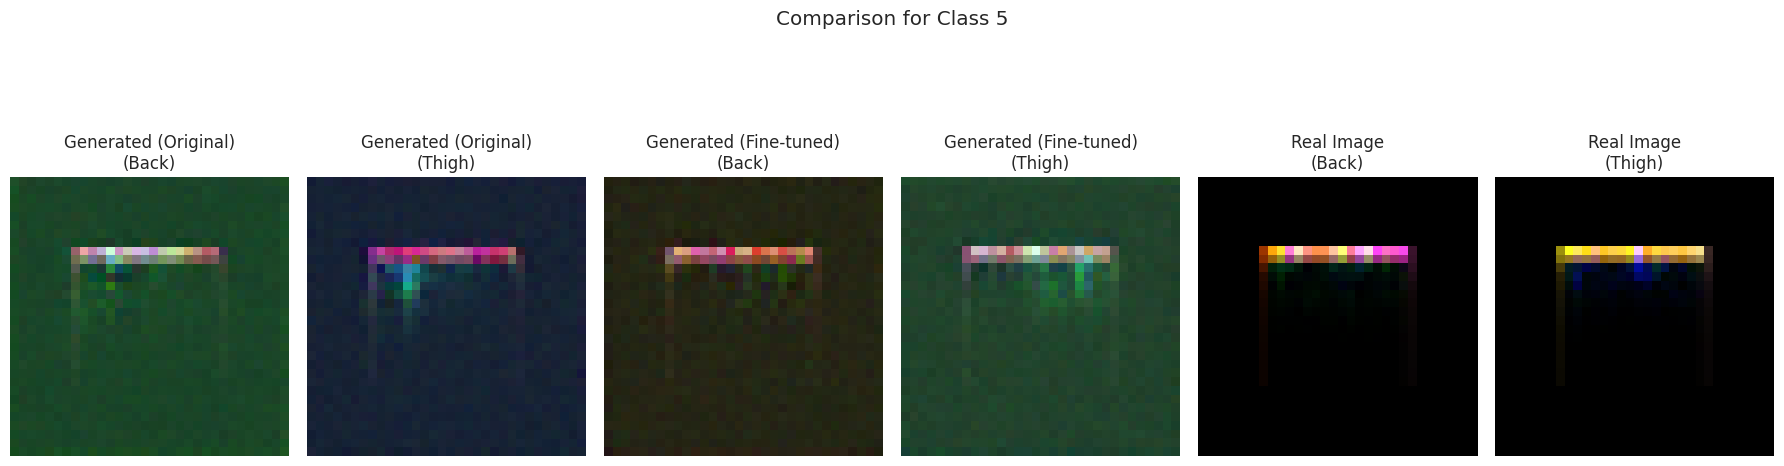


--- Processing class 7 for image comparison ---


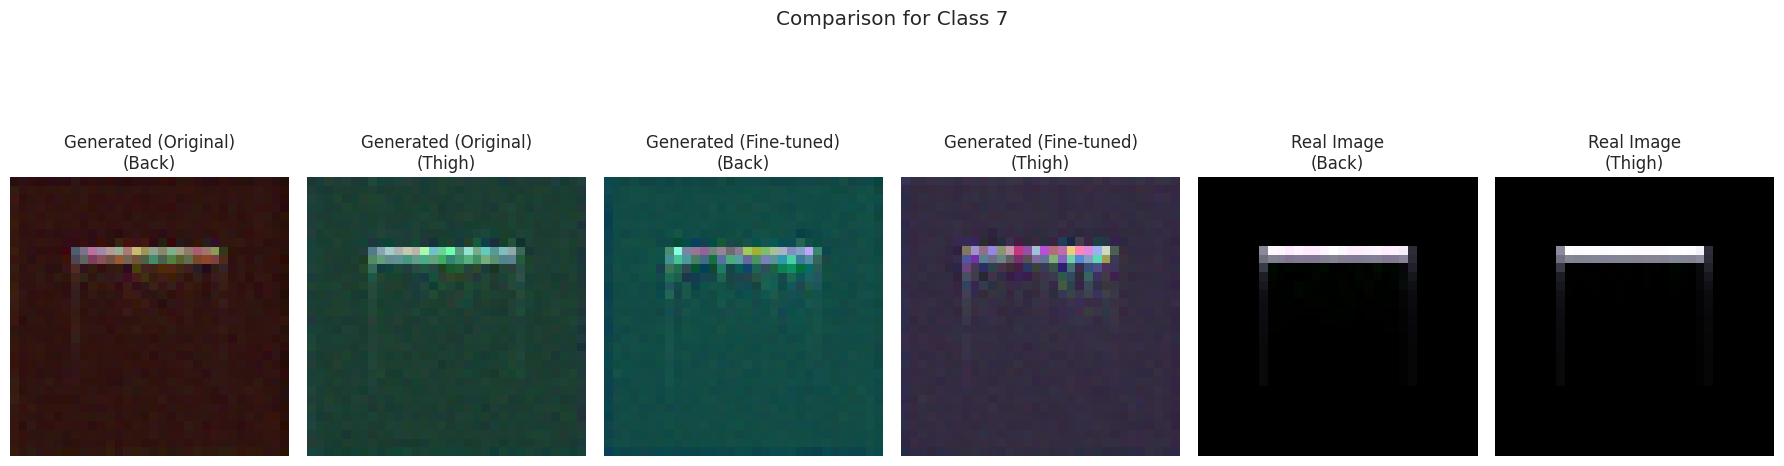


--- Processing class 8 for image comparison ---


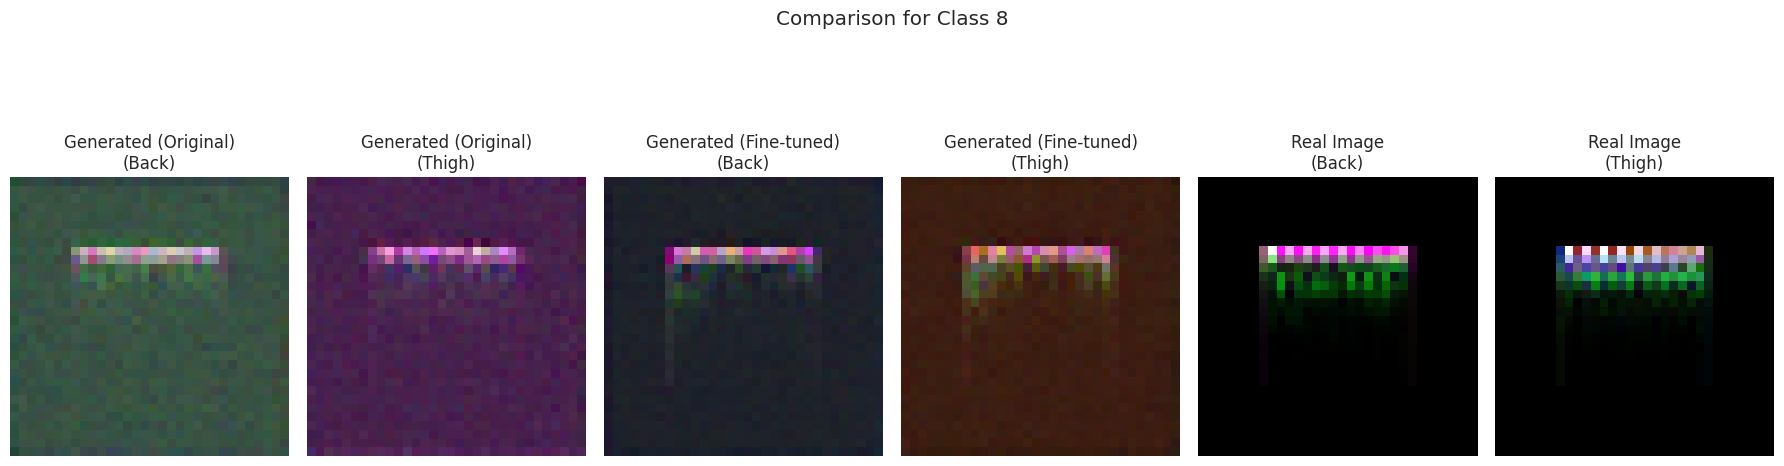


--- Processing class 9 for image comparison ---


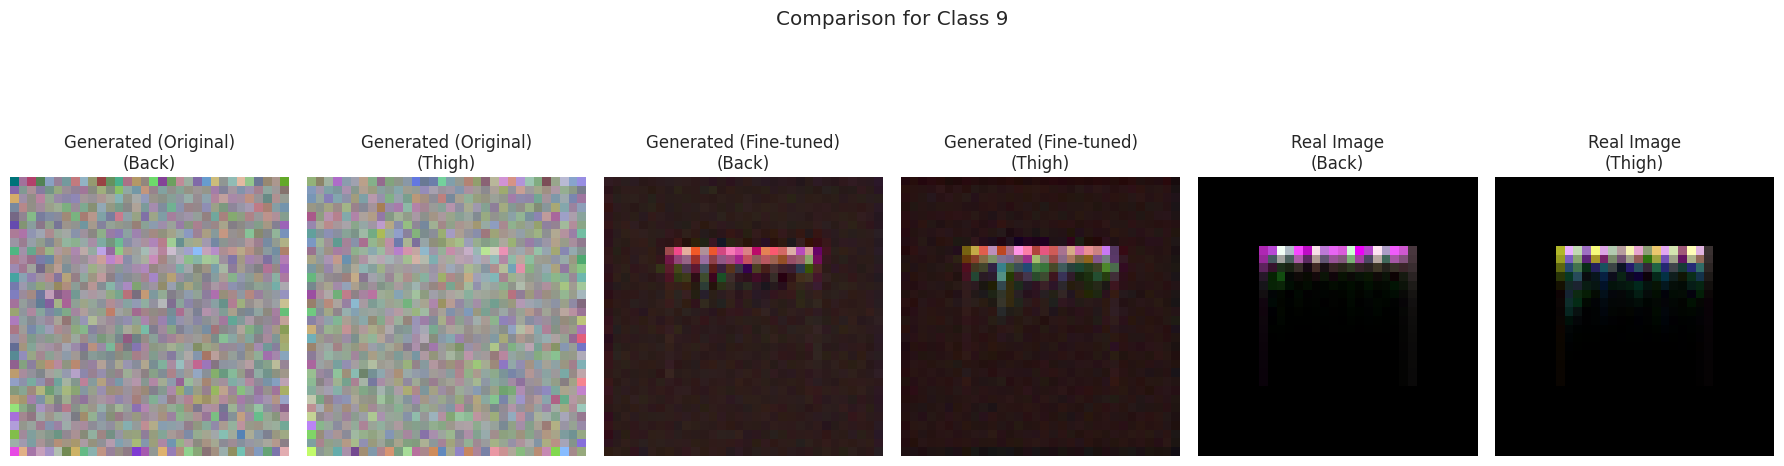


--- Processing class 10 for image comparison ---


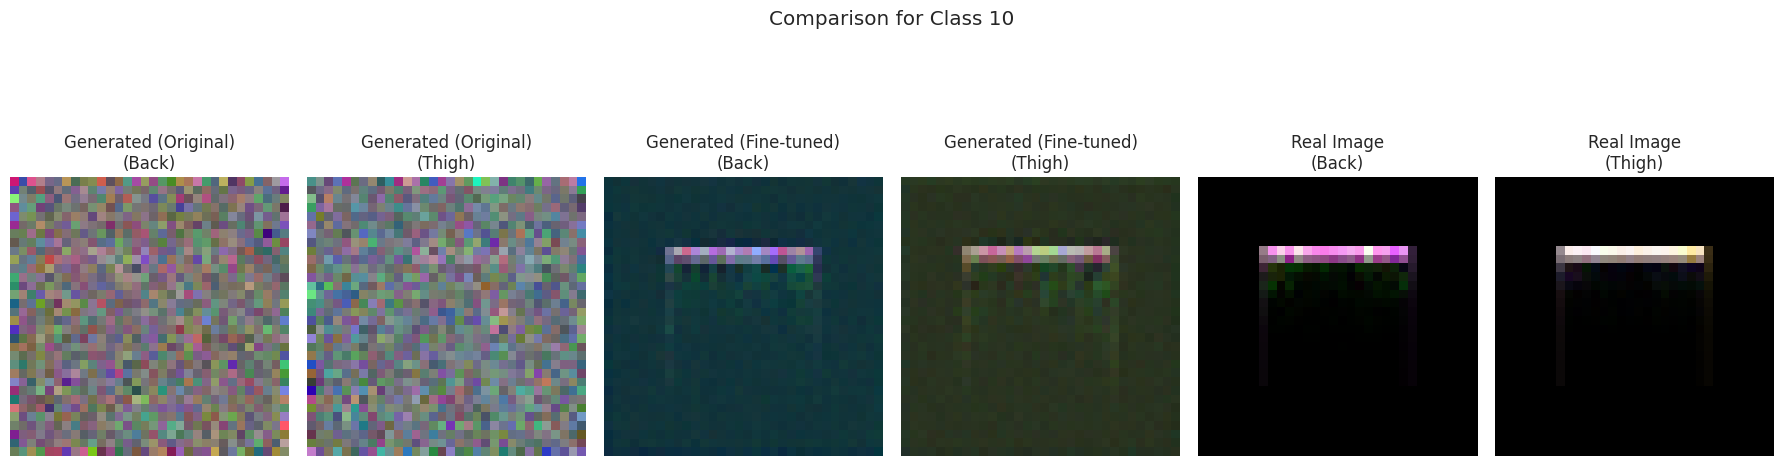


--- Processing class 11 for image comparison ---


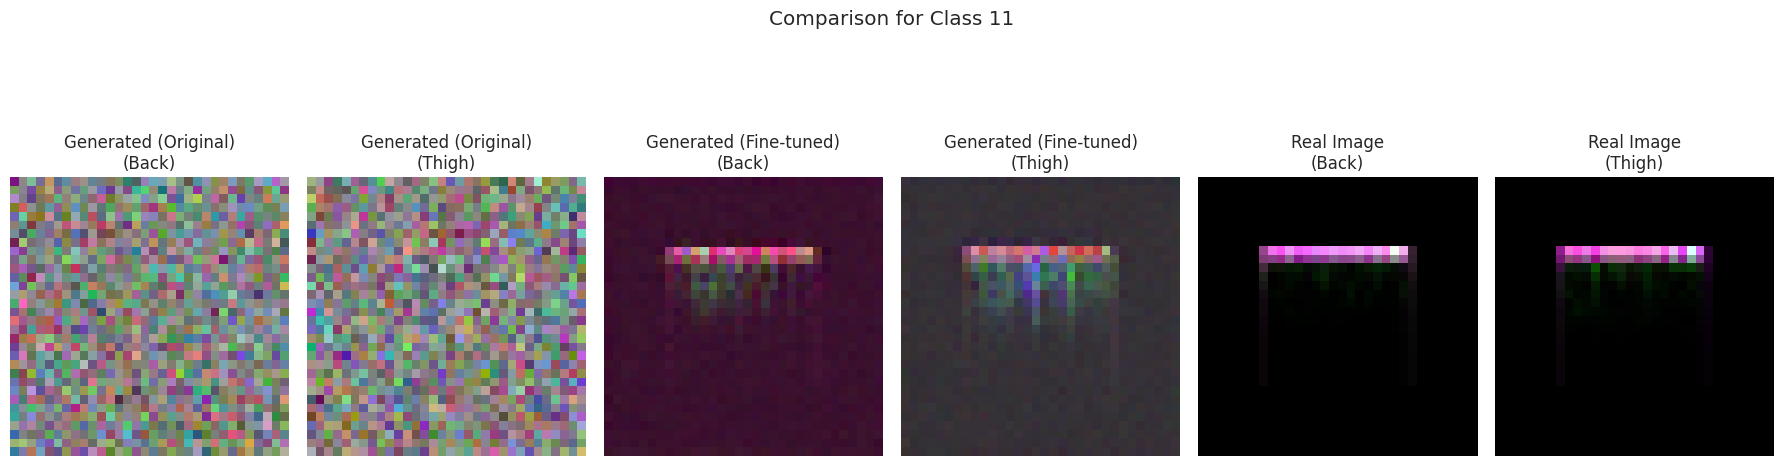


 
 
 
 
 ------ Comparison generation with Diffusion Model  e finetuned diffusion model upsample ------ 
 
 
 
 


--- Processing class 1 for image comparison ---


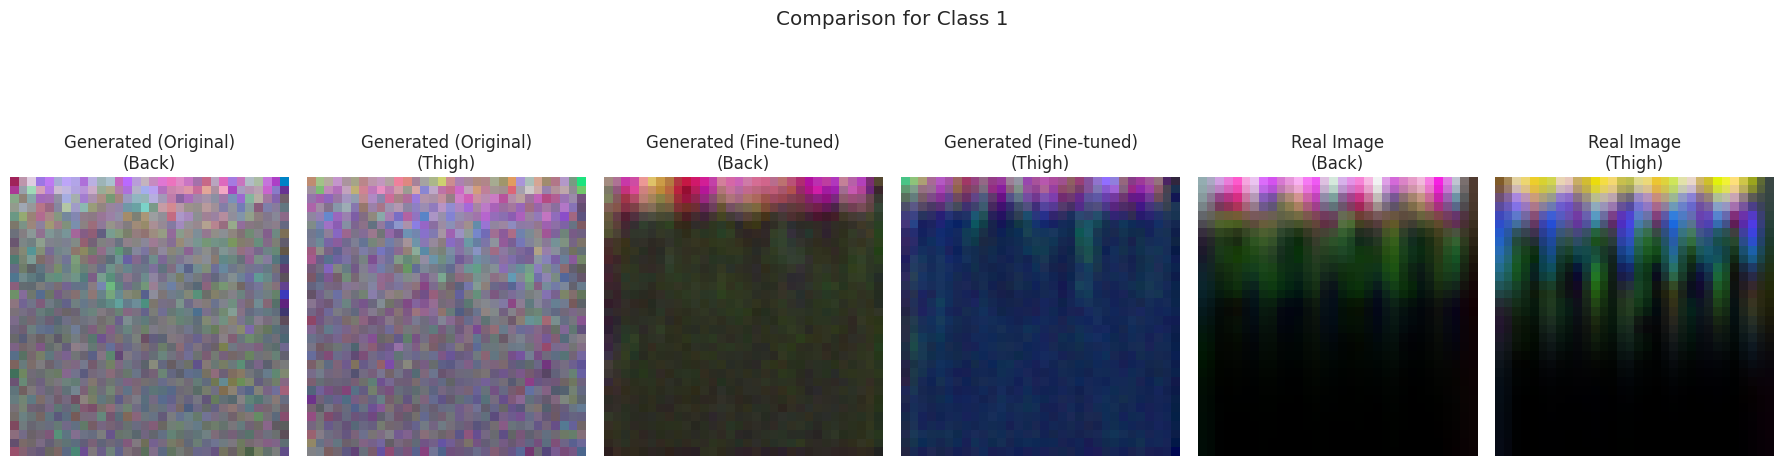


--- Processing class 2 for image comparison ---


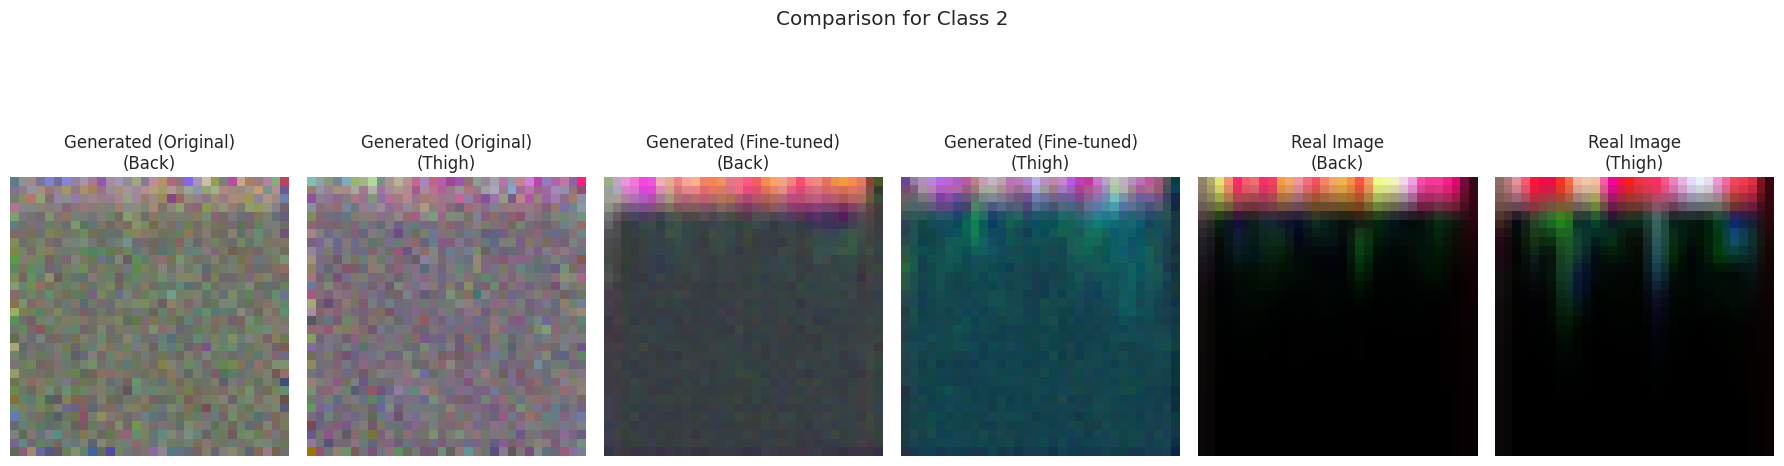


--- Processing class 3 for image comparison ---


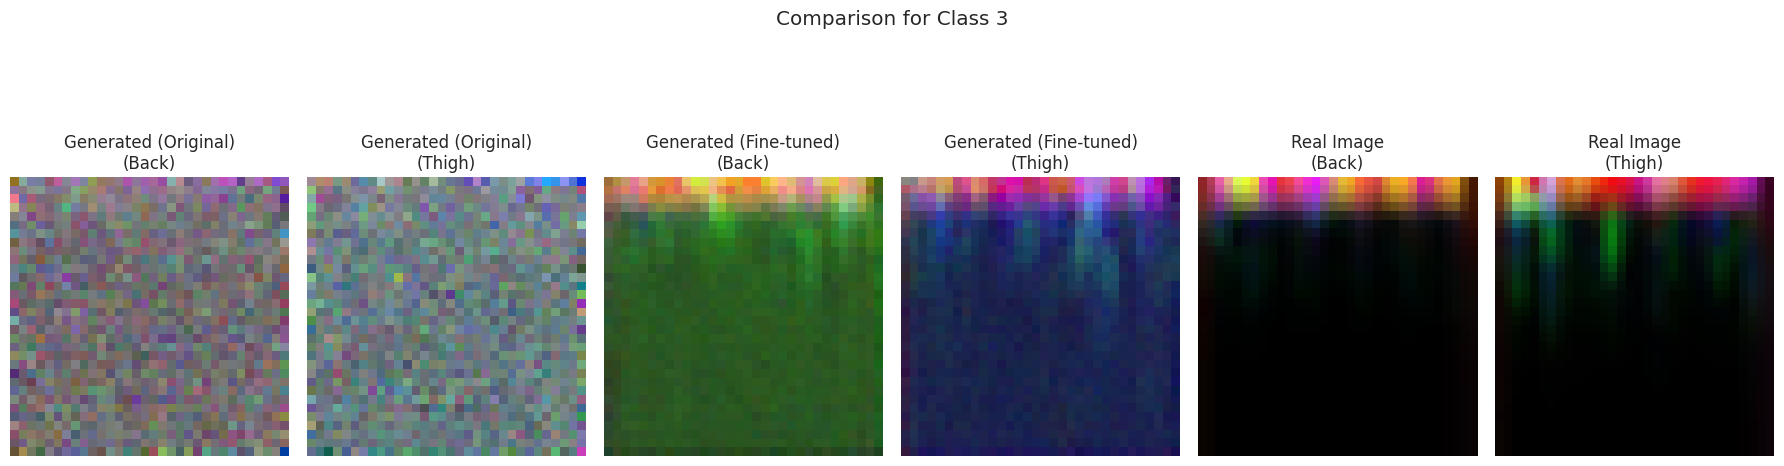


--- Processing class 4 for image comparison ---


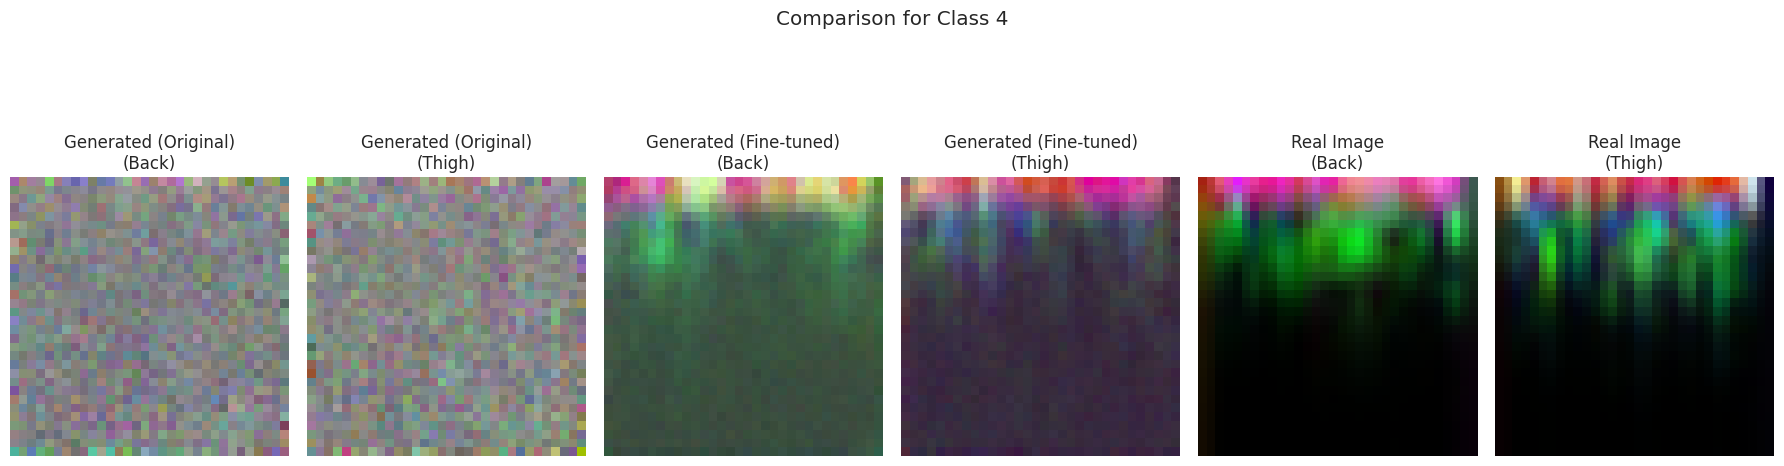


--- Processing class 5 for image comparison ---


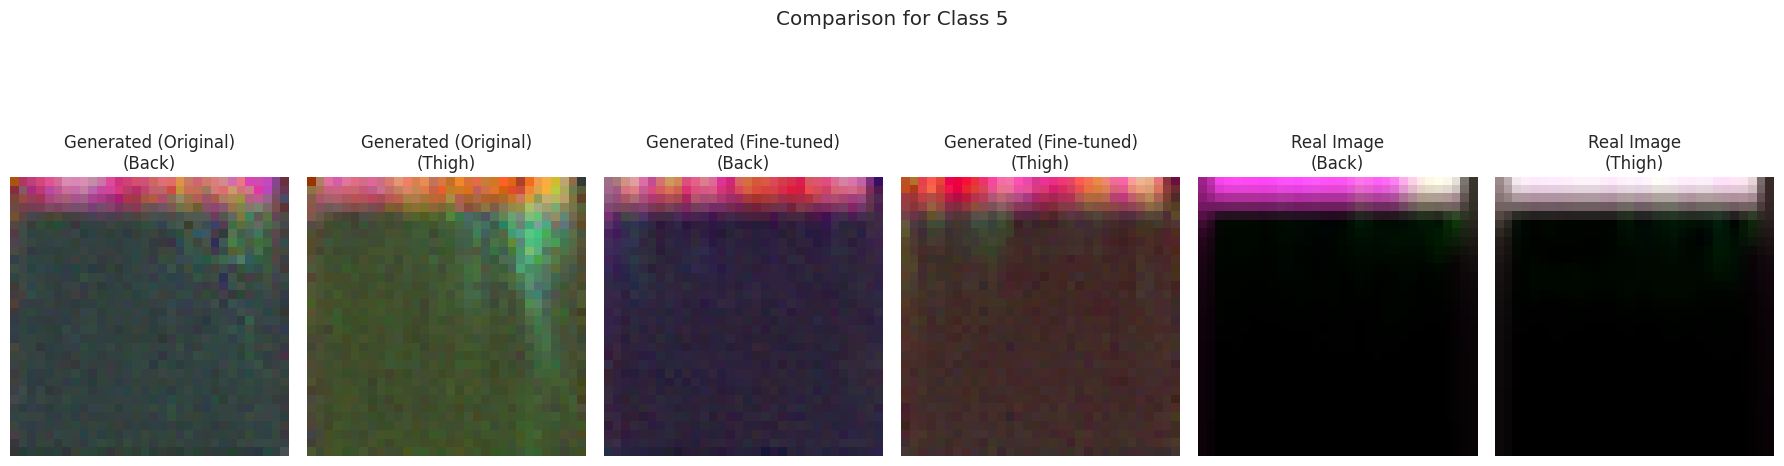


--- Processing class 7 for image comparison ---


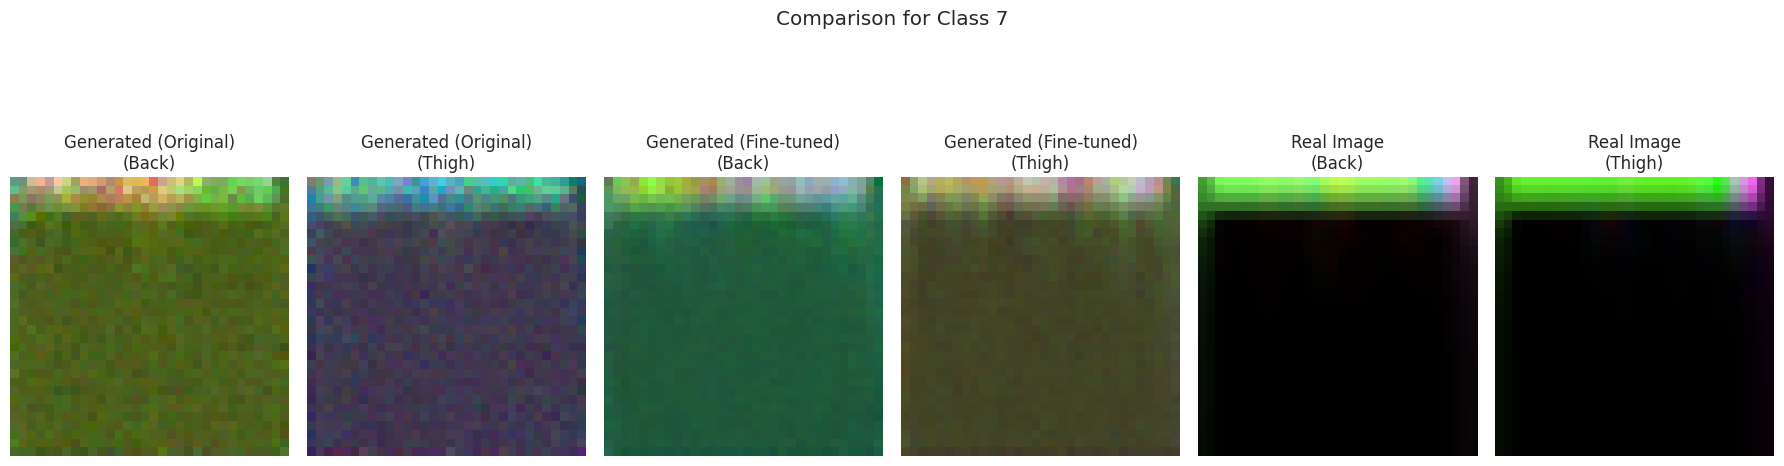


--- Processing class 8 for image comparison ---


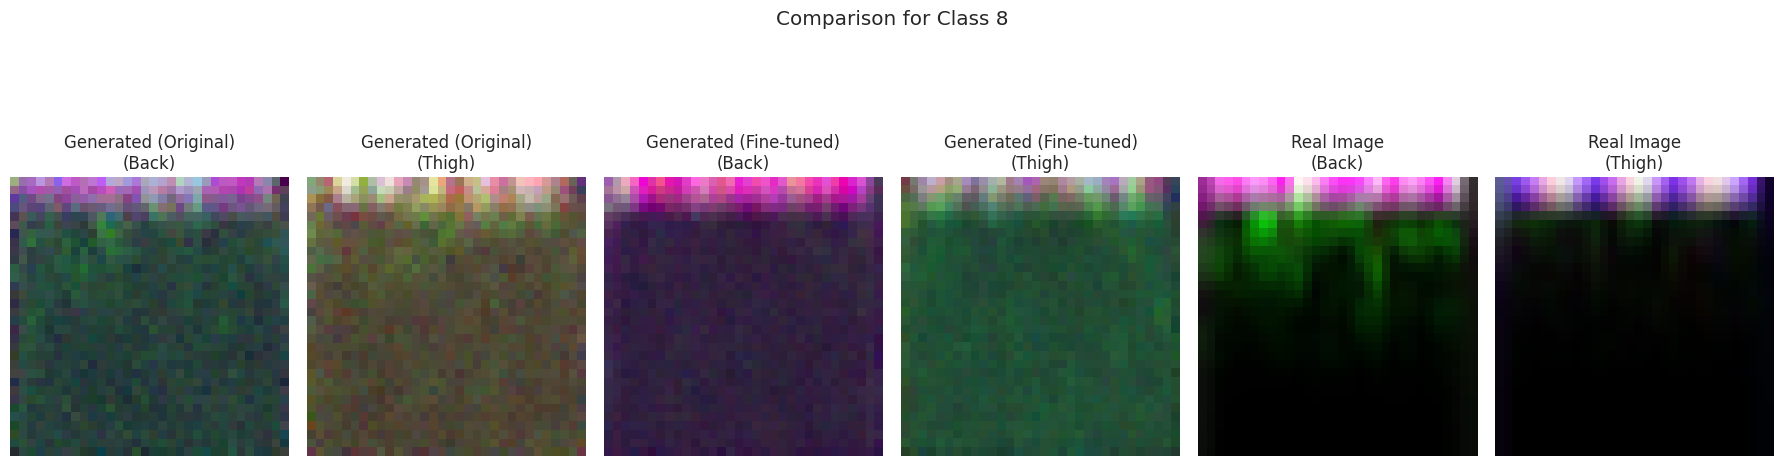


--- Processing class 9 for image comparison ---


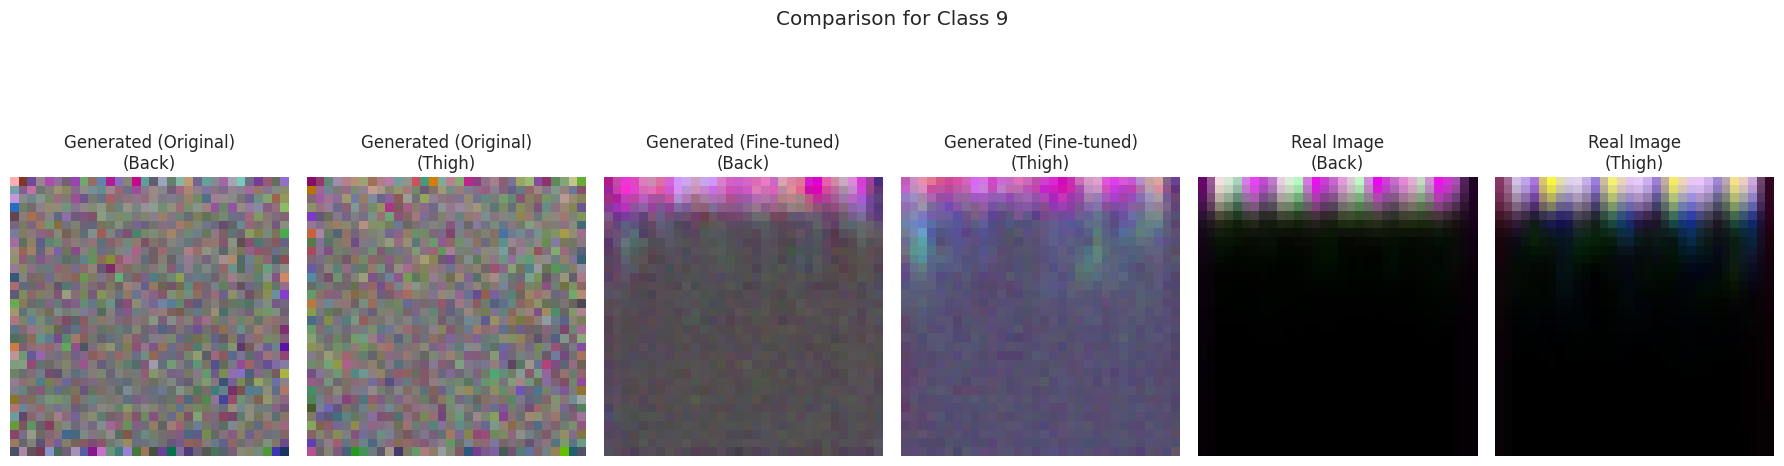


--- Processing class 10 for image comparison ---


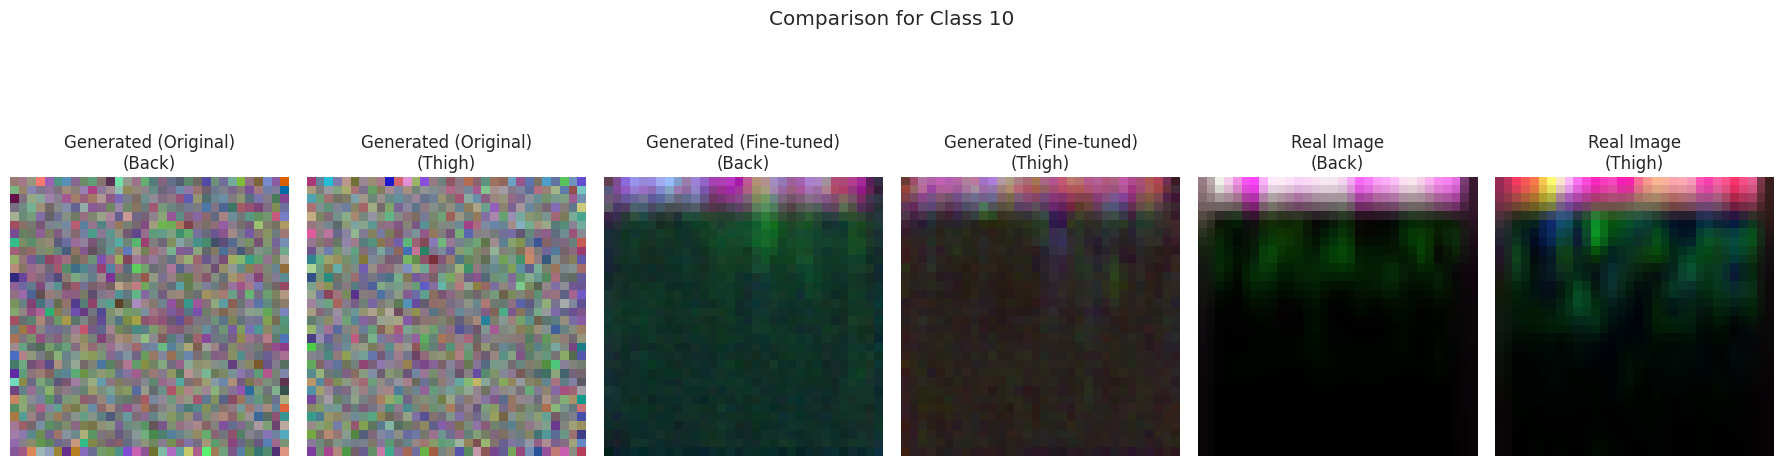


--- Processing class 11 for image comparison ---


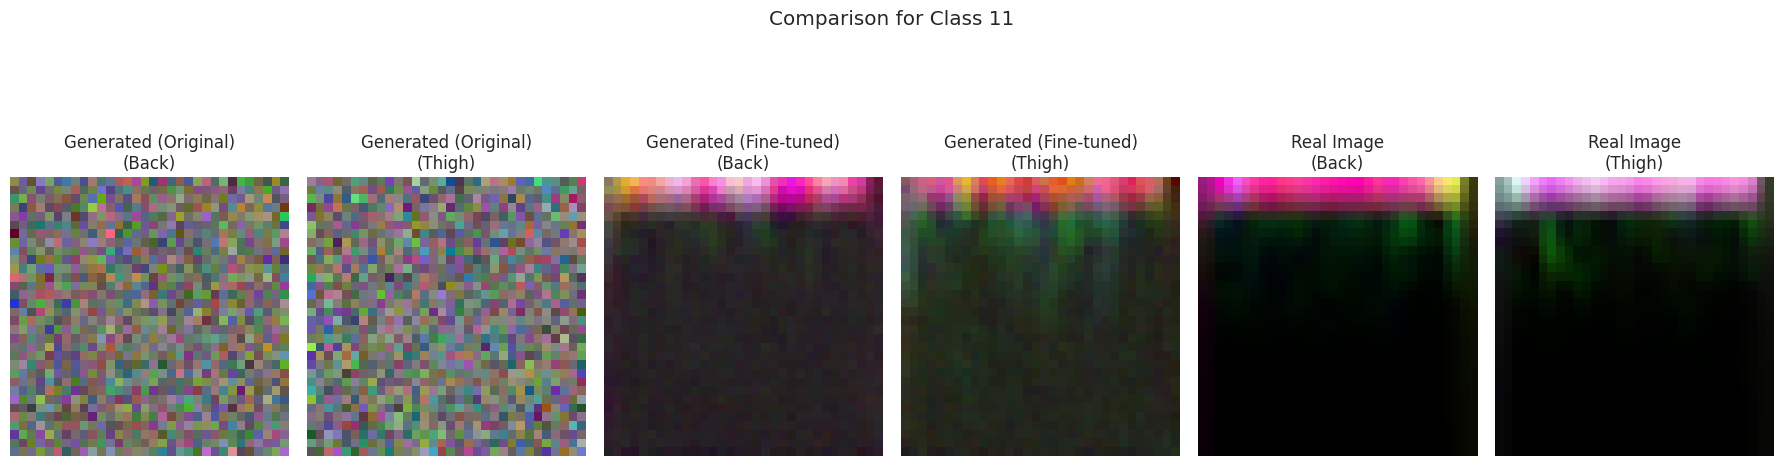

In [ ]:
for temp in ridimension_cycle:
  if verbose == True:
    temp_path = f"/content/gdrive/MyDrive/Diffusion_Model_Project/{temp}"
    models_dir_temp = os.path.join(temp_path, "diffusion_models")
    print(f"\n \n \n \n \n ------ Comparison generation with Diffusion Model  e finetuned diffusion model {temp} ------ \n \n \n \n \n")

    for class_label in unique_classes:

        if class_label == 6 or class_label == 0:
            continue

        print(f"\n--- Processing class {class_label} for image comparison ---")

        unet = UNet2DModel(
            sample_size=H,
            in_channels=6,
            out_channels=6,
            layers_per_block=layers_per_block,
            block_out_channels=block_out_channels,
            down_block_types=down_block_types,
            up_block_types=up_block_types,
        ).to(device)

        diffusion_model = DiffusionModel(unet, timesteps=timesteps, device=device).to(device)

        # load the original model

        original_model_path = os.path.join(models_dir_temp, f"diffusion_model_class_{class_label}.pth")

        generated_original_img = None
        if os.path.exists(original_model_path):
            diffusion_model.load_state_dict(torch.load(original_model_path, map_location=device))
            diffusion_model.eval()
            with torch.no_grad():
                # generates the image
                generated_original_img = diffusion_model.sample((1, 6, H, H))
        else:
            print(f"Original model for class {class_label} not found. Skipping generation.")
            continue

        # load finetuned model
        finetuned_model_path = os.path.join(models_dir_temp, f"diffusion_model_fine_tuned_class_{class_label}.pth")
        generated_finetuned_img = None
        if os.path.exists(finetuned_model_path):
            diffusion_model.load_state_dict(torch.load(finetuned_model_path, map_location=device))
            diffusion_model.eval()
            with torch.no_grad():
                # generates the image
                generated_finetuned_img = diffusion_model.sample((1, 6, H, H))
        else:
            print(f"Fine-tuned model for class {class_label} not found. Skipping generation.")
            continue

        # permut, normalise and separates in back and thigh each image
        gen_orig_np = generated_original_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
        if (gen_orig_np.max() - gen_orig_np.min()) > 1e-8:
          gen_orig_np = (gen_orig_np - gen_orig_np.min()) / (gen_orig_np.max() - gen_orig_np.min())
        else:
          gen_orig_np = gen_orig_np - gen_orig_np.min()

        gen_orig_back = gen_orig_np[:, :, :3]
        gen_orig_thigh = gen_orig_np[:, :, 3:]

        gen_finetuned_np = generated_finetuned_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
        if (gen_finetuned_np.max() - gen_finetuned_np.min()) > 1e-8:
          gen_finetuned_np = (gen_finetuned_np - gen_finetuned_np.min()) / (gen_finetuned_np.max() - gen_finetuned_np.min())
        else:
          gen_finetuned_np = gen_finetuned_np - gen_finetuned_np.min()

        gen_finetuned_back = gen_finetuned_np[:, :, :3]
        gen_finetuned_thigh = gen_finetuned_np[:, :, 3:]

        # search for a random sample with class_label label
        class_indices = np.where(labels == class_label)[0]
        if len(class_indices) > 0:
            random_idx = np.random.choice(class_indices, 1, replace=False)[0]
        else:
            print("No real images found for this class.")
            continue

        back_win = back_samples[random_idx]
        thigh_win = thigh_samples[random_idx]
        # construct the spectrogram
        _, _, combined_img = window_to_rgb_image(back_win, thigh_win, fs, nperseg)
        combined_img_tensor = torch.tensor(combined_img, dtype=torch.float32).permute(2, 0, 1) # C * H * W

        # ridimension
        if temp == "padding":
            pad_h = H - combined_img_tensor.shape[1]
            pad_w = W - combined_img_tensor.shape[2]
            pad_h_top = pad_h // 2
            pad_h_bottom = pad_h - pad_h_top
            pad_w_left = pad_w // 2
            pad_w_right = pad_w - pad_w_left
            ridimensioned_img_tensor = F.pad(combined_img_tensor, (pad_w_left, pad_w_right, pad_h_top, pad_h_bottom), 'constant', 0)
        elif temp == "upsample":
            ridimensioned_img_tensor = F.interpolate(
                combined_img_tensor.unsqueeze(0),
                size=(H, W),
                mode='bilinear',
                align_corners=False
            ).squeeze(0)
        else:
            raise ValueError("Value for 'ridimension' not valid")

        # reorder the tensor
        original_np = ridimensioned_img_tensor.permute(1, 2, 0).cpu().numpy() # H * W* C
        original_back = original_np[:, :, :3]
        original_thigh = original_np[:, :, 3:]

        fig, axes = plt.subplots(1, 6, figsize=(18, 6))

        axes[0].imshow(gen_orig_back)
        axes[0].set_title("Generated (Original)\n(Back)")
        axes[0].axis('off')
        axes[1].imshow(gen_orig_thigh)
        axes[1].set_title("Generated (Original)\n(Thigh)")
        axes[1].axis('off')

        axes[2].imshow(gen_finetuned_back)
        axes[2].set_title("Generated (Fine-tuned)\n(Back)")
        axes[2].axis('off')
        axes[3].imshow(gen_finetuned_thigh)
        axes[3].set_title("Generated (Fine-tuned)\n(Thigh)")
        axes[3].axis('off')

        axes[4].imshow(original_back)
        axes[4].set_title("Real Image\n(Back)")
        axes[4].axis('off')
        axes[5].imshow(original_thigh)
        axes[5].set_title("Real Image\n(Thigh)")
        axes[5].axis('off')

        plt.suptitle(f"Comparison for Class {class_label}")
        plt.tight_layout()
        plt.show()

Plot to visualise the forward diffusion process over one sample


 
 
 
 
 ------ Forward process visualisation with padding ------ 
 
 
 
 



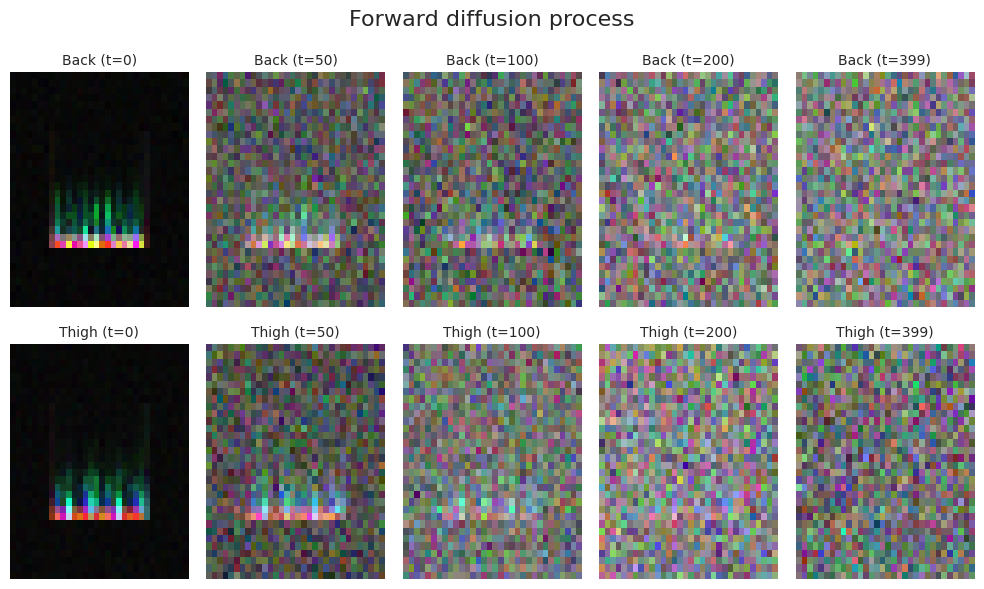


 
 
 
 
 ------ Forward process visualisation with upsample ------ 
 
 
 
 



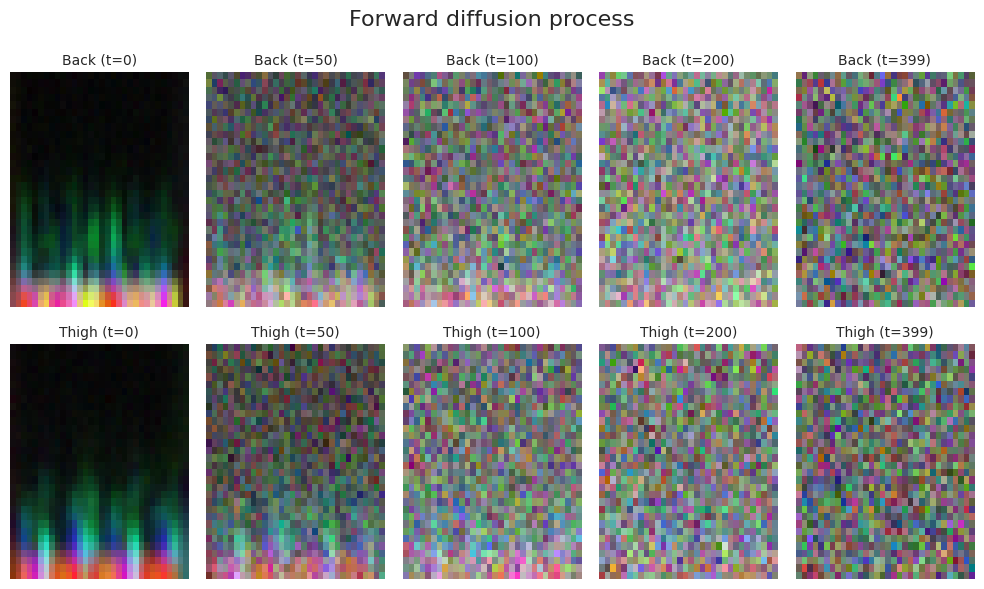

In [ ]:
for temp in ridimension_cycle:
  if verbose == True:
    temp_path = f"/content/gdrive/MyDrive/Diffusion_Model_Project/{temp}"
    models_dir_temp = os.path.join(temp_path, "diffusion_models")
    print(f"\n \n \n \n \n ------ Forward process visualisation with {temp} ------ \n \n \n \n \n")

    #Plot to check the propagation of the noise
    device_vis = torch.device("cpu")

    original_index = 3890
    back_win = back_samples[original_index]
    thigh_win = thigh_samples[original_index]
    _, _, combined_img = window_to_rgb_image(back_win, thigh_win, fs, nperseg)

    combined_img_tensor = torch.tensor(combined_img, dtype=torch.float32).permute(2, 0, 1) # c * H * W

    if temp == "padding":
        pad_h = H - combined_img_tensor.shape[1]
        pad_w = W -  combined_img_tensor.shape[2]
        pad_h_top = pad_h // 2
        pad_h_bottom = pad_h - pad_h_top
        pad_w_left = pad_w // 2
        pad_w_right = pad_w - pad_w_left
        ridimensioned_img_tensor = F.pad(combined_img_tensor, (pad_w_left, pad_w_right, pad_h_top, pad_h_bottom),  'constant', 0)
    elif temp == "upsample":
        ridimensioned_img_tensor = F.interpolate(
            combined_img_tensor.unsqueeze(0),
            size=(H, W),
            mode='bilinear',
            align_corners=False
        ).squeeze(0)

    else:
        print(temp)
        raise ValueError("Value for rdimension not valid")

    ridimensioned_img_tensor = ridimensioned_img_tensor.to(device_vis)

    unet_vis = UNet2DModel(
        sample_size=H,
        in_channels=6,
        out_channels=6,
        layers_per_block=layers_per_block,
        block_out_channels=block_out_channels,
        down_block_types=down_block_types,
        up_block_types=up_block_types,
    ).to(device_vis)

    diffusion_model_vis = DiffusionModel(unet_vis, timesteps=timesteps, device=device_vis).to(device_vis)

    timesteps_to_show = [0, 50, 100, 200, 399]
    num_images = len(timesteps_to_show)

    noisy_back_images = []
    noisy_thigh_images = []
    for t_val in timesteps_to_show:
        t = torch.full((1,), t_val, device=device_vis).long()
        noisy_img_tensor = diffusion_model_vis.forward_diffusion(ridimensioned_img_tensor, t)

        noisy_back_tensor = noisy_img_tensor.squeeze(0).permute(1, 2, 0)[:, :, :3] # H * W* C
        noisy_thigh_tensor = noisy_img_tensor.squeeze(0).permute(1, 2, 0)[:, :, 3:] # H * W * C

        noisy_back_np = noisy_back_tensor.cpu().numpy()
        if (noisy_back_np.max() - noisy_back_np.min()) > 1e-8:
          noisy_back_np = (noisy_back_np - noisy_back_np.min()) / (noisy_back_np.max() - noisy_back_np.min())
        else:
          noisy_back_np = noisy_back_np - noisy_back_np.min()
        noisy_back_images.append(noisy_back_np)

        noisy_thigh_np = noisy_thigh_tensor.cpu().numpy()
        if (noisy_thigh_np.max() - noisy_thigh_np.min()) > 1e-8:
          noisy_thigh_np = (noisy_thigh_np - noisy_thigh_np.min()) / (noisy_thigh_np.max() - noisy_thigh_np.min())
        else:
          noisy_thigh_np = noisy_thigh_np - noisy_thigh_np.min()

        noisy_thigh_images.append(noisy_thigh_np)

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 6))
    fig.suptitle("Forward diffusion process", fontsize=16)

    for i, (ax, img_np) in enumerate(zip(axes[0], noisy_back_images)):
        ax.imshow(img_np, aspect='auto', origin='lower')
        ax.set_title(f"Back (t={timesteps_to_show[i]})", fontsize=10)
        ax.axis('off')

    for i, (ax, img_np) in enumerate(zip(axes[1], noisy_thigh_images)):
        ax.imshow(img_np, aspect='auto', origin='lower')
        ax.set_title(f"Thigh (t={timesteps_to_show[i]})", fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Plot to visualise the backword process


 
 
 
 
 ------ Backword process visualisation with padding ------ 
 
 
 
 



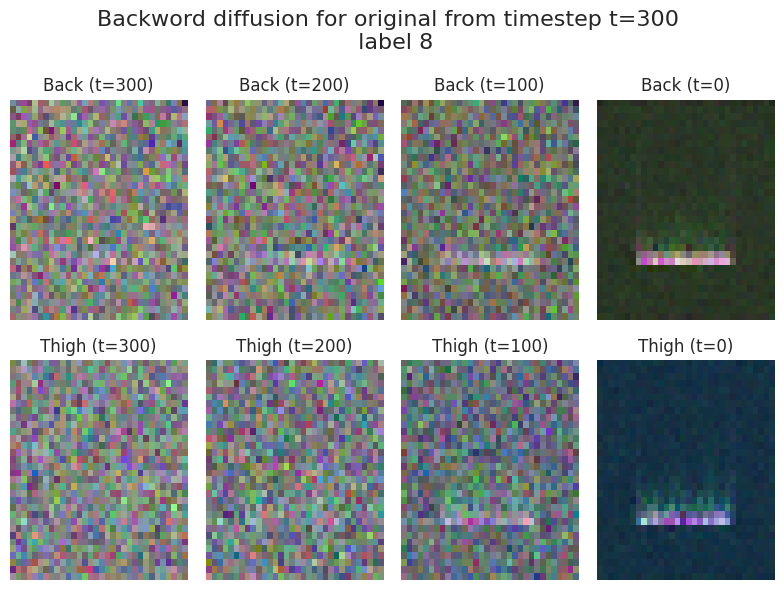

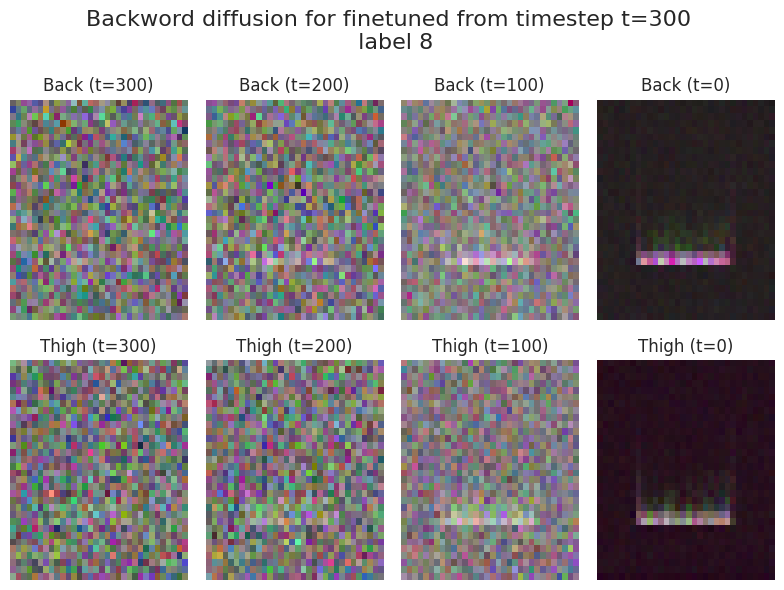


 
 
 
 
 ------ Backword process visualisation with upsample ------ 
 
 
 
 



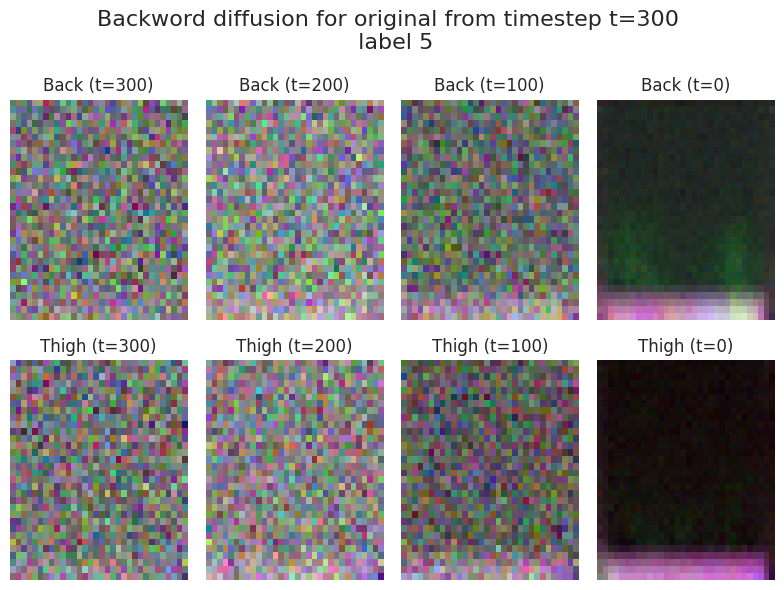

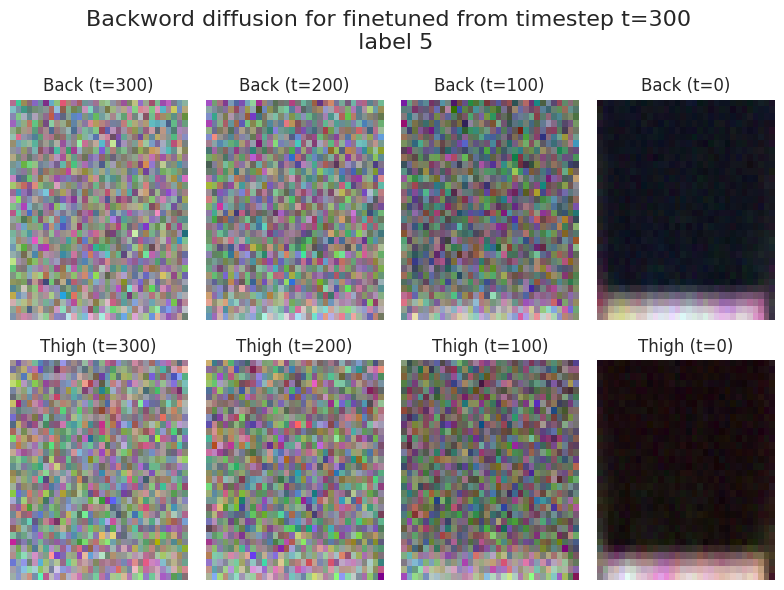

In [ ]:
for temp in ridimension_cycle:
  if verbose == True:
    temp_path = f"/content/gdrive/MyDrive/Diffusion_Model_Project/{temp}"
    models_dir_temp = os.path.join(temp_path, "diffusion_models")
    print(f"\n \n \n \n \n ------ Backword process visualisation with {temp} ------ \n \n \n \n \n")

    label = 0
    while label  == 0 or label == 6:
      original_index = np.random.randint(0, len(back_samples))
      label = labels[original_index]

    for i in range(2):
      if i == 0:
        dataset_type = "original"
      if i == 1:
        dataset_type = "finetuned"
      if verbose == True:
          device_vis = torch.device("cpu")

          # process the random sample
          back_win = back_samples[original_index]
          thigh_win = thigh_samples[original_index]
          _, _, combined_img = window_to_rgb_image(back_win, thigh_win, fs, nperseg)

          original_img_tensor = torch.tensor(combined_img, dtype=torch.float32).permute(2, 0, 1)

          if temp == "padding":
              pad_h = H - original_img_tensor.shape[1]
              pad_w = W -  original_img_tensor.shape[2]
              pad_h_top = pad_h // 2
              pad_h_bottom = pad_h - pad_h_top
              pad_w_left = pad_w // 2
              pad_w_right = pad_w - pad_w_left
              ridimensioned_img_tensor = F.pad(original_img_tensor, (pad_w_left, pad_w_right, pad_h_top, pad_h_bottom),  'constant', 0)
          elif temp == "upsample":
              ridimensioned_img_tensor = F.interpolate(
                  original_img_tensor.unsqueeze(0),
                  size=(H, W),
                  mode='bilinear',
                  align_corners=False
              ).squeeze(0)

          else:
              raise ValueError("Value for rdimension not valid")


          unet_vis = UNet2DModel(
              sample_size=H,
              in_channels=6,
              out_channels=6,
              layers_per_block=layers_per_block,
              block_out_channels=block_out_channels,
              down_block_types=down_block_types,
              up_block_types=up_block_types,
          ).to(device_vis)

          diffusion_model_vis = DiffusionModel(unet_vis, timesteps=timesteps, device=device_vis).to(device_vis)

          # laod the model
          try:
              if i == 0:
                model_path = os.path.join(models_dir_temp, f"diffusion_model_class_{labels[original_index]}.pth")
              if i == 1:
                model_path = os.path.join(models_dir_temp, f"diffusion_model_fine_tuned_class_{labels[original_index]}.pth")

              diffusion_model_vis.load_state_dict(torch.load(model_path, map_location=device_vis))
              diffusion_model_vis.eval()

          except FileNotFoundError:
              print("Warning: no model found")

          # add noise to the image
          start_timestep = 300
          t_start = torch.full((1,), start_timestep, device=device_vis).long()
          noise = torch.randn_like(ridimensioned_img_tensor)

          x_t = diffusion_model_vis.forward_diffusion(ridimensioned_img_tensor, t_start, noise=noise)
          images_to_plot = {}

          # try to denoise the image with added noise
          with torch.no_grad():
              x = x_t
              images_to_plot[start_timestep] = x.clone()

              for t_val in reversed(range(start_timestep + 1)):
                  if t_val % 100 == 0:
                      images_to_plot[t_val] = x.clone()

                  t_batch = torch.full((1,), t_val, device=device_vis, dtype=torch.long)

                  predicted_noise = diffusion_model_vis.unet(x, t_batch).sample

                  alpha_t = diffusion_model_vis.alphas[t_val]
                  alpha_cumprod_t = diffusion_model_vis.alphas_cumprod[t_val]
                  beta_t = diffusion_model_vis.betas[t_val]

                  x = (1.0 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * predicted_noise)

                  # add random noise in every time step except the last one
                  if t_val > 0:
                      z = torch.randn_like(x)
                      x = x + torch.sqrt(beta_t) * z

          timesteps_to_show = sorted(images_to_plot.keys(), reverse=True)
          num_images = len(timesteps_to_show)

          fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 6))
          fig.suptitle(f"Backword diffusion for {dataset_type} from timestep t={start_timestep} \n label {labels[original_index]}", fontsize=16)


          for i, t_val in enumerate(timesteps_to_show):

              img_tensor = images_to_plot[t_val]
              np_array = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy() # H * W* C
              if (np_array.max() - np_array.min()) > 1e-8:
                np_array = (np_array - np_array.min()) / (np_array.max() - np_array.min())
              else:
                np_array = np_array - np_array.min()

              back_img = np_array[:, :, :3]
              thigh_img = np_array[:, :, 3:]

              ax1 = axes[0, i]
              ax1.imshow(back_img, aspect='auto', origin='lower')
              ax1.set_title(f"Back (t={t_val})")
              ax1.axis('off')

              ax2 = axes[1, i]
              ax2.imshow(thigh_img, aspect='auto', origin='lower')
              ax2.set_title(f"Thigh (t={t_val})")
              ax2.axis('off')


          plt.tight_layout()
          plt.show()

## Data augmentation

### Data augmentation with fine tuned diffusion model (and original model)

In [178]:
# data augmentation with diffusion model and finetuned model

# I need to consider the datset without the validation subjects to calculate how many samples I need to generate for each class
train_mask = np.isin(subjects, validation_subjects, invert=True)
labels_train_temp = labels[train_mask]
class_counts = Counter(labels_train_temp)
print("Class distribution:", class_counts)

if not class_counts:
    print("Warning: problem with label count")
    target_count = 0
else:
    print(f"Target count = {target_count}")

# Since the program needs a lot of time to complete all the generation I save the images generated every 8 step ( aka every batch of generated images)
save_step = 8

for k in range(2):
    if k == 0:
      # If I wanted to genearte the augmented data also for the orignal diffusion model I jsut need to cancel this continue
      continue

    for class_label in sorted(class_counts.keys()):
        if class_label == 6:
         continue
        if k == 0:
            class_dir = os.path.join(path, f"Augmented_data_class_{class_label}")
        elif k == 1:
            class_dir = os.path.join(path, f"Augmented_data_class_finetuned_{class_label}")
        os.makedirs(class_dir, exist_ok=True)

        images_path = os.path.join(class_dir, f"images_class_{class_label}.npy")
        labels_path = os.path.join(class_dir, f"labels_class_{class_label}.npy")

        balanced_images_class = []
        balanced_labels_class = []

        # if the directory is already existent load the images that were already generated
        if os.path.exists(images_path):
            existing_images = np.load(images_path, allow_pickle=True)
            existing_labels = np.load(labels_path, allow_pickle=True)
            balanced_images_class.extend(existing_images)
            balanced_labels_class.extend(existing_labels)

        # count the number of images present in the training data plus the generated ones
        current_total_count = class_counts[class_label] + len(balanced_images_class)

        # if the total amount is below the target count
        if current_total_count < target_count:

            # generates the remaining ones (num_to_generate)

            num_to_generate = target_count - current_total_count
            print(f"\nGeneration of {num_to_generate} samples for class {class_label}")
            if k == 0:
                model_path = os.path.join(models_dir, f"diffusion_model_class_{class_label}.pth")
            elif k == 1:
                model_path = os.path.join(models_dir, f"diffusion_model_fine_tuned_class_{class_label}.pth")

            if not os.path.exists(model_path):
                print(f"Warning: no model found for class {class_label}. Skipping generation for this class.")
                continue

            unet = UNet2DModel(
                sample_size=H,
                in_channels=6,
                out_channels=6,
                layers_per_block=layers_per_block,
                block_out_channels=block_out_channels,
                down_block_types=down_block_types,
                up_block_types=up_block_types,
            ).to(device)
            diffusion_model = DiffusionModel(unet, timesteps=timesteps, device=device).to(device)
            diffusion_model.load_state_dict(torch.load(model_path, map_location=device))
            diffusion_model.eval()

            num_to_generate_at_once = 8
            generated_count = 0

            while generated_count < num_to_generate:
                batch_size_gen = min(num_to_generate_at_once, num_to_generate - generated_count)
                with torch.no_grad():
                    synthetic_imgs = diffusion_model.sample((batch_size_gen, 6, H, W))

                synthetic_imgs_np = synthetic_imgs.permute(0, 2, 3, 1).cpu().numpy() # Batch * H * W * C
                balanced_images_class.extend(synthetic_imgs_np)
                balanced_labels_class.extend([class_label] * batch_size_gen)
                generated_count += batch_size_gen
                if (generated_count % save_step == 0) and (generated_count > 0):
                    print(f"Images saved for class {class_label}: {generated_count}/{num_to_generate}")
                    np.save(images_path, np.array(balanced_images_class), allow_pickle=True)
                    np.save(labels_path, np.array(balanced_labels_class), allow_pickle=True)

        else:
            print(f"\nClass {class_label} has already {current_total_count} samples or more.")

        print(f"Saving final dataset for class {class_label}.")
        np.save(images_path, np.array(balanced_images_class), allow_pickle=True)
        np.save(labels_path, np.array(balanced_labels_class), allow_pickle=True)

Class distribution: Counter({np.int64(6): 9651, np.int64(0): 3864, np.int64(5): 2046, np.int64(7): 1492, np.int64(8): 1389, np.int64(1): 1107, np.int64(2): 540, np.int64(3): 221, np.int64(4): 178, np.int64(9): 171, np.int64(10): 99, np.int64(11): 22})
Target count = 3000

Class 0 has already 3864 samples or more.
Saving final dataset for class 0.

Class 1 has already 3000 samples or more.
Saving final dataset for class 1.

Class 2 has already 3000 samples or more.
Saving final dataset for class 2.

Class 3 has already 3000 samples or more.
Saving final dataset for class 3.

Class 4 has already 3000 samples or more.
Saving final dataset for class 4.

Class 5 has already 3000 samples or more.
Saving final dataset for class 5.

Class 7 has already 3000 samples or more.
Saving final dataset for class 7.

Class 8 has already 3000 samples or more.
Saving final dataset for class 8.

Class 9 has already 3000 samples or more.
Saving final dataset for class 9.

Class 10 has already 3000 samples 

### Data Augmentation with Smote

With the augmented images and smote I have achieved to reach a minimum of target_count = 3000 samples for each class but there are still some class which contains more samples (specifically class 0 and class 6). The function balance data has the scope of reducing this numbers to 3000.

Both the dataset will use this function separately with different random extraction since the smote datset is already augmented there is no way to extract the same original samples.

This could seem as a bias in the construction but the augmented images have been built using the knowledge of the images that are being cut off from class 0  ( the same is not true for the one in class 6 ).

To solve it class 6 is balanced before applying smote.
Regarding class 0, the fact that the images have been used for the training of the diffusion model should level the situation.
Even if the samples extracted form class 0 are different between the diffusion augmented dataset and the smote augmented one both have an hidden intrinsic knowledge of all samples.

In [179]:
def balance_data(back_samples, thigh_samples, labels, target_count, source_name, class_not_to_balance):

    back_balanced = []
    thigh_balanced = []
    labels_balanced = []

    class_counts = Counter(labels)
    print(f" Initial Distribution {source_name} : {class_counts}")

    for class_label in sorted(class_counts.keys()):
        class_indices = np.where(labels == class_label)[0]
        current_count = len(class_indices)

        if current_count > target_count and class_label not in class_not_to_balance:
            selected_indices = np.random.choice(class_indices, target_count, replace=False)
        else:
            selected_indices = class_indices

        back_balanced.append(back_samples[selected_indices])
        thigh_balanced.append(thigh_samples[selected_indices])
        labels_balanced.append(labels[selected_indices])

    balanced_back = np.concatenate(back_balanced, axis=0)
    balanced_thigh = np.concatenate(thigh_balanced, axis=0)
    balanced_labels = np.concatenate(labels_balanced, axis=0)

    print(f" FInal Distribution {source_name} : {Counter(balanced_labels)}")

    return balanced_back, balanced_thigh, balanced_labels

In [180]:
class_counts = Counter(labels)
print("Initial distribution:", class_counts)

# Define SMOTE sampling strategy
smote_sampling_strategy = {}
for cls, count in class_counts.items():
    if count < target_count:
        smote_sampling_strategy[cls] = target_count
    elif count >= target_count:
        print(f"Class {cls} already has {count} samples, which is sufficient or in excess. It will be ignored by SMOTE.")

if not smote_sampling_strategy:
    print("No classes need augmentation, the SMOTE script will be skipped.")
else:

    # here I define the train and test dataset that I will also use for HAR

    train_mask = np.isin(subjects, validation_subjects, invert=True)

    back_train_temp = back_samples[train_mask]
    thigh_train_temp = thigh_samples[train_mask]
    labels_train_temp = labels[train_mask]

    test_mask = np.isin(subjects, validation_subjects)
    back_test = back_samples[test_mask]
    thigh_test = thigh_samples[test_mask]
    labels_test = labels[test_mask]

    # balance class 6 --> this will be balnced for all the classes after smote
    back_train_original, thigh_train_original, labels_train_original = balance_data(back_train_temp, thigh_train_temp, labels_train_temp, target_count, "original", class_not_to_balance = [0])

    # check if smote ha already been performed

    save_dir = os.path.join(path, "Smote_augmented_data")
    os.makedirs(save_dir, exist_ok=True)

    class_counts = Counter(labels_train_original)
    print("Intermediate distribution:", class_counts)

    X_train = np.concatenate(
        [back_train_original.reshape(len(back_train_original), -1),
        thigh_train_original.reshape(len(thigh_train_original), -1)],
        axis=1
    )
    y_train = labels_train_original

    smote = SMOTE(sampling_strategy=smote_sampling_strategy, k_neighbors=5, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    print("Distribution after SMOTE (on training data only):", Counter(y_resampled))

    n_back = back_samples.shape[1] * 3
    back_train_resampled = X_resampled[:, :n_back].reshape(-1, back_samples.shape[1], 3)
    thigh_train_resampled = X_resampled[:, n_back:].reshape(-1, thigh_samples.shape[1], 3)

    save_dir = os.path.join(path, "Smote_augmented_data")
    os.makedirs(save_dir, exist_ok=True)

    np.save(os.path.join(save_dir, "back_train_resampled.npy"), back_train_resampled)
    np.save(os.path.join(save_dir, "thigh_train_resampled.npy"), thigh_train_resampled)
    np.save(os.path.join(save_dir, "labels_train_resampled.npy"), y_resampled)

    print(f"\nAugmented training data saved to: {save_dir}")

Initial distribution: Counter({np.int64(6): 11079, np.int64(0): 4233, np.int64(5): 2326, np.int64(7): 1759, np.int64(8): 1453, np.int64(1): 1134, np.int64(2): 576, np.int64(3): 272, np.int64(4): 215, np.int64(9): 180, np.int64(10): 105, np.int64(11): 24})
Class 6 already has 11079 samples, which is sufficient or in excess. It will be ignored by SMOTE.
Class 0 already has 4233 samples, which is sufficient or in excess. It will be ignored by SMOTE.
 Initial Distribution original : Counter({np.int64(6): 9651, np.int64(0): 3864, np.int64(5): 2046, np.int64(7): 1492, np.int64(8): 1389, np.int64(1): 1107, np.int64(2): 540, np.int64(3): 221, np.int64(4): 178, np.int64(9): 171, np.int64(10): 99, np.int64(11): 22})
 FInal Distribution original : Counter({np.int64(0): 3864, np.int64(6): 3000, np.int64(5): 2046, np.int64(7): 1492, np.int64(8): 1389, np.int64(1): 1107, np.int64(2): 540, np.int64(3): 221, np.int64(4): 178, np.int64(9): 171, np.int64(10): 99, np.int64(11): 22})
Intermediate distribu

## HAR

### Creation dataloader per HAR

I need two dataset types to pass to the HAR: the first is made for inertial signals that all need to be transformed into spetrograms (HARImageDataset) and the second (HybridHARImageDataset) to handle inertial signal and spectrograms generated with the augmentation models (which dont have an inertial format)

In [181]:
class HARImageDataset(Dataset):

    def __init__(self, back_samples, thigh_samples, labels, height, width, ridimension="padding"):
        self.back_samples = back_samples
        self.thigh_samples = thigh_samples
        self.labels = labels
        self.target_height = height
        self.target_width = width
        self.ridimension = ridimension

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        back_win = self.back_samples[idx]
        thigh_win = self.thigh_samples[idx]
        _, _, img = window_to_rgb_image(back_win, thigh_win, fs, nperseg)
        label = self.labels[idx]
        img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) # C * H * W

        if self.ridimension == "padding":
            pad_h = self.target_height - img_tensor.shape[1]
            pad_w = self.target_width - img_tensor.shape[2]
            pad_h_top = pad_h // 2
            pad_h_bottom = pad_h - pad_h_top
            pad_w_left = pad_w // 2
            pad_w_right = pad_w - pad_w_left
            final_img_tensor = F.pad(img_tensor, (pad_w_left, pad_w_right, pad_h_top, pad_h_bottom), 'constant', 0)
        elif self.ridimension == "upsample":
            final_img_tensor = F.interpolate(
                img_tensor.unsqueeze(0),
                size=(self.target_height, self.target_width),
                mode='bilinear',
                align_corners=False
            ).squeeze(0)

        else:
            raise ValueError("Invalid value for 'ridimension'. Must be 'padding' or 'upsample'.")

        return final_img_tensor, torch.tensor(label, dtype=torch.long)

class HybridHARImageDataset(Dataset):

    def __init__(self, original_back_samples, original_thigh_samples, original_labels,
                 synthetic_images, synthetic_labels, height, width, ridimension):

        self.original_back_samples = original_back_samples
        self.original_thigh_samples = original_thigh_samples
        self.original_labels = original_labels
        self.original_size = len(original_labels)

        self.synthetic_images = synthetic_images
        self.synthetic_labels = synthetic_labels
        self.synthetic_size = len(synthetic_labels)

        self.target_height = height
        self.target_width = width
        self.ridimension = ridimension

    def __len__(self):
        return self.original_size + self.synthetic_size

    def __getitem__(self, idx):

        # the indexes for the orignal samples are first and then the generated images
        if idx < self.original_size:

            # Handle original samples
            back_win = self.original_back_samples[idx]
            thigh_win = self.original_thigh_samples[idx]
            _, _, img = window_to_rgb_image(back_win, thigh_win, fs, nperseg)
            label = self.original_labels[idx]
            img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) # C* H * W

            if self.ridimension == "padding":
                pad_h = self.target_height - img_tensor.shape[1]
                pad_w = self.target_width - img_tensor.shape[2]
                pad_h_top = pad_h // 2
                pad_h_bottom = pad_h - pad_h_top
                pad_w_left = pad_w // 2
                pad_w_right = pad_w - pad_w_left
                final_img_tensor = F.pad(img_tensor, (pad_w_left, pad_w_right, pad_h_top, pad_h_bottom), 'constant', 0)
            elif self.ridimension == "upsample":
                final_img_tensor = F.interpolate(
                    img_tensor.unsqueeze(0),
                    size=(self.target_height, self.target_width),
                    mode='bilinear',
                    align_corners=False
                ).squeeze(0)
            else:
                raise ValueError("Invalid value for 'ridimension'. Must be 'padding' or 'upsample'.")
        else:
          # handle generated images
            synth_idx = idx - self.original_size
            img = self.synthetic_images[synth_idx]
            if img.max() - img.min() > 1e-8:
              img = (img - img.min()) / (img.max() - img.min())
            else:
              img = img - img.min()
            label = self.synthetic_labels[synth_idx]
            final_img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) # C * H * W


        return final_img_tensor, torch.tensor(label, dtype=torch.long)

In [182]:
# here I balance the dataset for the class 0 then this wuill be augmented using the images generated by the diffusion model
back_train_original_balanced, thigh_train_original_balanced, labels_train_original_balanced = balance_data(back_train_original, thigh_train_original, labels_train_original, target_count, "original", class_not_to_balance = [None])


print(f"Original training data: {len(labels_train_original_balanced)} samples")
print(f"Original test data: {len(labels_test)} samples")

test_dataset = HARImageDataset(
    back_test, thigh_test, labels_test,
    height=H, width=W, ridimension=ridimension
)
test_loader = DataLoader(test_dataset, batch_size=batch_size_HAR, shuffle=False)


# -------------------------------------------------------------------------------------------------------------------------------------
#SMOTE Augmentation

print("\n--- Training with SMOTE Augmented Data ---")
smote_dir = os.path.join(path, "Smote_augmented_data")
back_smote = np.load(os.path.join(smote_dir, "back_train_resampled.npy"))
thigh_smote = np.load(os.path.join(smote_dir, "thigh_train_resampled.npy"))
labels_smote = np.load(os.path.join(smote_dir, "labels_train_resampled.npy"))

# here the smote dataset is being balnced respetively to classo 0 ( at the end there will be three thousand samples for each class)
back_smote_combined, thigh_smote_combined, labels_smote_combined = balance_data(back_smote, thigh_smote, labels_smote, target_count, "SMOTE", class_not_to_balance = [None])

# Create a single dataset from the combined signals
train_dataset_smote = HARImageDataset(
    back_smote_combined, thigh_smote_combined, labels_smote_combined,
    height=H, width=W, ridimension=ridimension
)
train_loader_smote = DataLoader(train_dataset_smote, batch_size=batch_size_HAR, shuffle=True)

print(f"SMOTE training data (combined signals): {len(train_dataset_smote)} samples")

# -------------------------------------------------------------------------------------------------------------------------------------
# Fine-tuned Diffusion Augmentation

print("\n--- Training with Fine-tuned Diffusion Augmented Data ---")
finetuned_dir = os.path.join(path, "Augmented_data_class_finetuned")
finetuned_images = []
finetuned_labels = []

# Load all augmented data generated by the fine-tuned diffusion model
for class_label in sorted(np.unique(labels_train_original_balanced)):
  if class_label != 0 and class_label != 6 :  # there is no finetuned model in those cases
    try:
        images_path = os.path.join(path, f"Augmented_data_class_finetuned_{class_label}/images_class_{class_label}.npy")
        labels_path = os.path.join(path, f"Augmented_data_class_finetuned_{class_label}/labels_class_{class_label}.npy")
        finetuned_images.append(np.load(images_path))
        finetuned_labels.append(np.load(labels_path))
    except FileNotFoundError:
        print(f"Warning: No fine-tuned augmented data found for class {class_label} at {images_path}. Skipping.")
        continue

finetuned_images = np.concatenate(finetuned_images, axis=0)
finetuned_labels = np.concatenate(finetuned_labels, axis=0)


train_dataset_finetuned = HybridHARImageDataset(
    back_train_original_balanced, thigh_train_original_balanced, labels_train_original_balanced,
    finetuned_images, finetuned_labels,
    height=H, width=W, ridimension=ridimension
)
train_loader_finetuned = DataLoader(train_dataset_finetuned, batch_size=batch_size_HAR, shuffle=True)

print(f"Fine-tuned Diffusion training data (hybrid): {len(train_dataset_finetuned)} samples")


 Initial Distribution original : Counter({np.int64(0): 3864, np.int64(6): 3000, np.int64(5): 2046, np.int64(7): 1492, np.int64(8): 1389, np.int64(1): 1107, np.int64(2): 540, np.int64(3): 221, np.int64(4): 178, np.int64(9): 171, np.int64(10): 99, np.int64(11): 22})
 FInal Distribution original : Counter({np.int64(0): 3000, np.int64(6): 3000, np.int64(5): 2046, np.int64(7): 1492, np.int64(8): 1389, np.int64(1): 1107, np.int64(2): 540, np.int64(3): 221, np.int64(4): 178, np.int64(9): 171, np.int64(10): 99, np.int64(11): 22})
Original training data: 13265 samples
Original test data: 2576 samples

--- Training with SMOTE Augmented Data ---
 Initial Distribution SMOTE : Counter({np.int64(0): 3864, np.int64(1): 3000, np.int64(2): 3000, np.int64(3): 3000, np.int64(4): 3000, np.int64(5): 3000, np.int64(6): 3000, np.int64(7): 3000, np.int64(8): 3000, np.int64(9): 3000, np.int64(10): 3000, np.int64(11): 3000})
 FInal Distribution SMOTE : Counter({np.int64(0): 3000, np.int64(1): 3000, np.int64(2):

### model

In [183]:
class HARClassifier(nn.Module):
    def __init__(self, num_classes, H, W):
        super(HARClassifier, self).__init__()

        self.conv1 = nn.Conv2d(6, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)

        self.flattened_size = 64 * (H // 8) * (W // 8)
        self.fc1 = nn.Linear( 64 * (H // 8) * (W // 8), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Trianing and plotting Functions

In [184]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.float().to(device)
            labels = labels.long().to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)

    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return avg_loss, accuracy, precision, recall, f1, conf_matrix

def plot_metrics(history, title):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['train_loss'], 'o-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'o-', label='Validation Loss')
    plt.title(f'{title} - Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Metrics (Accuracy, F1, Recall, Specificity)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['val_accuracy'], 'o-', label='Accuracy')
    plt.plot(epochs, history['val_f1_score'], 'o-', label='F1-Score')
    plt.plot(epochs, history['val_recall'], 'o-', label='Recall')
    plt.title(f'{title} - Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'{title} - Matrice di Confusione')
    plt.xlabel('Predetta')
    plt.ylabel('Reale')
    plt.show()

def train_har_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, patience, min_delta, model_save_path):
    model.train()
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_f1_score': [],
        'val_precision': [],
        'val_recall': [],
        'val_confusion_matrix': [],
    }

    best_val_loss = float('inf')
    early_stop_counter = 0

    save_dir = os.path.dirname(model_save_path)
    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images = images.float().to(device)
            labels = labels.long().to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        val_loss, val_accuracy, val_precision, val_recall, val_f1, conf_matrix = evaluate_model(model, val_loader, criterion, device)

        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1_score'].append(val_f1)
        history['val_confusion_matrix'].append(conf_matrix)


        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy*100:.2f}%, "
              f"Val F1: {val_f1:.4f}")

        scheduler.step(val_loss)

        if val_loss + min_delta < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), model_save_path)
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping after {epoch+1} epochs")
                break

    return history


### Training and plots

------ Training finetuned padding-------
Model already trained for finetuned


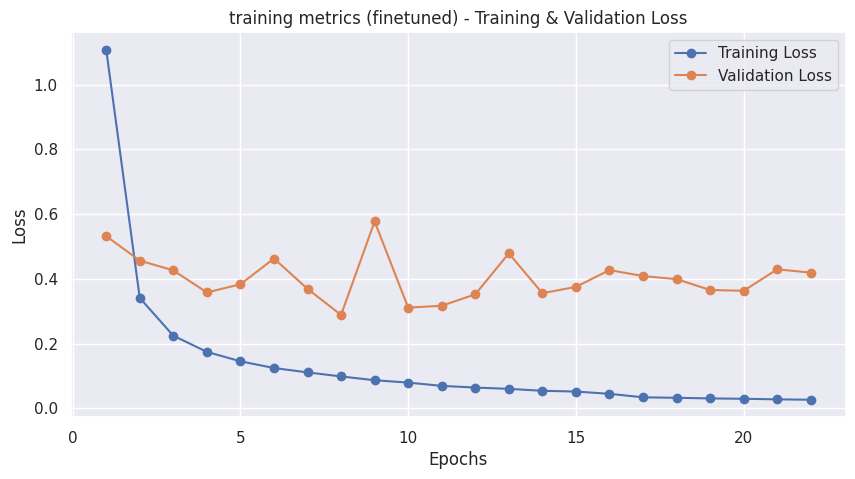

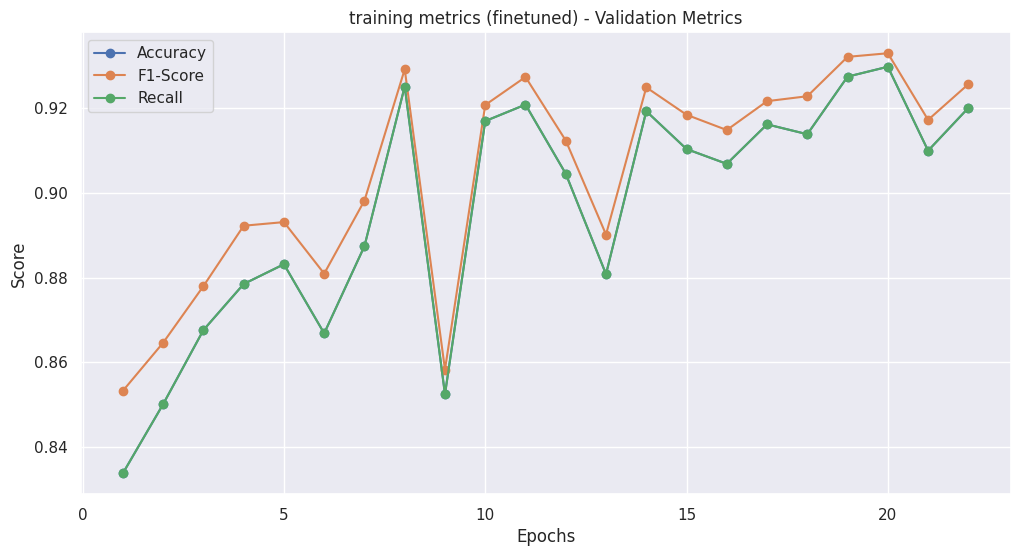

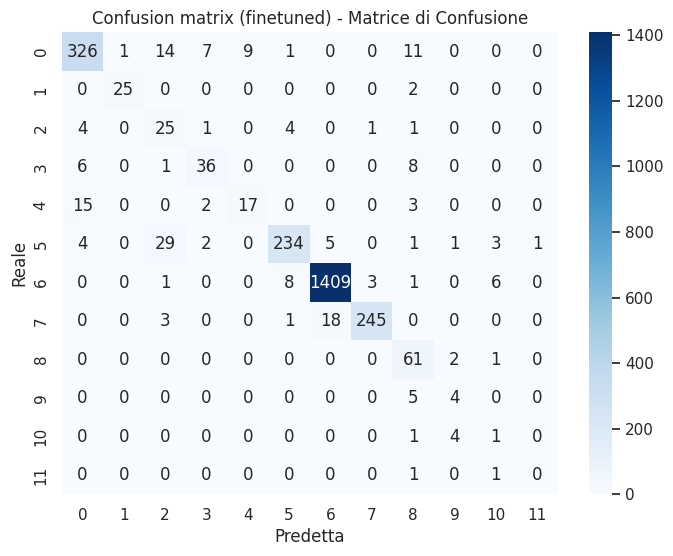

------ Training smote padding-------
Model already trained for smote


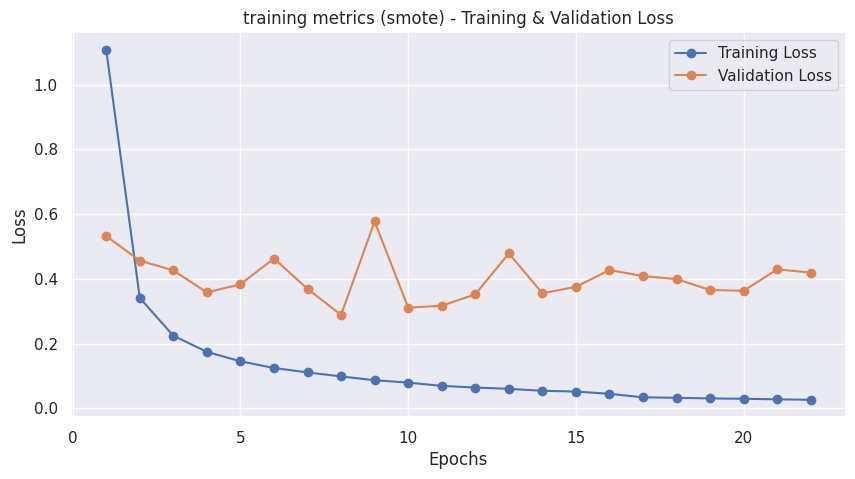

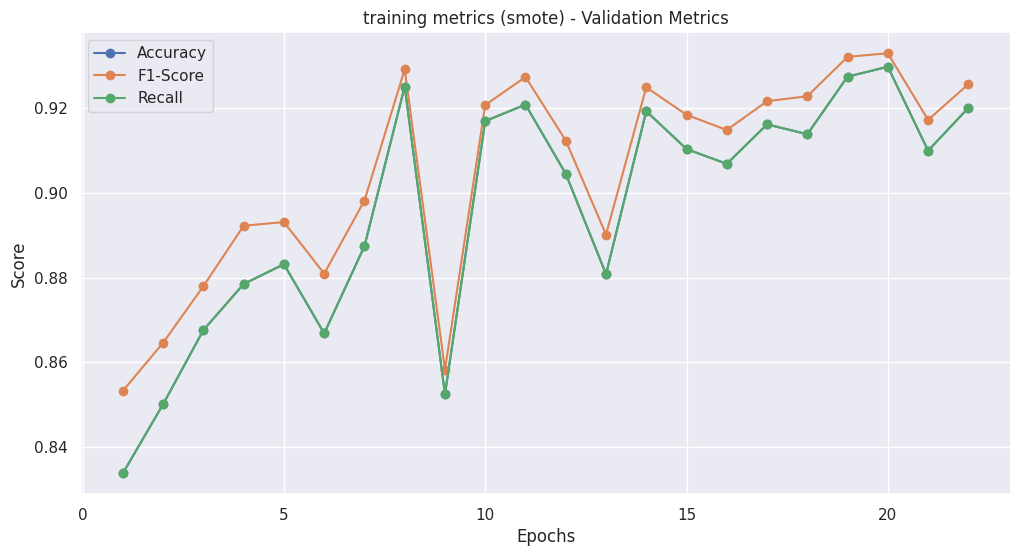

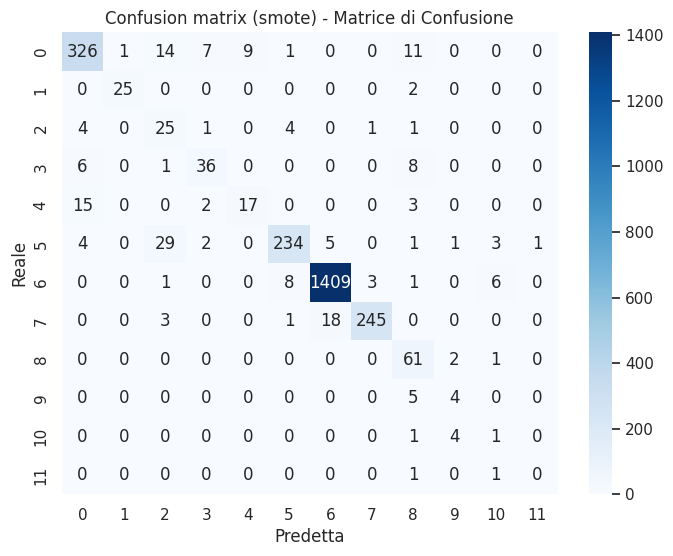

------ Training finetuned upsample-------
Model already trained for finetuned


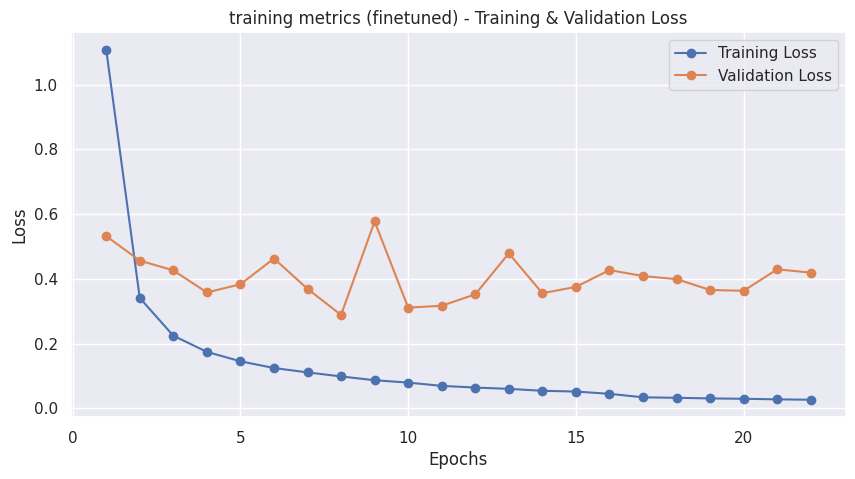

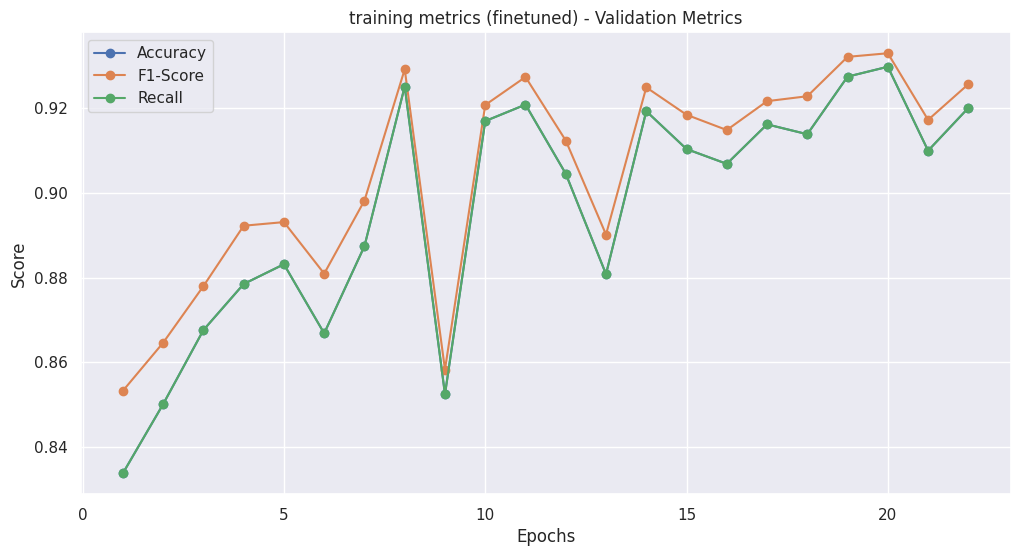

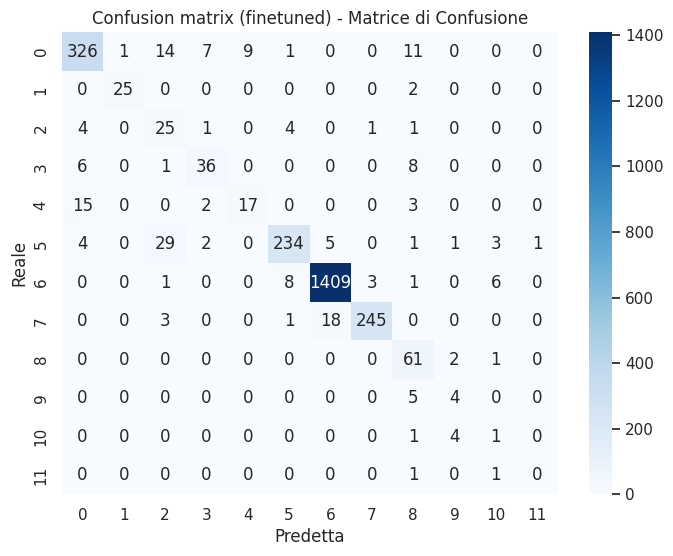

------ Training smote upsample-------
Model already trained for smote


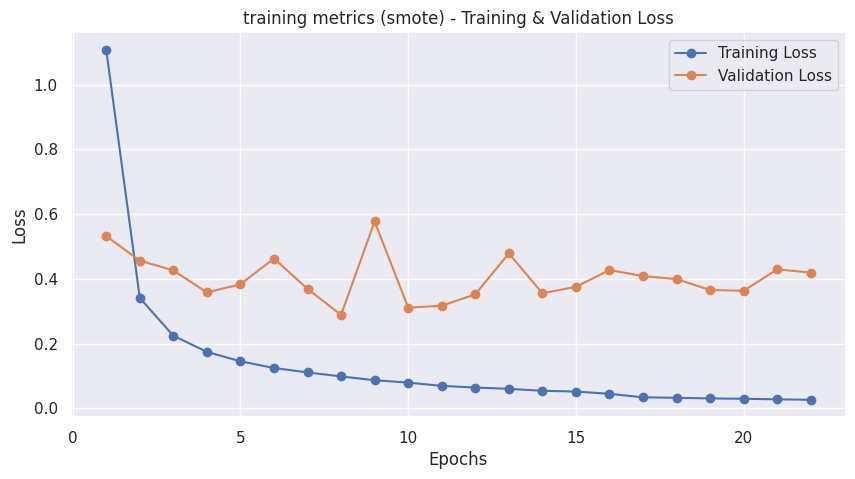

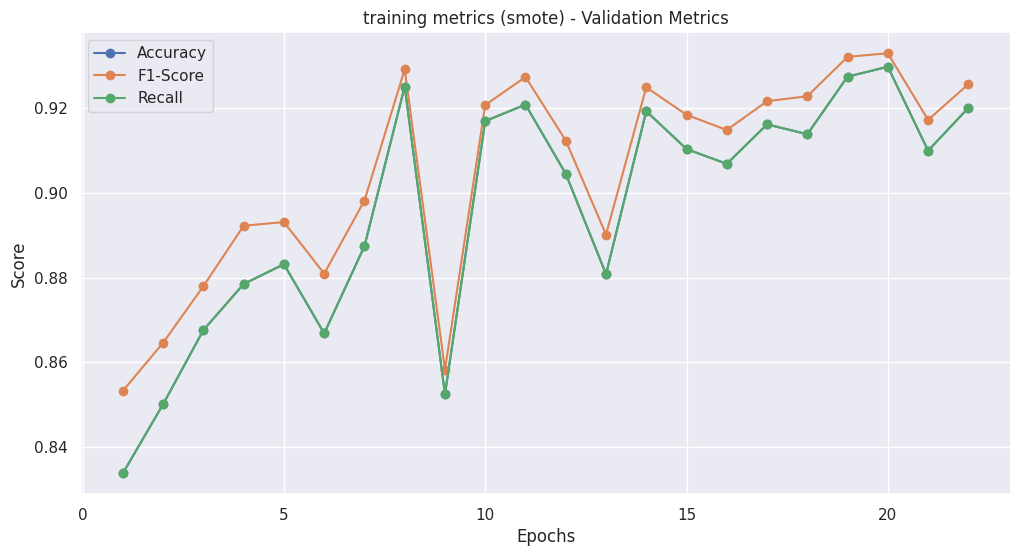

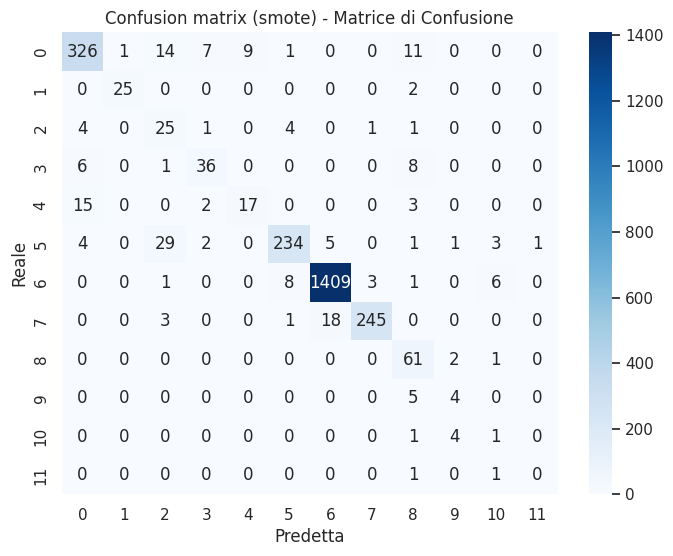

In [ ]:
num_classes = len(np.unique(labels_train_original))
loss = loss_HAR
dataset_types = ['finetuned', 'smote']

for dimension in ["padding", "upsample"]:
  for dataset_type in dataset_types:
      temp_path = f"/content/gdrive/MyDrive/Diffusion_Model_Project/{dimension}"

      try:
          if dataset_type == 'finetuned':
              train_loader = train_loader_finetuned

          elif dataset_type == 'smote':
              train_loader = train_loader_smote

          print(f"------ Training {dataset_type} {dimension}-------")
          model = HARClassifier(num_classes=num_classes, H=H, W=W).to(device)
          optimizer = optim.Adam(model.parameters(), lr= learning_rate_HAR)
          scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=scheduler_factor_HAR, patience= patience_scheduler_HAR)

          model_save_path = os.path.join(temp_path, f"HARmodel_{dataset_type}", "best_model.pth")
          history_save_path = os.path.join(temp_path, f"HARmodel_{dataset_type}", "history.pth")
          notes_save_path = os.path.join(temp_path, f"HARmodel_{dataset_type}", "notes.txt")


          if os.path.exists(model_save_path):
              print(f"Model already trained for {dataset_type}")
              plot_metrics(history, f'training metrics ({dataset_type})')
              min_loss_index = history['val_loss'].index(min(history['val_loss']))
              conf_matrix = history['val_confusion_matrix'][min_loss_index]
              classes_labels = np.unique(labels_train_original)
              plot_confusion_matrix(conf_matrix, classes=classes_labels, title=f'Confusion matrix ({dataset_type})')
              continue
          else:
              history = train_har_model(
                    model, train_loader, test_loader, loss, optimizer, scheduler,
                    num_epochs=epochs_HAR, device=device, patience=patience_HAR, min_delta=min_delta_HAR,
                    model_save_path=model_save_path
              )

          plot_metrics(history, f'training metrics ({dataset_type})')
          torch.save(history, history_save_path)
          min_loss_index = history['val_loss'].index(min(history['val_loss']))
          conf_matrix = history['val_confusion_matrix'][min_loss_index]
          classes_labels = np.unique(labels_train_original)
          plot_confusion_matrix(conf_matrix, classes=classes_labels, title=f'Confusion matrix ({dataset_type})')
          with open(notes_save_path, "w") as f:
              f.write(f"Model with parameters {Parameters}\n")
          print(f"File salvato correttamente in: {notes_save_path}")

      except Exception as e:
          print(f" Error during {dataset_type}: {e}")
          continue


## Results comparison


--- Analysis for dataset: finetuned with ridimension padding---
Accuracy: 0.9437 (Best Epoch: 21)
F1-Score: 0.9428 (Best Epoch: 21)
Precisione: 0.9440 (Best Epoch: 21)
Recall: 0.9437 (Best Epoch: 21)


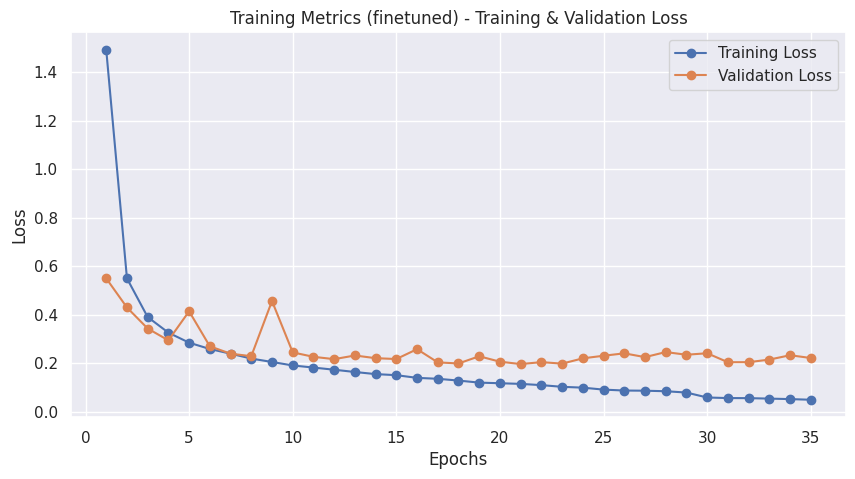

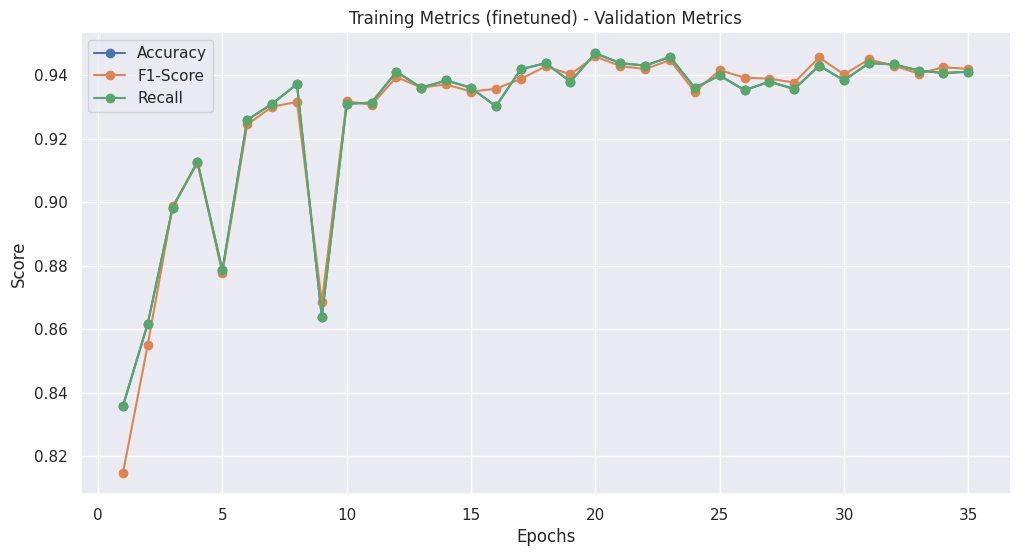

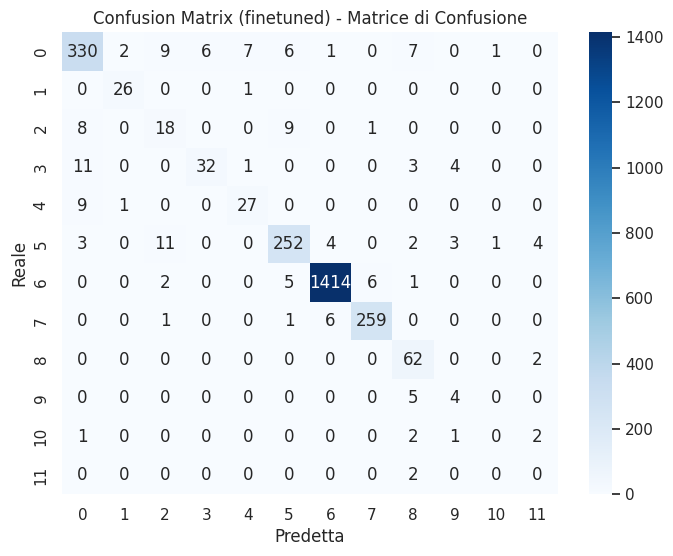


--- Analysis for dataset: smote with ridimension padding---
Accuracy: 0.9305 (Best Epoch: 14)
F1-Score: 0.9338 (Best Epoch: 14)
Precisione: 0.9409 (Best Epoch: 14)
Recall: 0.9305 (Best Epoch: 14)


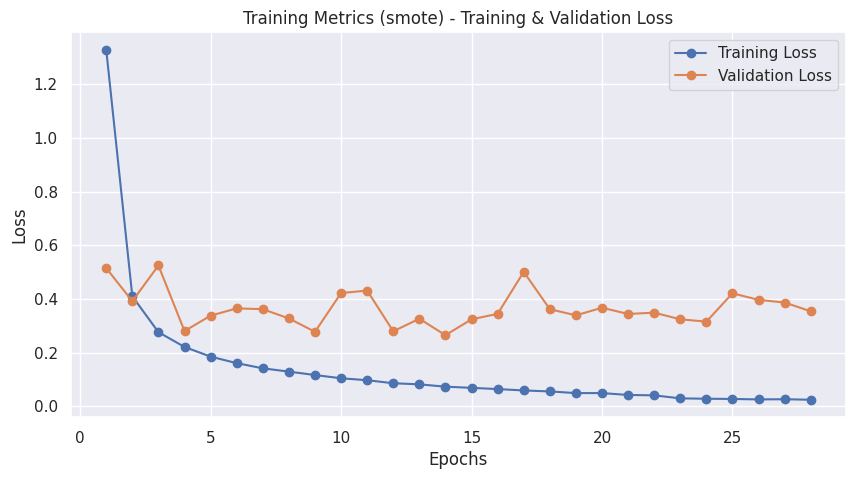

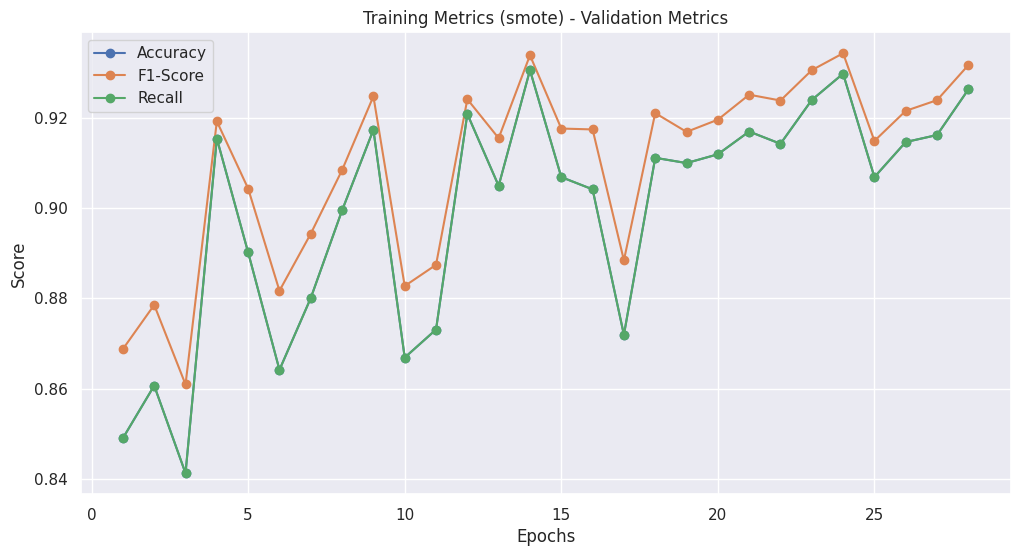

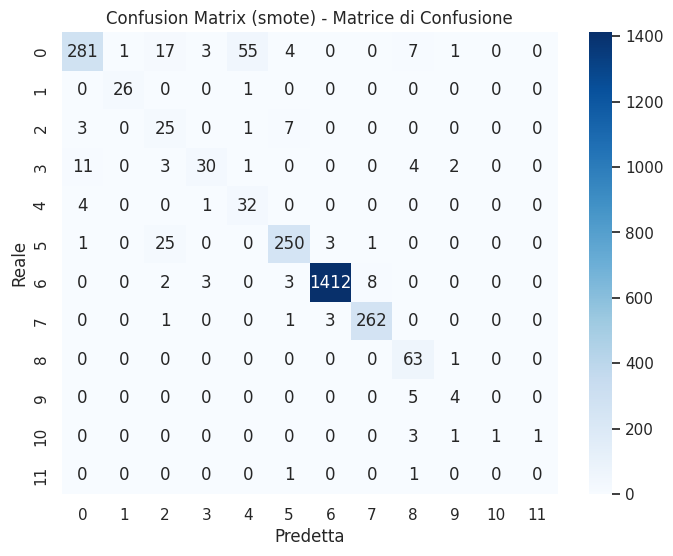


--- Analysis for dataset: finetuned with ridimension upsample---
Accuracy: 0.9507 (Best Epoch: 26)
F1-Score: 0.9506 (Best Epoch: 26)
Precisione: 0.9520 (Best Epoch: 26)
Recall: 0.9507 (Best Epoch: 26)


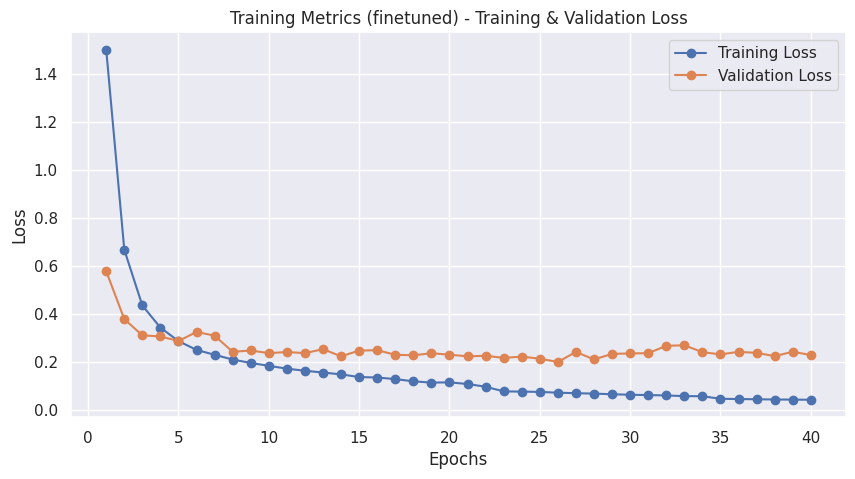

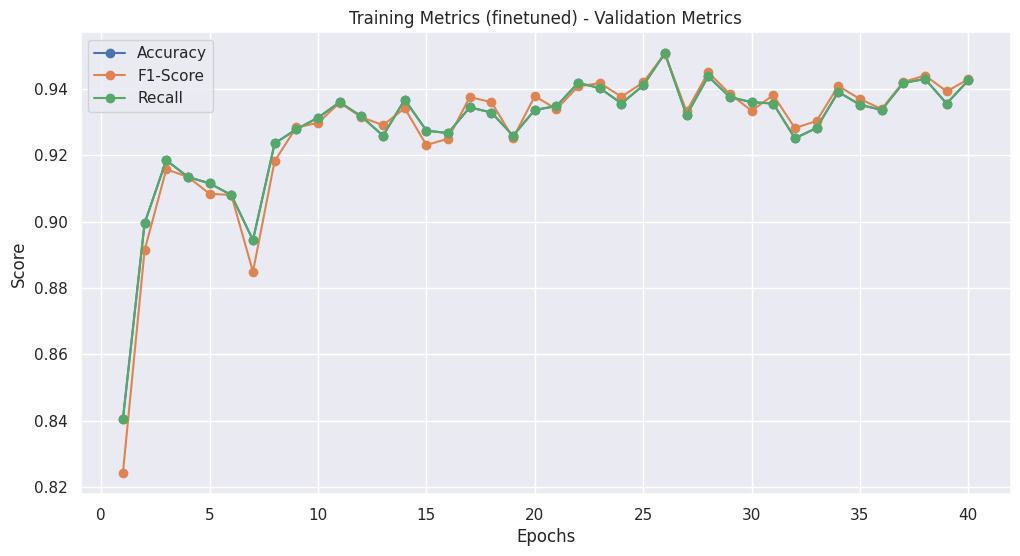

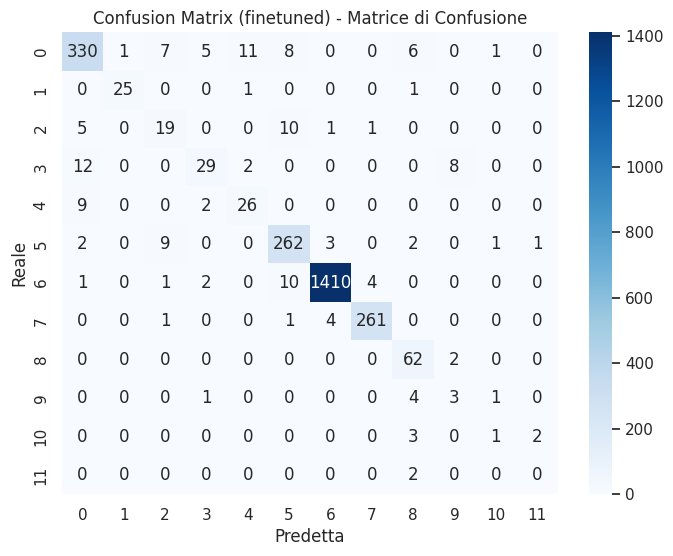


--- Analysis for dataset: smote with ridimension upsample---
Accuracy: 0.9251 (Best Epoch: 8)
F1-Score: 0.9291 (Best Epoch: 8)
Precisione: 0.9381 (Best Epoch: 8)
Recall: 0.9251 (Best Epoch: 8)


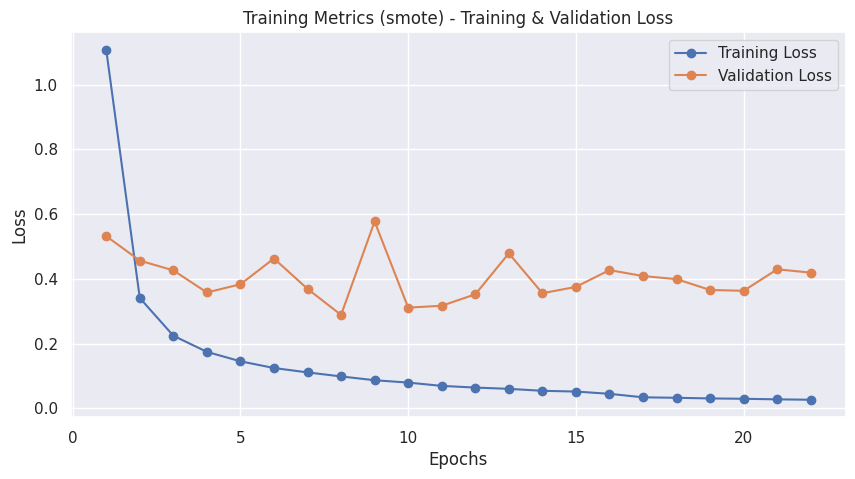

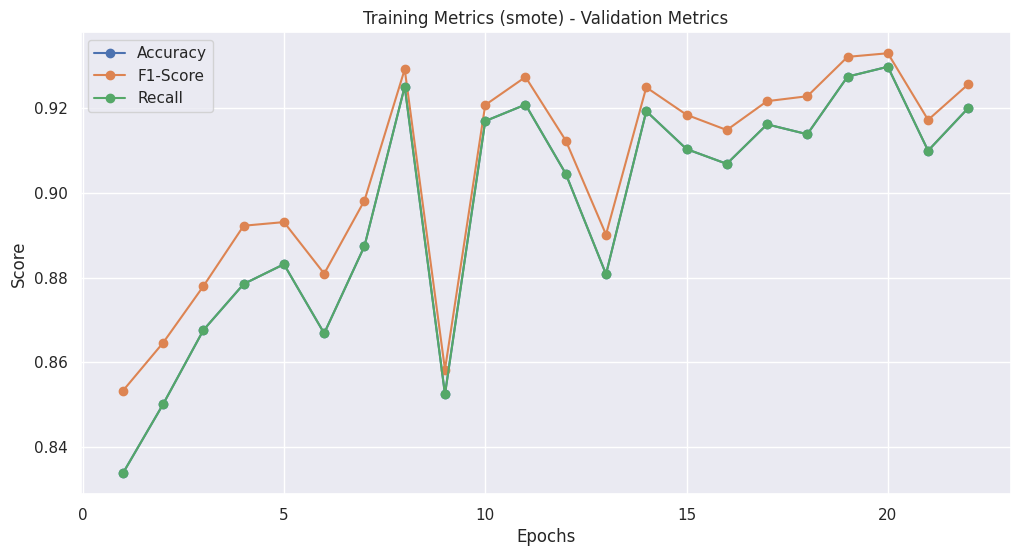

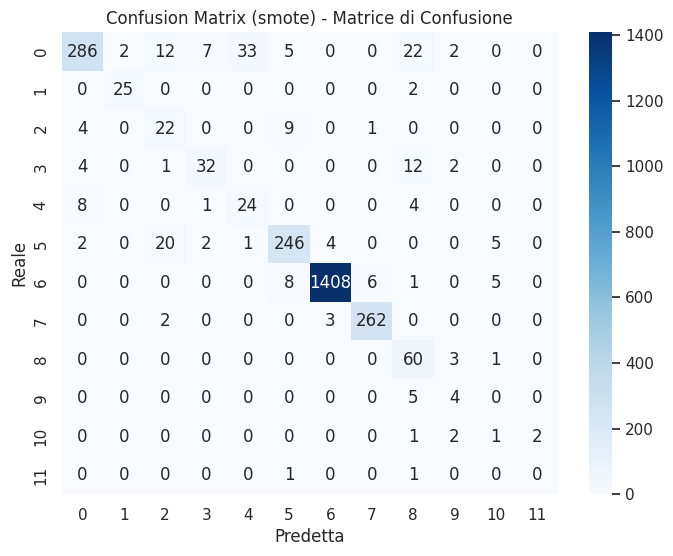

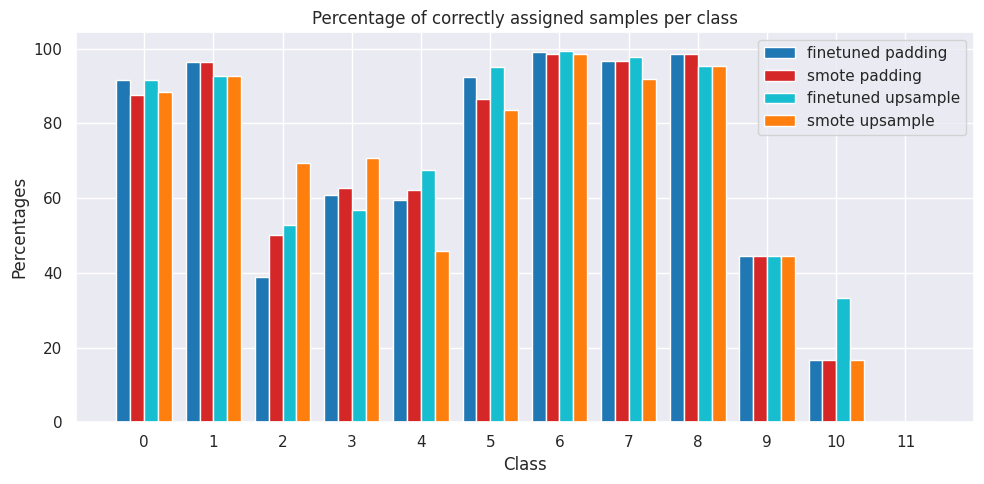

In [ ]:

dataset_types = ['finetuned', 'smote']

datasets = [
    "smote upsample",
    "finetuned upsample",
    "smote padding",
    "finetuned padding"
]

metrics = ["Accuracy", "F1 Score", "Recall", "Precision"]
diag = []
names = []
results_table = pd.DataFrame(index=datasets, columns=metrics)

for dimension in ["padding", "upsample"]:
  for dataset_type in dataset_types:
    try:
        temp_path = f"/content/gdrive/MyDrive/Diffusion_Model_Project/{dimension}"
        history_save_path = os.path.join(temp_path, f"HARmodel_{dataset_type}/", "history.pth")
        model_save_path = os.path.join(temp_path, f"HARmodel_{dataset_type}/", "best_model.pth")

        if os.path.exists(model_save_path) and os.path.exists(history_save_path):
            print(f"\n--- Analysis for dataset: {dataset_type} with ridimension {dimension}---")

            history = torch.load(history_save_path, weights_only=False)

            if history:
                min_loss_index = history['val_loss'].index(min(history['val_loss']))
                best_val_accuracy = history['val_accuracy'][min_loss_index]
                best_val_f1 = history['val_f1_score'][min_loss_index]
                best_val_precision = history['val_precision'][min_loss_index]
                best_val_recall = history['val_recall'][min_loss_index]
                conf_matrix = history['val_confusion_matrix'][min_loss_index]
                diag.append(conf_matrix.diagonal()/conf_matrix.sum(axis=1) * 100)
                names.append(f"{dataset_type} {dimension}")
                print(f"Accuracy: {best_val_accuracy:.4f} (Best Epoch: {min_loss_index + 1})")
                print(f"F1-Score: {best_val_f1:.4f} (Best Epoch: {min_loss_index + 1})")
                print(f"Precisione: {best_val_precision:.4f} (Best Epoch: {min_loss_index + 1})")
                print(f"Recall: {best_val_recall:.4f} (Best Epoch: {min_loss_index + 1})")

                results_table.loc[f"{dataset_type} {dimension}", "Accuracy"] = best_val_accuracy
                results_table.loc[f"{dataset_type} {dimension}", "F1 Score"] = best_val_f1
                results_table.loc[f"{dataset_type} {dimension}", "Recall"] = best_val_recall
                results_table.loc[f"{dataset_type} {dimension}", "Precision"] = best_val_precision

                if verbose == True:
                  plot_metrics(history, f'Training Metrics ({dataset_type})')
                  last_conf_matrix = history['val_confusion_matrix'][-1]
                  classes_labels = np.unique(labels_train_original)
                  plot_confusion_matrix(last_conf_matrix, classes=classes_labels, title=f'Confusion Matrix ({dataset_type})')

            else:
                print("No History file found")
        else:
            print(f"\n Model file not found {dataset_type}.")

    except Exception as e:
        print(f"  Error during history plotting for {dataset_type}: {e}")

print("\n \n")


x = np.arange(12)
width = 0.2
fig, ax = plt.subplots(figsize=(10, 5))
colors = [    "#1f77b4", "#d62728", "#17becf", "#ff7f0e" ]

for i, vect in enumerate(diag):
    ax.bar(x + (i - 1.5)*width, vect, width, label=names[i], color = colors[i])

ax.set_xticks(x)
ax.set_xticklabels([f"{i}" for i in x])  # etichette sull’asse x
ax.set_xlabel("Class")
ax.set_ylabel("Percentages")
ax.set_title("Percentage of correctly assigned samples per class")
ax.legend()
plt.tight_layout()
plt.show()



styled_table = results_table.style.highlight_max(axis=0, color='lightgreen')
styled_table


The results do not show a substantial advantage for the diffusion model, particularly when considering the higher computational cost it requires. Nevertheless, a slight improvement in performance was observed. The HAR model employed in this study was intentionally simple, serving only as a tool to evaluate the datasets.

Despite the modest gains, the findings are encouraging. Applied to a dataset with similar issues but a larger overall size, the diffusion-based approach could potentially outperform SMOTE more significantly. However, in the current setting, SMOTE appears more suitable for the task due to its lower computational demands, both in terms of sample generation and storage.

## Further developments

- compare with the results over the original, non-augmented dataset

- using Leave-One-Subject-Out (LOSO) cross-validation instead of a fixed test set to get less biased results.

- improve the finetuning

- Explore the parameters for the diffusion model using for comparison the results of the HAR classifier

